In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
import copy
import random
import astroalign as aa
import pickle
import seaborn as sns
import os.path
import jakeGloess as jg
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, join, MaskedColumn, vstack
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from astropy.io.votable import parse, parse_single_table
from astroquery.irsa_dust import IrsaDust
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

### Functions:

In [2]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/PAL5/'+savename, dpi=500)
    
    plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, std, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

def make_catalog(x, y, header):
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return cat, ra, dec

### Initial conditions:

In [17]:
run_all = True  # set to False to run only the first epoch
cluster = 'PAL13'
base_dir = 'data/'+cluster+'/'
channel = '3p6um'
#channel = '4p5um'
#method = 'aperture'
method = 'PSF'
model_epoch = 'master'  # ePSF model epoch to use (loads from file now for ease)

sigma_level = 6.
sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
#sharphi = 0.9
sharphi = 1.
sharphi_PSF = 0.85
sharphi_model = 0.7
#sharplo = 0.65
star_r = 20   # defines the bounds of the region around the known RRL location

if cluster == 'PAL5':
    ch1_list = [0, 2, 4, 5]
    ch2_list = [0, 1, 2, 3, 4, 5, 6]
    
if cluster == 'PAL13':
    ch1_list = [0, 1, 2, 4]
    ch2_list = [0, 1, 2, 3]

if channel == '3p6um':
    zmag       = 18.80    # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02    # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233  # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  0.0225  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
    starlist = ch1_list
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  0.0227
    starlist = ch2_list
else:
    print('Please select a valid channel')



### Generate master source list:

data/PAL13/PAL13/PAL13_3p6um.fits
[0, 1, 2, 4]
(array(958.1250007), array(351.78949713))


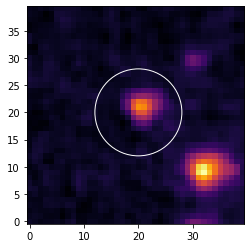

Mean: 610.8546752929688
Median: 586.1226806640625
Std dev: 104.42555236816406
 id     xcentroid     ...        flux                mag         
--- ----------------- ... ------------------ --------------------
  1 2.097584446636627 ... 1.1197931552279692 -0.12284452131988063
  2 32.05945116186483 ... 18.443772980805775  -3.1646244199302727
  3 20.58606261842802 ...  8.901326053089825  -2.3736367735339208
  4  30.2388305433402 ... 1.2432151194978411 -0.23636570802303575
  5 2.076518276531914 ... 1.0663871171865347   -0.069787224527741
Number of PSF stars: 5


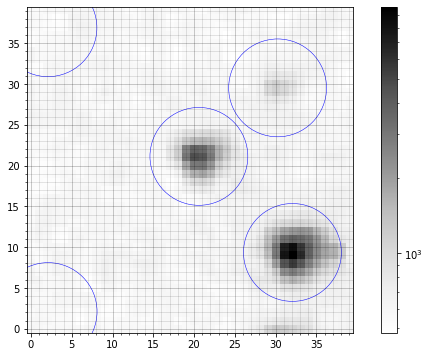

 id    x_0       y_0    sharpness  ...    peak      flux       mag      group_id
--- --------- --------- ---------- ... --------- --------- ------------ --------
  1 2.0975844 2.1042083 0.46165684 ... 583.32257 1.1197932  -0.12284452        1
  2 32.059451 9.3539851 0.70358917 ... 9706.9072 18.443773   -3.1646244        2
  3 20.586063  21.13464 0.57762485 ... 4364.7168 8.9013261   -2.3736368        3
  4 30.238831 29.537477 0.67146404 ... 1158.0369 1.2432151  -0.23636571        4
  5 2.0765183 36.913621 0.44548213 ... 551.04675 1.0663871 -0.069787225        5


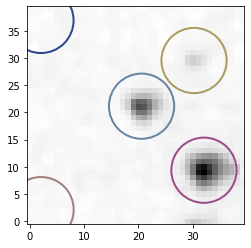

Time taken to fit PSF model: 0.15822090000006028s
pix_crd:  (array(958.1250007), array(351.78949713))
true crd:         x_0       
-----------------
940.2225851465897
970.1844518618179
958.7110633183812
968.3638312432934
940.2015189764851
974.6567255093909        y_0        
------------------
  333.893705469442
 341.1434822241317
352.92413707686006
  361.326974477204
368.70311853878604
340.79417218235875
   x_0       y_0      flux_0    id ...   x_true    y_true      RA       dec   
--------- --------- ---------- --- ... --------- --------- --------- ---------
2.0975844 2.1042083 -563.86447   1 ... 940.22259 333.89371 346.67469 12.786927
32.059451 9.3539851   131860.5   2 ... 970.18445 341.14348 346.67551 12.781852
20.586063  21.13464  53074.212   3 ... 958.71106 352.92414  346.6729 12.782865
30.238831 29.537477  7700.4011   4 ... 968.36383 361.32697 346.67221 12.780842
2.0765183 36.913621 -360.00602   5 ... 940.20152 368.70312  346.6692 12.784705
36.531725  9.004675  13512.481   1 ...

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

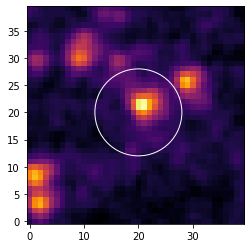

Mean: 742.3241577148438
Median: 662.7640380859375
Std dev: 257.3990478515625
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  1.975005156485483 ... 2.5560665445664705 -1.0189303901104931
  2 20.925763689376897 ...    4.0172479261572  -1.509821588066658
  3 28.961275655143893 ...  2.626163160172763 -1.0483042618869307
  4  9.307873148592765 ... 1.5458834769840684 -0.4729418882345382
Number of PSF stars: 4


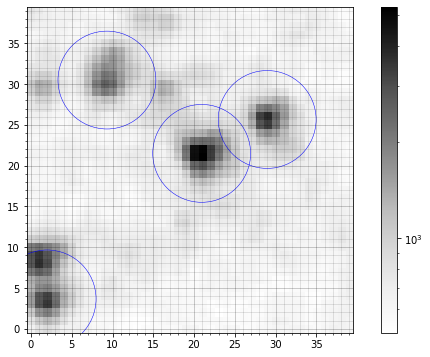

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 1.9750052 3.6551406 0.65903222 ... 3460.5017 2.5560665  -1.0189304        1
  2 20.925764 21.502948 0.66695443 ... 5322.7998 4.0172479  -1.5098216        2
  3 28.961276 25.661973 0.71363792 ... 3794.4006 2.6261632  -1.0483043        2
  4 9.3078731 30.496108 0.64330902 ... 2562.9448 1.5458835 -0.47294189        3


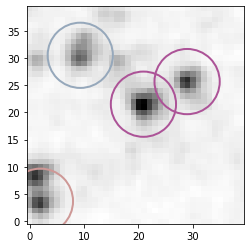

Time taken to fit PSF model: 0.06626949999997578s
pix_crd:  (array(1051.49162642), array(312.9469485))
true crd:         x_0        
------------------
 1033.466631578775
1052.4173901116665
1060.4529020774335
1040.7994995708823
 1032.777696485475        y_0        
------------------
 296.6020891171096
314.44989655821576
318.60892194297526
 323.4430560568756
301.49653310525093
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec   
--------- --------- --------- --- ... --------- --------- --------- ---------
1.9750052 3.6551406 60297.484   1 ... 1033.4666 296.60209 346.68669 12.774958
20.925764 21.502948 71688.421   2 ... 1052.4174  314.4499 346.68512   12.7709
28.961276 25.661973 47028.147   3 ... 1060.4529 318.60892 346.68499 12.769398
9.3078731 30.496108 40619.586   4 ... 1040.7995 323.44306 346.68293 12.772114
1.2860701 8.5495846 33990.768   1 ... 1032.7777 301.49653 346.68587 12.774751



(array(990.26350705), array(322.63366174))


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

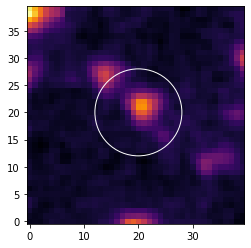

Mean: 655.9454956054688
Median: 609.0083618164062
Std dev: 159.6750946044922
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 33.096021396420184 ... 1.0095570792751245 -0.010327196295793567
  2 20.722962000676006 ...  6.186234639102832   -1.9785659710847423
  3 13.911792089117199 ... 2.7284965565077766   -1.0898085250481275
  4  0.875397126599799 ... 11.631945970725242   -2.6641309406584557
Number of PSF stars: 4


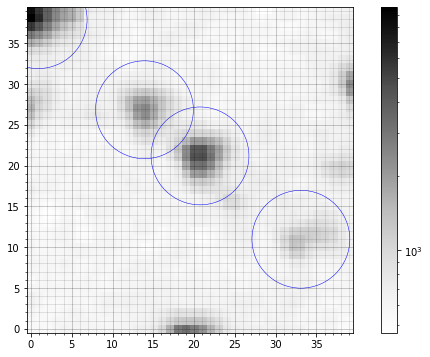

 id    x_0        y_0    sharpness  ...    flux       mag      group_id
--- ---------- --------- ---------- ... --------- ------------ --------
  1  33.096021  10.97261 0.50692727 ... 1.0095571 -0.010327196        1
  2  20.722962 21.194848 0.58988419 ... 6.1862346    -1.978566        2
  3  13.911792 26.854897 0.58076998 ... 2.7284966   -1.0898085        2
  4 0.87539713 37.905959 0.50848575 ... 11.631946   -2.6641309        3


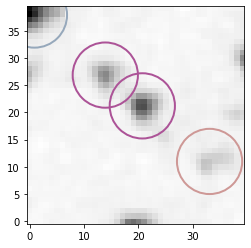

Time taken to fit PSF model: 0.06320149999999103s
pix_crd:  (array(990.26350705), array(322.63366174))
true crd:         x_0        
------------------
1003.3595284463922
 990.9864690506481
 984.1752991390892
 971.1389041765718        y_0        
------------------
313.60627136290486
323.82850964065597
329.48855922068327
 340.5396203773697
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec   
---------- --------- --------- --- ... --------- --------- --------- ---------
 33.096021  10.97261  16776.91   1 ... 1003.3595 313.60627 346.68203 12.778506
 20.722962 21.194848   60316.6   2 ... 990.98647 323.82851 346.67961 12.779757
 13.911792 26.854897 31919.651   3 ...  984.1753 329.48856 346.67827 12.780443
0.87539713 37.905959  69311.35   4 ...  971.1389 340.53962 346.67567 12.781744



(array(689.66628562), array(352.48080473))


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


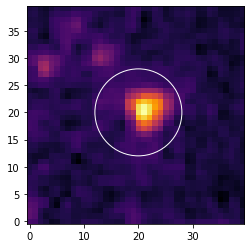

Mean: 639.9356689453125
Median: 604.9381713867188
Std dev: 150.8916778564453
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.183168621735117 ...  34.11091943523629  -3.832233564149396
  2 2.8432250979834706 ... 2.2687240619474913  -0.889454192928464
  3  13.28124671685925 ... 1.5733009963797717 -0.4920295442593413
Number of PSF stars: 3


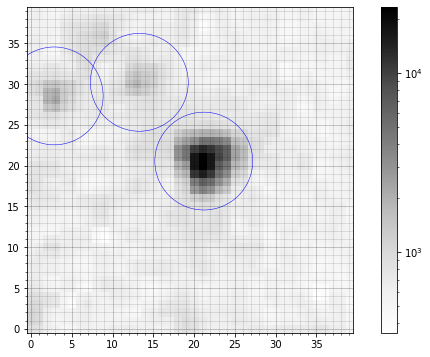

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 21.183169 20.559066 0.64830952 ...   23431.5 34.110919  -3.8322336        1
  2 2.8432251 28.553037 0.54562959 ... 1881.0868 2.2687241 -0.88945419        1
  3 13.281247 30.217203 0.73587793 ... 1807.6664  1.573301 -0.49202954        1


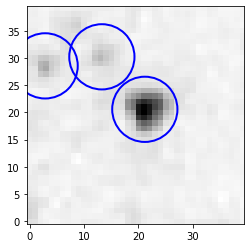

Time taken to fit PSF model: 0.17413030000000163s
pix_crd:  (array(689.66628562), array(352.48080473))
true crd:         x_0       
-----------------
690.8494542383706
 672.509510714619
682.9475323334948        y_0        
------------------
 353.0398708593374
361.03384174666047
 362.6980078265723
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec   
--------- --------- --------- --- ... --------- --------- --------- ---------
21.183169 20.559066 323106.32   1 ... 690.84945 353.03987 346.65532 12.824088
2.8432251 28.553037 24016.347   2 ... 672.50951 361.03384 346.65286   12.8264
13.281247 30.217203 24029.766   3 ... 682.94753 362.69801 346.65328 12.824687





C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


<Table length=3>
   x_0       y_0      flux_0    id  ...   x_true    y_true      RA       dec   
 float64   float64   float64  int32 ...  float64   float64   float64   float64 
--------- --------- --------- ----- ... --------- --------- --------- ---------
21.183169 20.559066 323106.32     1 ... 690.84945 353.03987 346.65532 12.824088
2.8432251 28.553037 24016.347     2 ... 672.50951 361.03384 346.65286   12.8264
13.281247 30.217203 24029.766     3 ... 682.94753 362.69801 346.65328 12.824687

In [18]:
epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

master_file = base_dir+cluster+'/'+cluster+'_'+channel+'.fits'
print(master_file)
with fits.open(master_file) as hdu_list:
    image_m = hdu_list[0].data
    hdr_m = hdu_list[0].header
    exptime = hdr_m['EXPTIME']
    if cluster == 'PAL13' and channel == '4p5um':
        fluxconv = 0.1469
    else:
        fluxconv = hdr_m['FLUXCONV']
    conv = exptime / fluxconv
    data_m = image_m * conv
    w = wcs.WCS(hdr_m)

print(starlist)

for star in range(len(tbl_CC)):
    
    if star in starlist:
    
        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        pix_crd = w.world_to_pixel(star_crd)
        print(pix_crd)

        star_x = int(pix_crd[0])
        star_y = int(pix_crd[1])
        star_ap = CircularAperture((star_r, star_r), r=8.)
        region_m = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
        plt.imshow(region_m, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
        star_ap.plot(color='white')
        plt.show()

        mean, median, std = sigma_clipped_stats(region_m, sigma=sigma_level)
        print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

        ###   DETECTING MORE STARS   ###

        sources_m = star_find(region_m, sigma_level, FWHM, std, roundness, sharphi_PSF)
        print(sources_m)
        pos_m = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
        ap_m = CircularAperture(pos_m, r_ap)
        print('Number of PSF stars: {}'.format(len(sources_m)))
        plotting(region_m, ap_m, an=None, cmap='Greys', choice='ap_only', savename=None)

        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

        sources_m['xcentroid'].name = 'x_0'
        sources_m['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        #daogroup = DAOGroup(crit_separation=4*FWHM)
        star_groups = daogroup(sources_m)
        star_groups = star_groups.group_by('group_id')
        print_table_nicely(star_groups)

        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(region_m, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        if ncolors > 1:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color=cmap.colors[i], lw=2.)
        else:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color='blue', lw=2.)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###

        region_m_nonans = np.nan_to_num(region_m, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        daofind_m = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
        fit_rad = 5

        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_m['x_0'], sources_m['y_0']])
        #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_m,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 2,
                              aperture_radius = 6.)
        master_stars = PSF_photometry(image=region_m_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

        master_stars['id_master'] = np.arange(len(master_stars))
        
        true_x = pix_crd[0]+master_stars['x_0']-star_r  # actual pixel coords of star in image,
        true_y = pix_crd[1]+master_stars['y_0']-star_r  # since pix_crd is measured relative to the box
        print('pix_crd: ',pix_crd)
        print('true crd: ', true_x, true_y)
        
        master_stars['x_true'] = true_x
        master_stars['y_true'] = true_y
        
        cat_m, ra_m, dec_m = make_catalog(true_x, true_y, hdr_m)
        master_stars['RA'] = ra_m
        master_stars['dec'] = dec_m
        
        print_table_nicely(master_stars)
        master_stars['id_master', 'x_0', 'y_0', 'x_true', 'y_true', 'RA', 'dec'].write('outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt', format='csv', overwrite=True)
        
        print('\n\n')
        
master_stars

In [6]:
master_file = 'outputs/'+cluster+'/masterlist_RRL0_'+channel+'.txt'
print(master_file)
master_table = Table.read(master_file, format='ascii.csv')
print_table_nicely(master_table)

outputs/PAL13/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0      x_true    y_true      RA       dec   
--------- --------- --------- --------- --------- --------- ---------
        0 2.0975844 2.1042083 940.22259 333.89371 346.67469 12.786927
        1 32.059451 9.3539851 970.18445 341.14348 346.67551 12.781852
        2 20.586063  21.13464 958.71106 352.92414  346.6729 12.782865
        3 30.238831 29.537477 968.36383 361.32697 346.67221 12.780842
        4 2.0765183 36.913621 940.20152 368.70312  346.6692 12.784705
        5 36.531725  9.004675 974.65673 340.79417 346.67586 12.781186


### Main photometry cell:

In [11]:
tbl_CC = Table.read('data/reference/CVSGC_PAL5_readable.txt', format='ascii.csv')
tbl_CC

<Table length=7>
  ID       RA          dec      ...       gaia_ID       gaia_ID_1  gaia_ID_2 
int32    str12        str12     ...        str19          str10      str10   
----- ------------ ------------ ... ------------------- ---------- ----------
    1 15h15m57.18s -00d06m53.3s ... 4418914863842345856 4418914863  842345856
    2 15h15m57.95s -00d11m23.4s ... 4418913218870688768 4418913218  870688768
    3 15h16m12.76s -00d10m03.3s ... 4418726027016125056 4418726027  016125056
    4 15h16m05.79s -00d11m12.7s ...                   0          0          0
    5 15h15m58.23s -00d05m47.4s ... 4418920808077110784  441892080 8077110784
    6    228.99635     -0.08978 ... 4418920846732620032 4418920846  732620032
    7    229.03964  -0.27308442 ... 4418724034151291776 4418724034  151291776

Photometry method selected: PSF
outputs/PAL13/masterlist_RRL0_4p5um.txt
id_master    x_0       y_0      x_true    y_true      RA       dec   
--------- --------- --------- --------- --------- --------- ---------
        0 2.1471372 2.1200511 261.08713 355.24619  346.6747 12.786915
        1 36.860496 2.1543853 295.80049 355.28053 346.67696 12.781564
        2 32.895694 8.7208411 291.83568 361.84698 346.67566 12.781757
        3 21.675824 20.299412 280.61581 373.42555  346.6731 12.782751
        4 31.172514 28.711974  290.1125 381.83812 346.67239 12.780753
        5 36.863781 36.907425 295.80377 390.03357 346.67147 12.779355
        6 2.0623511 36.876755 261.00234  390.0029 346.66921 12.784719
data/PAL13\PAL13__e1\PAL13__e1_4p5um.fits
EXPTIME: 81.4382324219
FLUXCONV: 0.1469
(array(277.93003852), array(372.37487092))


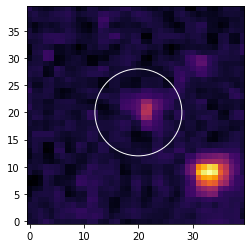

Mean: 169.51730346679688
Median: 167.78656005859375
Std dev: 13.839648246765137
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  2.164852667969342 ... 2.5261209993919325   -1.006135372782713
  2  32.95734682097031 ... 11.674014214580515   -2.668050544456537
  3 21.549908362386216 ...  2.676694850472113  -1.0689971585333597
  4  31.15291818285654 ... 1.0976461753713218 -0.10115592121452871
  5 2.0947000740155355 ... 2.5200022144865777  -1.0035023060598904
  6 36.928643608563654 ... 2.4343157176762165  -0.9659422580226382
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  2.164852667969342 ... 2.5261209993919325   -1.006135372782713
  2  32.95734682097031 ... 11.674014214580515   -2.668050544456537
  3 21.549908362386216 ...  2.676694850472113  -1.0689971585333597
  4  31.1529181828565

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


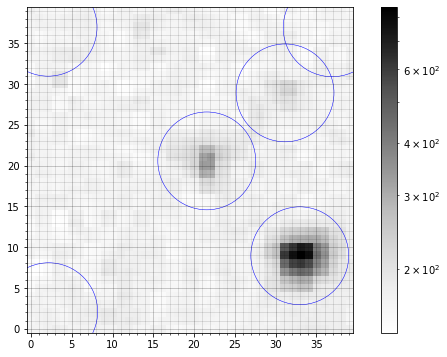

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.1648527 2.0882795 0.42609809 ... 169.34233  2.526121  -1.0061354        1
  2 32.957347 8.9504909 0.55369781 ... 846.82825 11.674014  -2.6680505        2
  3 21.549908 20.583114 0.60635441 ... 329.92435 2.6766949  -1.0689972        3
  4 31.152918 28.923639 0.58566407 ... 226.21631 1.0976462 -0.10115592        4
  6 36.928644 36.906619 0.43457228 ... 164.93269 2.4343157 -0.96594226        4
  5 2.0947001 36.972005 0.46469092 ...  173.6927 2.5200022  -1.0035023        5


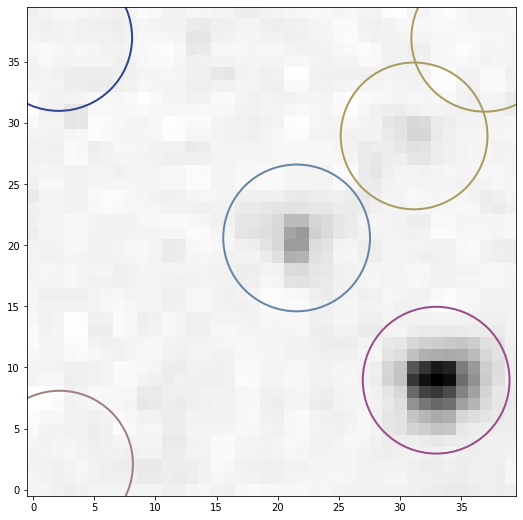

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07169720000001689s
   x_0       y_0      flux_0   id ...  flux_fit   flux_unc iter_detected
--------- --------- --------- --- ... ---------- --------- -------------
2.1648527 2.0882795 39.409842   1 ...  61.986169 52.851991             1
32.957347 8.9504909 12115.017   2 ...  10685.366 287.43163             1
21.549908 20.583114 2691.6142   3 ...  2428.1501 69.779586             1
31.152918 28.923639 674.33356   4 ...  824.55183 55.967645             1
36.928644 36.906619  -305.731   6 ... -172.32888 54.725081             1
2.0947001 36.972005 160.47018   5 ... -15.916907 49.478506             1


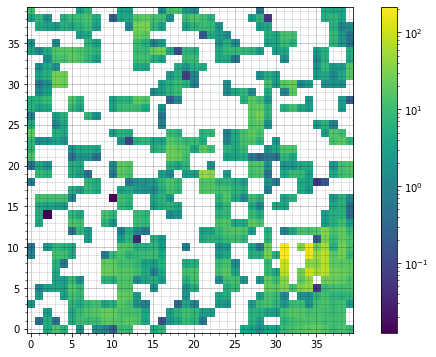

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.1648527 2.0882795    20.564539  0.92621516
  2        2             1 32.957347 8.9504909    14.973302 0.041541243
  3        3             1 21.549908 20.583114    16.582087 0.042967848
  4        4             1 31.152918 28.923639    17.754731 0.079396361
  6        4             1 36.928644 36.906619          nan         nan
  5        5             1 2.0947001 36.972005          nan         nan
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 2.1648527 2.0882795 20.564539  0.92621516
  2 32.957347 8.9504909 14.973302 0.041541243
  3 21.549908 20.583114 16.582087 0.042967848
  4 31.152918 28.923639 17.754731 0.079396361
  6 36.928644 36.906619       nan         nan
  5 2.0947001 36.972005       nan         nan
id_master    x_0       y_0      x_tru

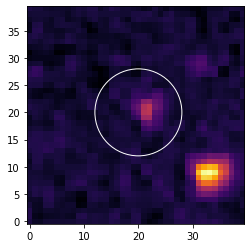

Mean: 168.60330200195312
Median: 166.93600463867188
Std dev: 13.356433868408203
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 2.093541020532445 ... 2.4343494459993194 -0.9659573011855127
  2 36.74113599342428 ...  2.296380041847568 -0.9026094092483862
  3 32.87739264130678 ...  11.95308167788533  -2.693699717846796
  4 21.66819479730705 ... 2.9310106602411166 -1.1675434949833914
  5 2.092920827094492 ...  2.561208280205707  -1.021112242994563
  6 36.84851272420665 ... 2.3517554762700197 -0.9284804099778744
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 2.093541020532445 ... 2.4343494459993194 -0.9659573011855127
  2 36.74113599342428 ...  2.296380041847568 -0.9026094092483862
  3 32.87739264130678 ...  11.95308167788533  -2.693699717846796
  4 21.66819479730705 ... 2.9310106602411166 -1

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


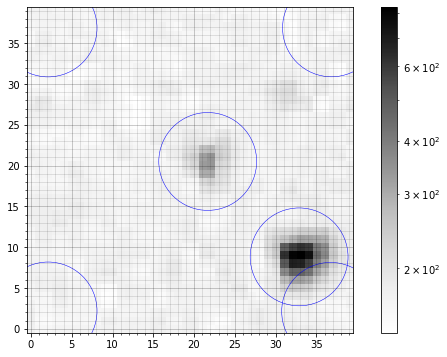

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1  2.093541 2.1790609 0.37515916 ... 153.29111 2.4343494  -0.9659573        1
  2 36.741136 2.1274005  0.4257318 ... 157.43762   2.29638 -0.90260941        2
  3 32.877393  8.812669 0.53695673 ... 830.28638 11.953082  -2.6936997        2
  4 21.668195 20.512889 0.61416467 ... 341.21542 2.9310107  -1.1675435        3
  5 2.0929208 36.885119  0.4253184 ... 166.56552 2.5612083  -1.0211122        4
  6 36.848513 36.896571 0.38388253 ... 153.49677 2.3517555 -0.92848041        5


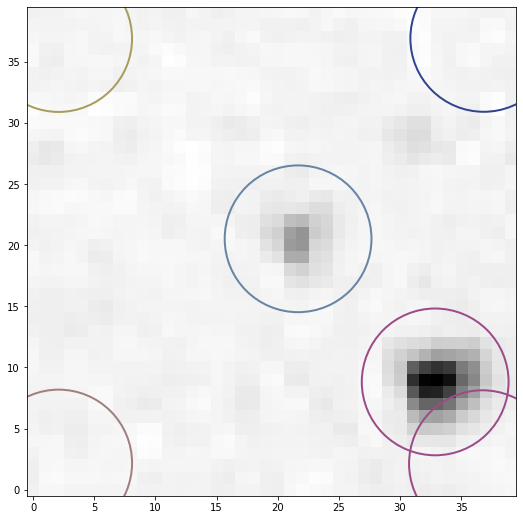

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07552549999991243s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
 2.093541 2.1790609 -91.446126   1 ... -130.37519 41.581525             1
36.741136 2.1274005  1776.3732   2 ... -136.81203 238.30665             1
32.877393  8.812669  11837.693   3 ...  10410.148  228.1162             1
21.668195 20.512889  2680.1058   4 ...  2507.5152 57.577766             1
2.0929208 36.885119 -160.31567   5 ... -15.280765 40.523181             1
36.848513 36.896571 -280.06295   6 ... -139.95567 49.067042             1


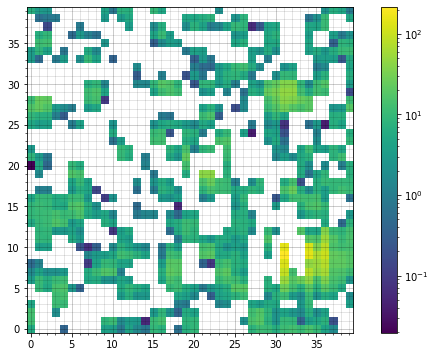

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  2.093541 2.1790609          nan         nan
  2        2             1 36.741136 2.1274005          nan         nan
  3        2             1 32.877393  8.812669    15.001763 0.037930654
  4        3             1 21.668195 20.512889    16.547296 0.038655369
  5        4             1 2.0929208 36.885119          nan         nan
  6        5             1 36.848513 36.896571          nan         nan
first match table:
 id  xcenter   ycenter    mag_e2     err_e2  
--- --------- --------- --------- -----------
  1  2.093541 2.1790609       nan         nan
  2 36.741136 2.1274005       nan         nan
  3 32.877393  8.812669 15.001763 0.037930654
  4 21.668195 20.512889 16.547296 0.038655369
  5 2.0929208 36.885119       nan         nan
  6 36.848513 36.896571       nan         nan
id_master    x_0       y_0      x_tru

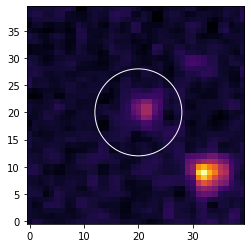

Mean: 167.299072265625
Median: 165.16268920898438
Std dev: 13.08346939086914
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1375339128579123 ...  2.529149976230876 -1.0074364584126725
  2   36.8899045636592 ... 2.9545398955483533 -1.1762246467297457
  3  32.27963743887385 ... 13.937271792896036  -2.860444423420522
  4 21.322878758179584 ... 2.9515831510654875 -1.1751375563402913
  5  2.109742179986995 ... 2.7900280383104845 -1.1140214193151223
  6  36.93154035118686 ... 2.7486416032947982 -1.0977952891698015
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1375339128579123 ...  2.529149976230876 -1.0074364584126725
  2   36.8899045636592 ... 2.9545398955483533 -1.1762246467297457
  3  32.27963743887385 ... 13.937271792896036  -2.860444423420522
  4 21.322878758179584 ... 2.95158315

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


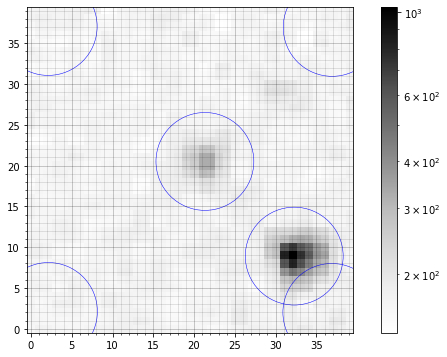

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 2.1375339 2.1151534 0.41636517 ... 161.08984   2.52915 -1.0074365        1
  2 36.889905 1.9982474 0.48733626 ... 190.37155 2.9545399 -1.1762246        2
  3 32.279637 8.9052755 0.71911477 ... 1034.5261 13.937272 -2.8604444        2
  4 21.322879 20.515384 0.54103051 ...  329.3566 2.9515832 -1.1751376        3
  5 2.1097422  37.06708 0.47531464 ... 179.27985  2.790028 -1.1140214        4
  6  36.93154 36.952305 0.38399314 ... 163.06062 2.7486416 -1.0977953        5


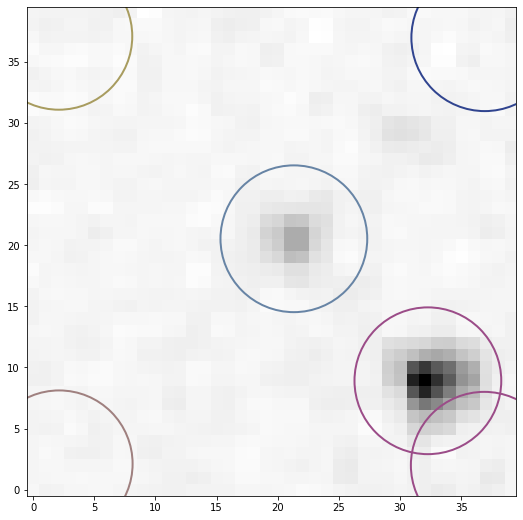

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.08054179999999178s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.1375339 2.1151534    45.8555   1 ... -8.4824585 37.446839             1
36.889905 1.9982474  1657.1109   2 ...  207.15218 154.40092             1
32.279637 8.9052755  12156.148   3 ...  12004.791 157.32487             1
21.322879 20.515384  3221.6664   4 ...  2676.0448 69.061829             1
2.1097422  37.06708 -88.952484   5 ...  62.283671 54.708873             1
 36.93154 36.952305 -70.008854   6 ...  33.229761 49.454838             1


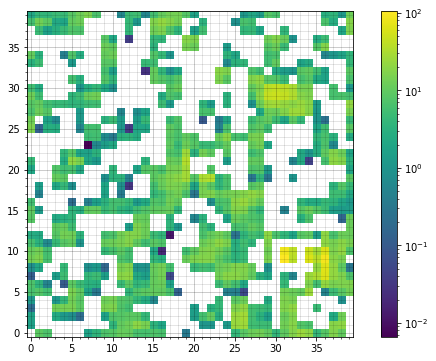

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.1375339 2.1151534          nan         nan
  2        2             1 36.889905 1.9982474     19.25458  0.80979272
  3        2             1 32.279637 8.9052755    14.846917 0.032789515
  4        3             1 21.322879 20.515384     16.47657 0.040716314
  5        4             1 2.1097422  37.06708    20.559368  0.95414886
  6        5             1  36.93154 36.952305    21.241486    1.616138
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1 2.1375339 2.1151534       nan         nan
  2 36.889905 1.9982474  19.25458  0.80979272
  3 32.279637 8.9052755 14.846917 0.032789515
  4 21.322879 20.515384  16.47657 0.040716314
  5 2.1097422  37.06708 20.559368  0.95414886
  6  36.93154 36.952305 21.241486    1.616138
id_master    x_0       y_0      x_tru

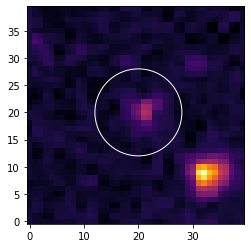

Mean: 166.82183837890625
Median: 165.17105102539062
Std dev: 13.14789867401123
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 36.900372607887064 ... 2.6195409336545517 -1.0455629730998237
  2 32.269568483977935 ... 12.529117900793524 -2.7448012400745414
  3 21.236495879252825 ...  3.016674453547264  -1.198821113806319
  4 1.9060479715043468 ... 2.6885966845601095  -1.073814146868198
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 36.900372607887064 ... 2.6195409336545517 -1.0455629730998237
  2 32.269568483977935 ... 12.529117900793524 -2.7448012400745414
  3 21.236495879252825 ...  3.016674453547264  -1.198821113806319
  4 1.9060479715043468 ... 2.6885966845601095  -1.073814146868198
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


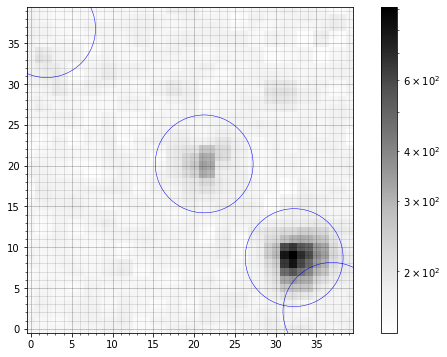

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 36.900373 2.1250041 0.43708136 ... 169.93777 2.6195409  -1.045563        1
  2 32.269568 8.7197103 0.64288689 ... 914.41974 12.529118 -2.7448012        1
  3 21.236496 20.215377 0.59621911 ... 335.48856 3.0166745 -1.1988211        2
  4  1.906048 36.803061 0.40559776 ... 163.99329 2.6885967 -1.0738141        3


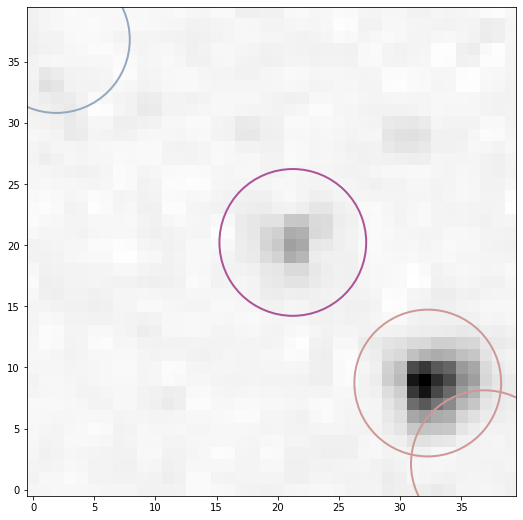

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0481661000000031s
   x_0       y_0      flux_0   id ...  flux_fit   flux_unc iter_detected
--------- --------- --------- --- ... ---------- --------- -------------
36.900373 2.1250041 1829.4802   1 ...  61.243757 182.76125             1
32.269568 8.7197103 12351.019   2 ...  10912.642 177.74275             1
21.236496 20.215377 2895.8353   3 ...  2637.8417 73.059678             1
 1.906048 36.803061 68.383573   4 ... -2.5471531 68.928546             1


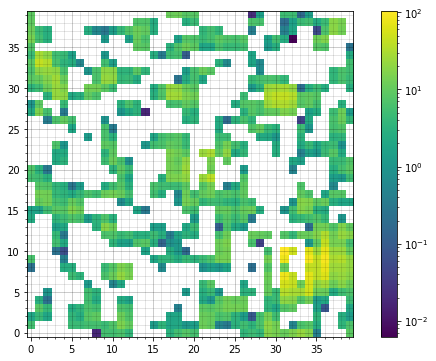

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 36.900373 2.1250041    20.577654   3.2401466
  2        1             1 32.269568 8.7197103    14.950484 0.034430028
  3        2             1 21.236496 20.215377    16.492187  0.04215427
  4        3             1  1.906048 36.803061          nan         nan
first match table:
 id  xcenter   ycenter    mag_e4     err_e4  
--- --------- --------- --------- -----------
  1 36.900373 2.1250041 20.577654   3.2401466
  2 32.269568 8.7197103 14.950484 0.034430028
  3 21.236496 20.215377 16.492187  0.04215427
  4  1.906048 36.803061       nan         nan
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.1471372 2.1200511 261.08713 ...         nan       nan         nan
        1 36.860496 2.1543853 295.80049

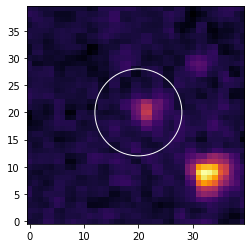

Mean: 166.79296875
Median: 165.20057678222656
Std dev: 13.276189804077148
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.86949613912392 ... 2.2213741419753283 -0.8665542803320182
  2  32.66198888207931 ... 11.234547543300557  -2.626388966163638
  3 21.513186461791822 ... 3.0862504327359725 -1.2235779095855583
  4 2.0487771154080177 ...  2.662842116434735  -1.063363543215376
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.86949613912392 ... 2.2213741419753283 -0.8665542803320182
  2  32.66198888207931 ... 11.234547543300557  -2.626388966163638
  3 21.513186461791822 ... 3.0862504327359725 -1.2235779095855583
  4 2.0487771154080177 ...  2.662842116434735  -1.063363543215376
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


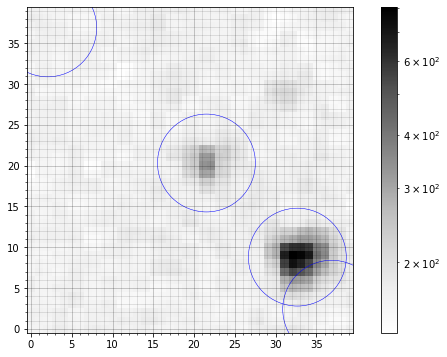

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 36.869496 2.3926443 0.36464193 ... 145.31567 2.2213741 -0.86655428        1
  2 32.661989 8.7804707 0.48882933 ... 777.41412 11.234548   -2.626389        1
  3 21.513186 20.323125 0.56638492 ...  335.8848 3.0862504  -1.2235779        2
  4 2.0487771 36.894101 0.44651926 ... 172.84613 2.6628421  -1.0633635        3


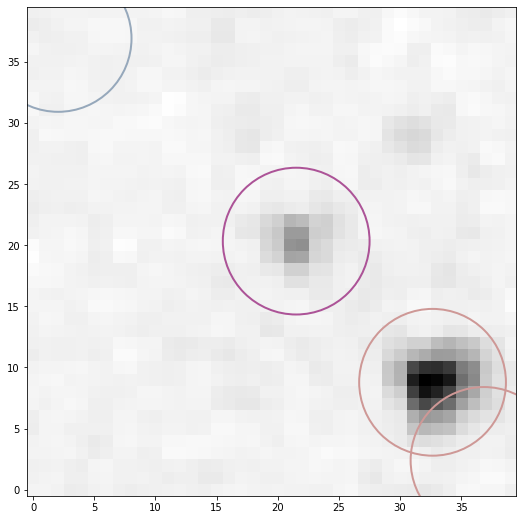

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06480129999999917s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
36.869496 2.3926443  2175.6893   1 ... -66.448788 245.44666             1
32.661989 8.7804707  12627.105   2 ...   10532.63  250.1231             1
21.513186 20.323125  2867.9547   3 ...  2685.8446  60.03222             1
2.0487771 36.894101 -111.49673   4 ...  46.266646 33.078033             1


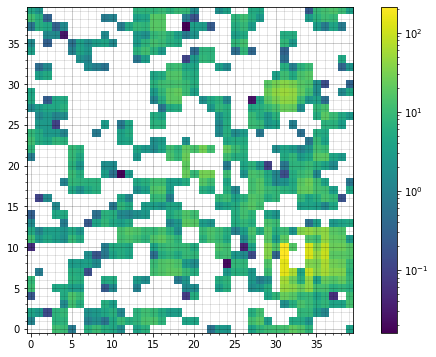

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 36.869496 2.3926443          nan         nan
  2        1             1 32.661989 8.7804707    14.989138 0.039210735
  3        2             1 21.513186 20.323125    16.472778 0.038231058
  4        3             1 2.0487771 36.894101     20.88231  0.77680186
first match table:
 id  xcenter   ycenter    mag_e5     err_e5  
--- --------- --------- --------- -----------
  1 36.869496 2.3926443       nan         nan
  2 32.661989 8.7804707 14.989138 0.039210735
  3 21.513186 20.323125 16.472778 0.038231058
  4 2.0487771 36.894101  20.88231  0.77680186
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.1471372 2.1200511 261.08713 ...         nan        --          --
        1 36.860496 2.1543853 295.80049

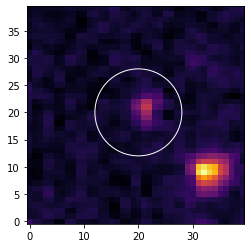

Mean: 165.5234375
Median: 163.75384521484375
Std dev: 13.644172668457031
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1675442972552545 ... 2.5576094634790256 -1.0195855755280152
  2 36.953542551411374 ...  2.504685474825613 -0.9968829930492457
  3   32.4830180216261 ... 12.302237201282786 -2.7249602411639415
  4 21.380050098178096 ... 3.3053793547631742 -1.2980532754586738
  5   2.13235581563837 ...  2.333883937242892 -0.9201981375550168
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1675442972552545 ... 2.5576094634790256 -1.0195855755280152
  2 36.953542551411374 ...  2.504685474825613 -0.9968829930492457
  3   32.4830180216261 ... 12.302237201282786 -2.7249602411639415
  4 21.380050098178096 ... 3.3053793547631742 -1.2980532754586738
  5   2.13235581563837 ...  2.33388393724

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


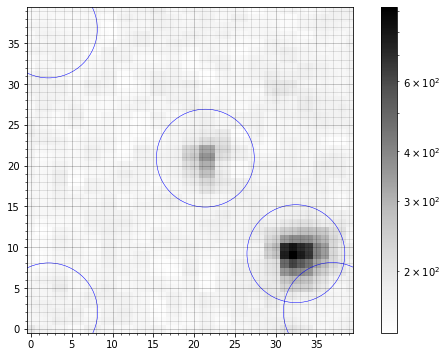

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.1675443 2.0699448  0.3744446 ... 161.44621 2.5576095  -1.0195856        1
  2 36.953543 2.1164459 0.42294216 ... 164.90973 2.5046855 -0.99688299        2
  3 32.483018 9.2054008 0.63609201 ... 923.89471 12.302237  -2.7249602        2
  4  21.38005 20.920578 0.63506305 ... 363.00723 3.3053794  -1.2980533        3
  5 2.1323558 36.761989 0.43748513 ... 159.32434 2.3338839 -0.92019814        4


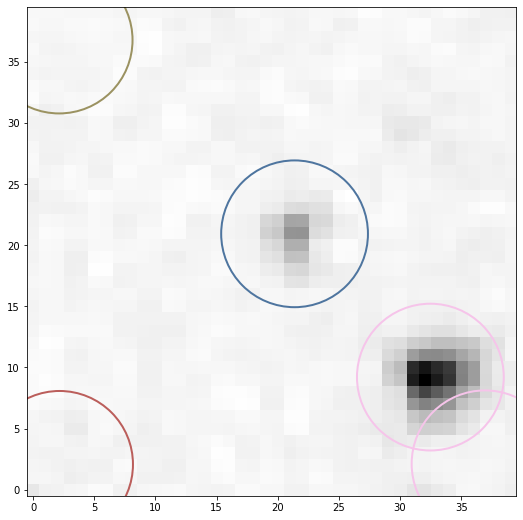

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06030190000001312s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.1675443 2.0699448   184.4273   1 ...  175.77201 52.439042             1
36.953543 2.1164459   1496.432   2 ... -22.075776 241.06647             1
32.483018 9.2054008  12921.934   3 ...  11525.534 240.63851             1
 21.38005 20.920578  2823.2373   4 ...  3011.3496 88.384441             1
2.1323558 36.761989 -255.48996   5 ... -71.165961  37.64319             1


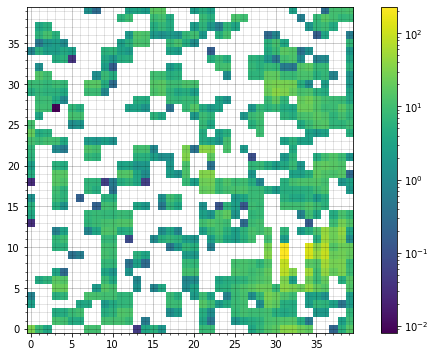

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.1675443 2.0699448    19.433013  0.32525805
  2        2             1 36.953543 2.1164459          nan         nan
  3        2             1 32.483018 9.2054008    14.891235 0.037236659
  4        3             1  21.38005 20.920578    16.348485 0.043453308
  5        4             1 2.1323558 36.761989          nan         nan
first match table:
 id  xcenter   ycenter    mag_e6     err_e6  
--- --------- --------- --------- -----------
  1 2.1675443 2.0699448 19.433013  0.32525805
  2 36.953543 2.1164459       nan         nan
  3 32.483018 9.2054008 14.891235 0.037236659
  4  21.38005 20.920578 16.348485 0.043453308
  5 2.1323558 36.761989       nan         nan
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------

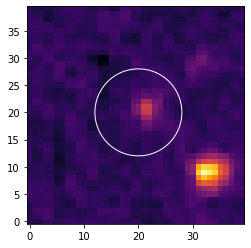

Mean: 170.7752227783203
Median: 168.96597290039062
Std dev: 14.186302185058594
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.80846956394837 ...  2.331359644005222 -0.9190231863314409
  2 32.677430520397394 ... 11.117497081518858 -2.6150175602832215
  3 21.618119501286092 ... 2.8941968290127362  -1.153820158394412
  4  37.03269898531387 ... 2.4336922682809887 -0.9656641559382182
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.80846956394837 ...  2.331359644005222 -0.9190231863314409
  2 32.677430520397394 ... 11.117497081518858 -2.6150175602832215
  3 21.618119501286092 ... 2.8941968290127362  -1.153820158394412
  4  37.03269898531387 ... 2.4336922682809887 -0.9656641559382182
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


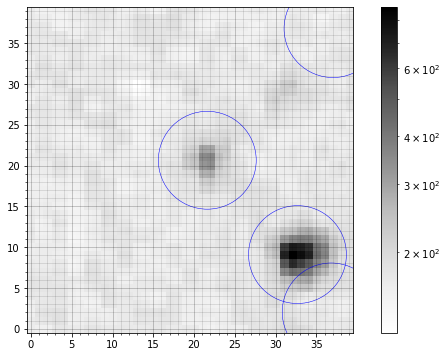

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1  36.80847 2.0598545 0.45012989 ...  168.9321 2.3313596 -0.91902319        1
  2 32.677431 9.0931098 0.47823778 ... 792.06567 11.117497  -2.6150176        1
  3  21.61812 20.660133 0.63574151 ... 352.61057 2.8941968  -1.1538202        2
  4 37.032699 36.805252 0.44761522 ... 169.57181 2.4336923 -0.96566416        3


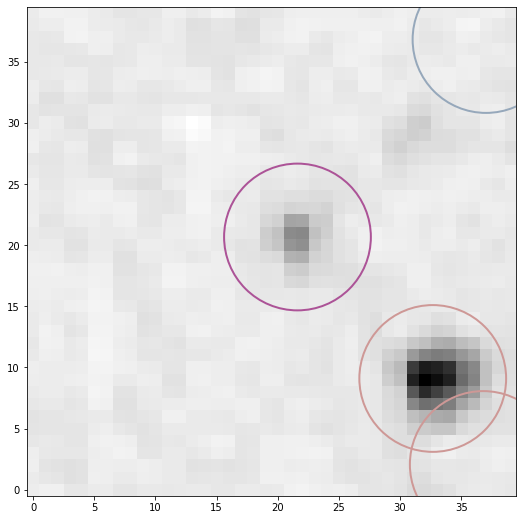

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05982290000008561s
   x_0       y_0      flux_0   id ...  flux_fit   flux_unc iter_detected
--------- --------- --------- --- ... ---------- --------- -------------
 36.80847 2.0598545 1559.4451   1 ... -71.872119 255.66553             1
32.677431 9.0931098 12278.827   2 ...  11043.108 254.15132             1
 21.61812 20.660133 2944.9979   3 ...  2644.8413 54.261979             1
37.032699 36.805252 -129.1982   4 ... -104.88906 44.555682             1


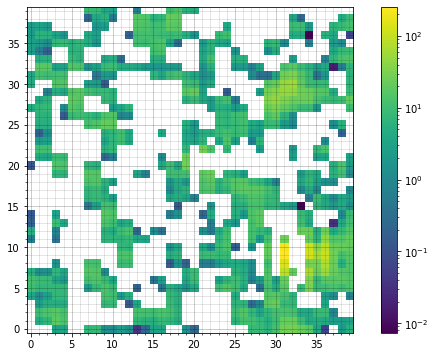

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  36.80847 2.0598545          nan         nan
  2        1             1 32.677431 9.0931098    14.937596 0.038692082
  3        2             1  21.61812 20.660133    16.489326 0.036998327
  4        3             1 37.032699 36.805252          nan         nan
first match table:
 id  xcenter   ycenter    mag_e7     err_e7  
--- --------- --------- --------- -----------
  1  36.80847 2.0598545       nan         nan
  2 32.677431 9.0931098 14.937596 0.038692082
  3  21.61812 20.660133 16.489326 0.036998327
  4 37.032699 36.805252       nan         nan
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.1471372 2.1200511 261.08713 ...          -- 19.433013  0.32525805
        1 36.860496 2.1543853 295.80049

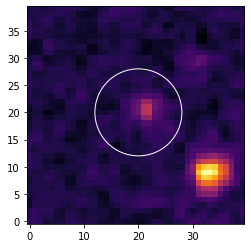

Mean: 163.33978271484375
Median: 161.72674560546875
Std dev: 13.271448135375977
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2.096596514682376 ...  2.692845409998207  -1.075528555723535
  2 32.887206752598594 ... 11.525385237832271  -2.654138626665845
  3  21.51544815268402 ...  2.590581146019709 -1.0334930011280514
  4  36.85829051574147 ... 2.6697449040149333 -1.0661744155168889
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2.096596514682376 ...  2.692845409998207  -1.075528555723535
  2 32.887206752598594 ... 11.525385237832271  -2.654138626665845
  3  21.51544815268402 ...  2.590581146019709 -1.0334930011280514
  4  36.85829051574147 ... 2.6697449040149333 -1.0661744155168889
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


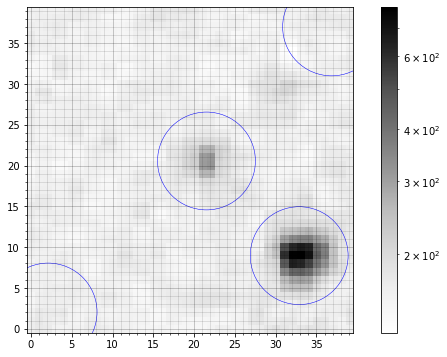

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 2.0965965 2.0504422 0.46700644 ... 175.99542 2.6928454 -1.0755286        1
  2 32.887207 8.9635332 0.50112448 ... 789.96924 11.525385 -2.6541386        2
  3 21.515448 20.572719  0.5717805 ... 307.82016 2.5905811  -1.033493        3
  4 36.858291 37.013219 0.44929901 ... 172.26457 2.6697449 -1.0661744        4


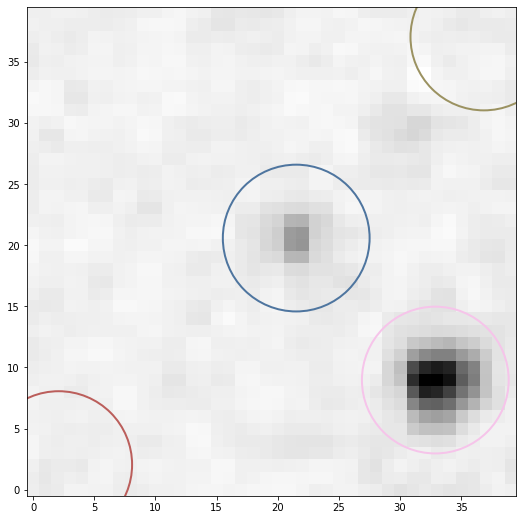

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.1764372000000094s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
2.0965965 2.0504422 118.20479   1 ... 155.64164 31.526144             1
32.887207 8.9635332 12587.255   2 ... 10724.711 276.05642             1
21.515448 20.572719 2652.7596   3 ... 2264.8339 57.831317             1
36.858291 37.013219 -9.422272   4 ... 83.460433   53.8311             1


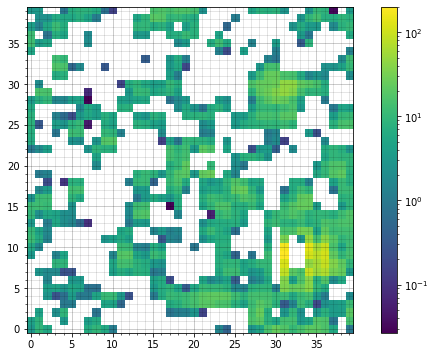

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.0965965 2.0504422    19.565023  0.22189758
  2        2             1 32.887207 8.9635332    14.969373 0.040666133
  3        3             1 21.515448 20.572719    16.657746 0.040512932
  4        4             1 36.858291 37.013219    20.241636  0.70091124
first match table:
 id  xcenter   ycenter    mag_e8     err_e8  
--- --------- --------- --------- -----------
  1 2.0965965 2.0504422 19.565023  0.22189758
  2 32.887207 8.9635332 14.969373 0.040666133
  3 21.515448 20.572719 16.657746 0.040512932
  4 36.858291 37.013219 20.241636  0.70091124
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.1471372 2.1200511 261.08713 ...  0.32525805        --          --
        1 36.860496 2.1543853 295.80049

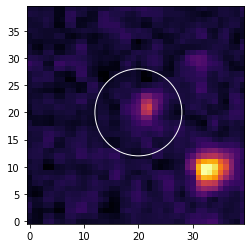

Mean: 166.25485229492188
Median: 164.57327270507812
Std dev: 12.937474250793457
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 36.910766800292514 ...  2.570797572798022  -1.025169703005542
  2  32.83188638719033 ... 11.217741466336609 -2.6247635666669784
  3 21.623586332560514 ... 3.1344270886151047 -1.2403954299099178
  4 36.866140834009585 ...  2.624828247240987  -1.047752227720809
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 36.910766800292514 ...  2.570797572798022  -1.025169703005542
  2  32.83188638719033 ... 11.217741466336609 -2.6247635666669784
  3 21.623586332560514 ... 3.1344270886151047 -1.2403954299099178
  4 36.866140834009585 ...  2.624828247240987  -1.047752227720809
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


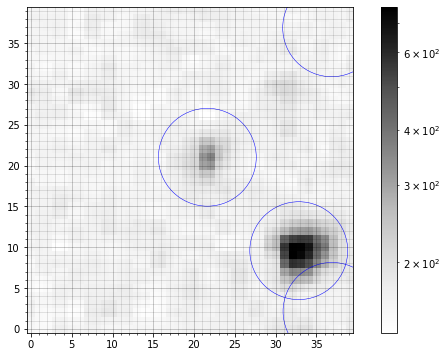

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 36.910767 2.1254314 0.42013736 ... 163.43633 2.5707976 -1.0251697        1
  2 32.831886  9.574407 0.42384722 ... 723.10974 11.217741 -2.6247636        1
  3 21.623586 21.027871 0.73833122 ...  361.5311 3.1344271 -1.2403954        2
  4 36.866141 36.906902 0.39669484 ...   159.459 2.6248282 -1.0477522        3


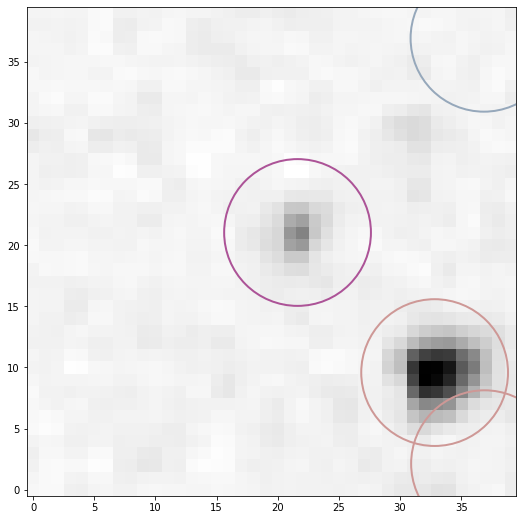

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07226649999995516s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
36.910767 2.1254314   1256.205   1 ... -28.011798 255.04017             1
32.831886  9.574407  12721.227   2 ...  10063.419 234.19952             1
21.623586 21.027871  2576.9423   3 ...   2658.278 58.333715             1
36.866141 36.906902 -69.388184   4 ... -11.063645 37.454425             1


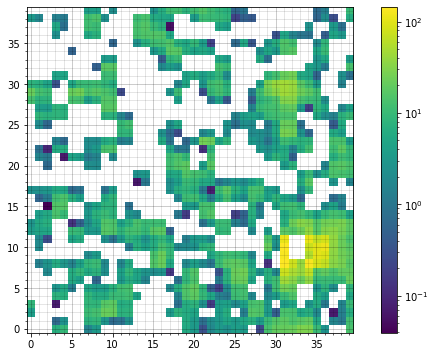

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 36.910767 2.1254314          nan         nan
  2        1             1 32.831886  9.574407    15.038393 0.038873494
  3        2             1 21.623586 21.027871    16.483756 0.037951984
  4        3             1 36.866141 36.906902          nan         nan
first match table:
 id  xcenter   ycenter    mag_e9     err_e9  
--- --------- --------- --------- -----------
  1 36.910767 2.1254314       nan         nan
  2 32.831886  9.574407 15.038393 0.038873494
  3 21.623586 21.027871 16.483756 0.037951984
  4 36.866141 36.906902       nan         nan
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.1471372 2.1200511 261.08713 ...          -- 19.565023  0.22189758
        1 36.860496 2.1543853 295.80049

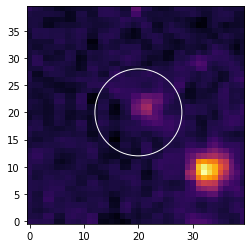

Mean: 164.17095947265625
Median: 162.58457946777344
Std dev: 12.83730411529541
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.2055462177214835 ... 2.5541702098819594 -1.0181245881812468
  2  36.98521807925527 ... 2.6832945390824383 -1.0716708669923611
  3  32.54898094090684 ... 11.264306037844865   -2.62926110306171
  4 21.576697893153916 ... 2.2058492151239677 -0.8589395553037892
  5 2.0177369002373724 ...  2.653363847102254 -1.0594920186178163
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.2055462177214835 ... 2.5541702098819594 -1.0181245881812468
  2  36.98521807925527 ... 2.6832945390824383 -1.0716708669923611
  3  32.54898094090684 ... 11.264306037844865   -2.62926110306171
  4 21.576697893153916 ... 2.2058492151239677 -0.8589395553037892
  5 2.0177369002373724 ...  2.65336

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


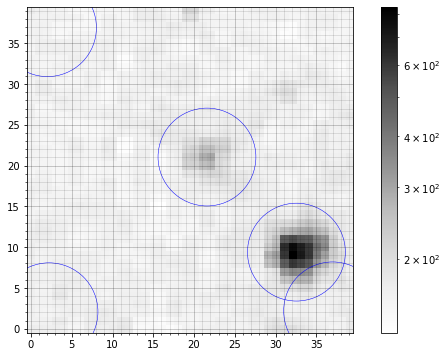

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.2055462 2.0805289 0.42252027 ... 162.66132 2.5541702  -1.0181246        1
  2 36.985218 2.1897832 0.38581606 ... 160.59039 2.6832945  -1.0716709        2
  3 32.548981  9.393467 0.60008713 ... 833.03534 11.264306  -2.6292611        2
  4 21.576698  21.05453 0.57576151 ... 286.78735 2.2058492 -0.85893956        3
  5 2.0177369  36.92088 0.40922264 ... 160.27042 2.6533638   -1.059492        4


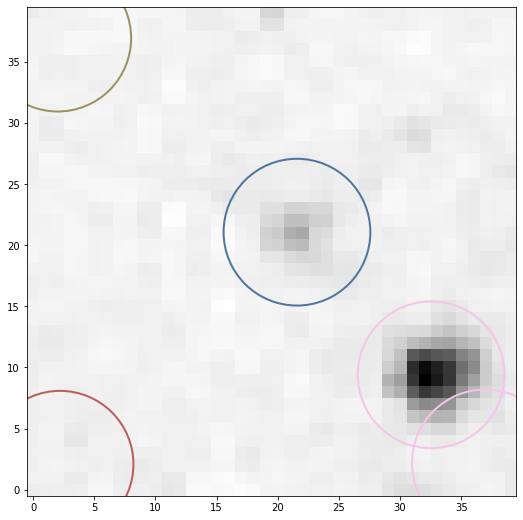

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.061781199999927594s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.2055462 2.0805289  247.56829   1 ...  69.873976 39.921919             1
36.985218 2.1897832  1383.7457   2 ...  62.687358 246.61386             1
32.548981  9.393467  13034.874   3 ...  10418.517 232.75035             1
21.576698  21.05453  2456.6489   4 ...  2105.0338 64.658152             1
2.0177369  36.92088 -229.57277   5 ... -84.892794 41.804836             1


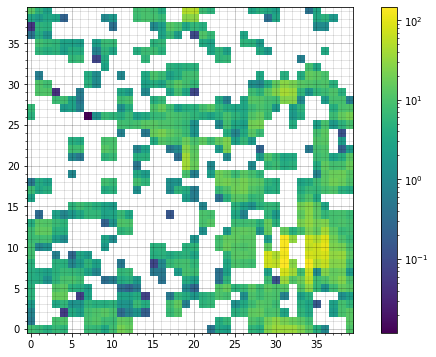

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err  
--- -------- ------------- --------- --------- ------------ ----------
  1        1             1 2.2055462 2.0805289    20.434127 0.62102944
  2        2             1 36.985218 2.1897832    20.551966  4.2714194
  3        2             1 32.548981  9.393467    15.000401 0.03822329
  4        3             1 21.576698  21.05453    16.736768 0.04455199
  5        4             1 2.0177369  36.92088          nan        nan
first match table:
 id  xcenter   ycenter   mag_e10   err_e10  
--- --------- --------- --------- ----------
  1 2.2055462 2.0805289 20.434127 0.62102944
  2 36.985218 2.1897832 20.551966  4.2714194
  3 32.548981  9.393467 15.000401 0.03822329
  4 21.576698  21.05453 16.736768 0.04455199
  5 2.0177369  36.92088       nan        nan
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.1

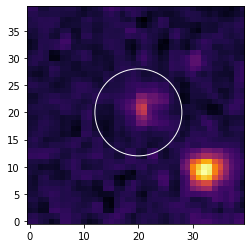

Mean: 163.94479370117188
Median: 162.0930633544922
Std dev: 13.311576843261719
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   2.05083540915102 ...  2.496708469838717 -0.9934195864231019
  2  36.88861435960431 ...  2.693463823570769 -1.0757778670716507
  3  32.16641132817567 ... 11.638792991450403  -2.664769859647891
  4 2.0920987117695997 ...  2.564454050939478 -1.0224873048075995
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   2.05083540915102 ...  2.496708469838717 -0.9934195864231019
  2  36.88861435960431 ...  2.693463823570769 -1.0757778670716507
  3  32.16641132817567 ... 11.638792991450403  -2.664769859647891
  4 2.0920987117695997 ...  2.564454050939478 -1.0224873048075995
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


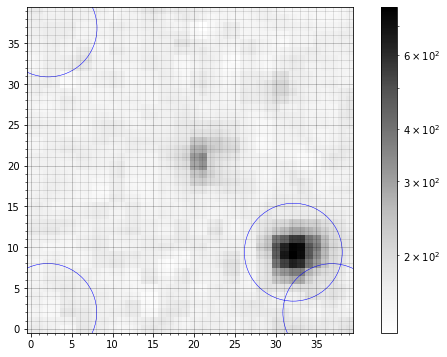

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.0508354  1.996618 0.47633142 ...  168.0415 2.4967085 -0.99341959        1
  2 36.888614  1.978475 0.45517426 ... 177.35179 2.6934638  -1.0757779        2
  3 32.166411 9.3828695 0.47878909 ... 780.05096 11.638793  -2.6647699        2
  4 2.0920987 36.884954 0.43289752 ... 166.78275 2.5644541  -1.0224873        3


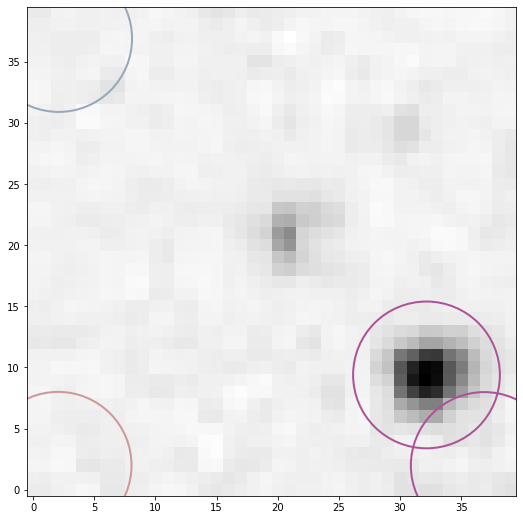

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.08242510000002312s
   x_0       y_0      flux_0   id ...  flux_fit   flux_unc iter_detected
--------- --------- --------- --- ... ---------- --------- -------------
2.0508354  1.996618 139.17648   1 ... -63.968873 50.767239             1
36.888614  1.978475 1201.6332   2 ...  192.56151 209.70631             1
32.166411 9.3828695  12719.81   3 ...  10657.915 199.58366             1
2.0920987 36.884954 93.374139   4 ...  105.71884 46.868803             1


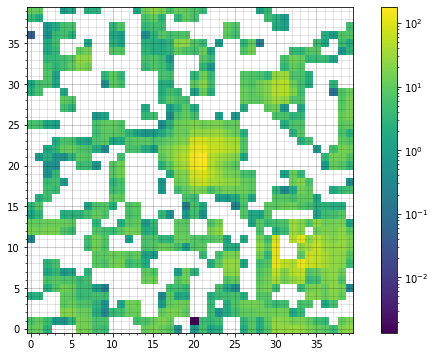

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.0508354  1.996618          nan         nan
  2        2             1 36.888614  1.978475    19.331687   1.1827742
  3        2             1 32.166411 9.3828695    14.973931 0.035861945
  4        3             1 2.0920987 36.884954     19.98273  0.48224993
first match table:
 id  xcenter   ycenter   mag_e11    err_e11  
--- --------- --------- --------- -----------
  1 2.0508354  1.996618       nan         nan
  2 36.888614  1.978475 19.331687   1.1827742
  3 32.166411 9.3828695 14.973931 0.035861945
  4 2.0920987 36.884954  19.98273  0.48224993
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10   err_e10  
--------- --------- --------- --------- ... ----------- --------- ----------
        0 2.1471372 2.1200511 261.08713 ...          -- 20.434127 0.62102944
        1 36.860496 2.1543853 295.80049 ..

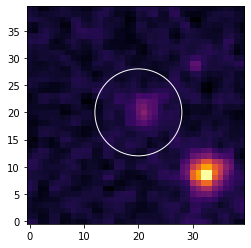

Mean: 164.14935302734375
Median: 162.0628662109375
Std dev: 14.38188648223877
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 2.0587581620119053 ... 2.2092439556608863  -0.8606091886684608
  2  32.35208459850008 ...  11.60610858721224  -2.6617165738097914
  3  21.03535243279264 ... 1.4033667009802229 -0.36792791848948686
  4 2.0888293037860994 ... 2.3220217622458605  -0.9146657141943743
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 2.0587581620119053 ... 2.2092439556608863  -0.8606091886684608
  2  32.35208459850008 ...  11.60610858721224  -2.6617165738097914
  3  21.03535243279264 ... 1.4033667009802229 -0.36792791848948686
  4 2.0888293037860994 ... 2.3220217622458605  -0.9146657141943743
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


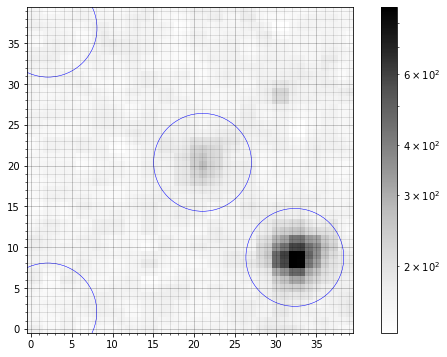

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.0587582 2.0563041 0.43875619 ... 158.12875  2.209244 -0.86060919        1
  2 32.352085 8.7461289 0.56839217 ... 878.38885 11.606109  -2.6617166        2
  3 21.035352 20.403034 0.67815128 ... 270.03516 1.4033667 -0.36792792        3
  4 2.0888293 36.858226 0.43344301 ... 161.55681 2.3220218 -0.91466571        4


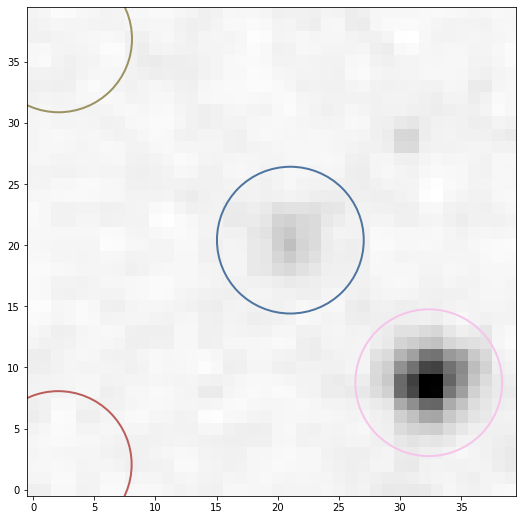

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.049281199999995806s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.0587582 2.0563041  -143.2518   1 ... -166.65849 43.357638             1
32.352085 8.7461289  12945.766   2 ...  11423.583 183.52268             1
21.035352 20.403034  2349.1747   3 ...  1633.9525 64.545743             1
2.0888293 36.858226 -98.698555   4 ... -19.967356 44.329252             1


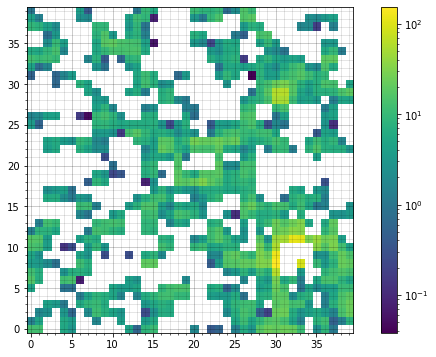

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.0587582 2.0563041          nan         nan
  2        2             1 32.352085 8.7461289    14.902214 0.034306554
  3        3             1 21.035352 20.403034    17.013621 0.052078946
  4        4             1 2.0888293 36.858226          nan         nan
first match table:
 id  xcenter   ycenter   mag_e12    err_e12  
--- --------- --------- --------- -----------
  1 2.0587582 2.0563041       nan         nan
  2 32.352085 8.7461289 14.902214 0.034306554
  3 21.035352 20.403034 17.013621 0.052078946
  4 2.0888293 36.858226       nan         nan
id_master    x_0       y_0      x_true  ...  err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ---------- --------- -----------
        0 2.1471372 2.1200511 261.08713 ... 0.62102944       nan         nan
        1 36.860496 2.1543853 295.80049 ..

<ipython-input-14-502a472d10e5>:342: RuntimeWarning: invalid value encountered in double_scalars
  var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)


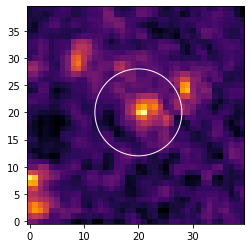

Mean: 174.7282257080078
Median: 171.30841064453125
Std dev: 18.08335304260254
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.8342043841897286 ...  3.339214140632524 -1.3091106771005787
  2 21.126465902157676 ... 1.6100782441976755 -0.5171174543616093
  3 28.567686450754014 ... 1.3565548122386504 -0.3310933658151044
  4    2.2265567863043 ... 1.7680959008375237 -0.6187645432014135
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.8342043841897286 ...  3.339214140632524 -1.3091106771005787
  2 21.126465902157676 ... 1.6100782441976755 -0.5171174543616093
  3 28.567686450754014 ... 1.3565548122386504 -0.3310933658151044
  4    2.2265567863043 ... 1.7680959008375237 -0.6187645432014135
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


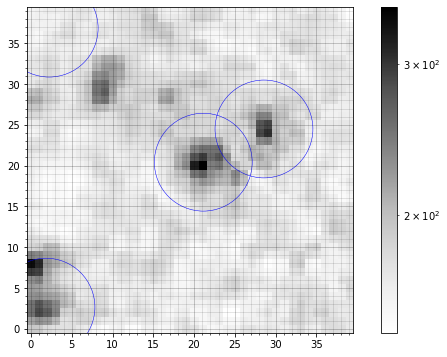

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 1.8342044 2.6456847 0.45775049 ... 285.99759 3.3392141  -1.3091107        1
  2 21.126466 20.423279 0.46794286 ... 296.52316 1.6100782 -0.51711745        2
  3 28.567686   24.4974 0.68728096 ... 289.15167 1.3565548 -0.33109337        2
  4 2.2265568 36.865134 0.43985664 ... 162.11305 1.7680959 -0.61876454        3


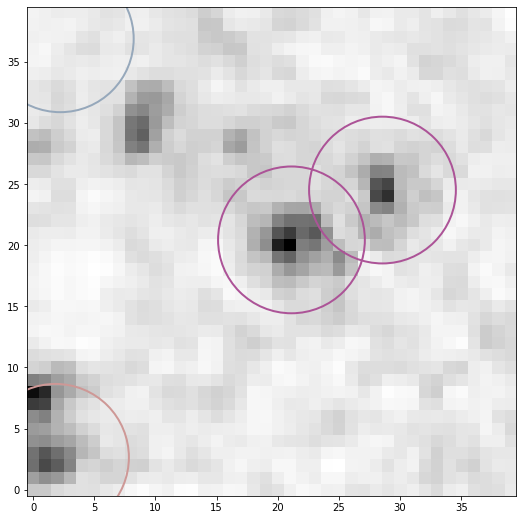

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05111920000001646s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
1.8342044 2.6456847  2647.0923   1 ...  1681.6509 210.38039             1
21.126466 20.423279  3568.8026   2 ...  2414.0237  81.90067             1
28.567686   24.4974  2576.7817   3 ...  1707.8953 79.768579             1
2.2265568 36.865134 -111.42358   4 ... -135.42111 32.637022             1


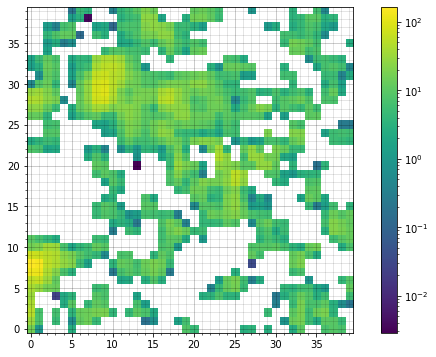

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 1.8342044 2.6456847    16.983326  0.13900473
  2        2             1 21.126466 20.423279    16.590811  0.04721834
  3        2             1 28.567686   24.4974    16.966512 0.058687429
  4        3             1 2.2265568 36.865134          nan         nan
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 1.8342044 2.6456847 16.983326  0.13900473
  2 21.126466 20.423279 16.590811  0.04721834
  3 28.567686   24.4974 16.966512 0.058687429
  4 2.2265568 36.865134       nan         nan
id_master    x_0       y_0      x_true    y_true      RA       dec   
--------- --------- --------- --------- --------- --------- ---------
        0 36.887825 2.1429971 389.09752 316.19432 346.68921 12.769671
        1 1.8834426 2.6072095 354.09313 316.65853 346.68686 12.

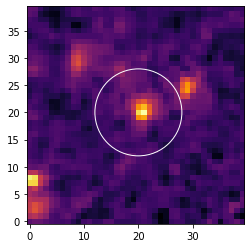

Mean: 174.11766052246094
Median: 170.75399780273438
Std dev: 18.10688591003418
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.768038639335384 ...  2.93929036596255 -1.1706062279463147
  2 28.964017442228013 ... 2.001390774207438 -0.7533297337253673
  3  36.89474052210847 ... 2.096121453974756 -0.8035411075908622
  4  1.841583831113617 ... 2.068198937368323 -0.7889807766325512
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.768038639335384 ...  2.93929036596255 -1.1706062279463147
  2 28.964017442228013 ... 2.001390774207438 -0.7533297337253673
  3  36.89474052210847 ... 2.096121453974756 -0.8035411075908622
  4  1.841583831113617 ... 2.068198937368323 -0.7889807766325512
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


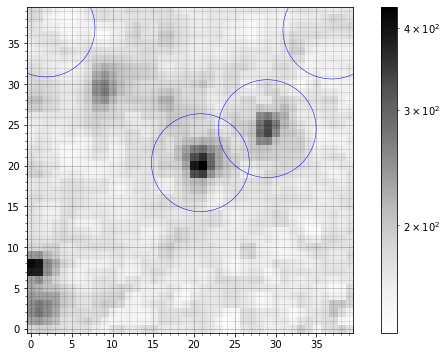

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 20.768039 20.363111 0.75372892 ... 430.77814 2.9392904  -1.1706062        1
  2 28.964017 24.538753 0.65396066 ... 329.21625 2.0013908 -0.75332973        1
  3 36.894741 36.628689 0.34091359 ... 180.14624 2.0961215 -0.80354111        2
  4 1.8415838 36.880214 0.45587341 ... 178.67891 2.0681989 -0.78898078        3


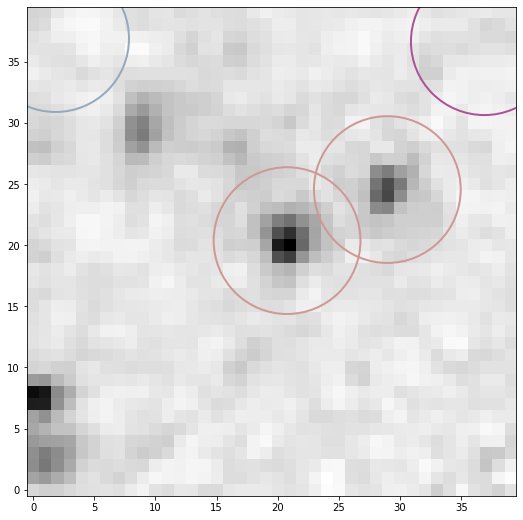

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.0690021999999999s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 20.768039 20.363111  3711.1864   1 ...  3184.4677 62.703508             1
 28.964017 24.538753  2688.6447   2 ...  2127.1526 62.030153             1
 36.894741 36.628689 -9.6362685   3 ...  115.04673 50.910634             1
 1.8415838 36.880214 -205.98591   4 ... -71.306345 59.598668             1
 1.3795762 2.7845583  3056.4885   5 ...  1537.6941 96.029116             2
0.85208128 7.4469302  2943.1237   7 ...  2626.4784 90.824671             2


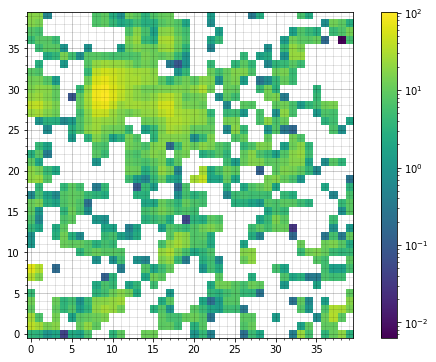

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  20.768039 20.363111     16.28892  0.03646559
  2        1             1  28.964017 24.538753    16.727015 0.043302789
  3        2             1  36.894741 36.628689    19.894326  0.48136879
  4        3             1  1.8415838 36.880214          nan         nan
  5        1             2  1.3795762 2.7845583    17.079337 0.073960254
  7        1             2 0.85208128 7.4469302    16.498077   0.0477738
first match table:
 id  xcenter    ycenter    mag_e2     err_e2  
--- ---------- --------- --------- -----------
  1  20.768039 20.363111  16.28892  0.03646559
  2  28.964017 24.538753 16.727015 0.043302789
  3  36.894741 36.628689 19.894326  0.48136879
  4  1.8415838 36.880214       nan         nan
  5  1.3795762 2.7845583 17.079337 0.073960254
  7 0.85208128 7.4469302 16.498077   0.0477738
id_master    x_0     

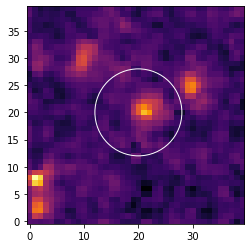

Mean: 173.8255615234375
Median: 170.44940185546875
Std dev: 17.966962814331055
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1550862126112644 ... 3.1938265863267974 -1.2607783294075947
  2 21.330479705652703 ...  1.832761133052662 -0.6577646657374291
  3  29.76200751277012 ...   1.68846419597481 -0.5687296395451986
  4 1.9821566391889818 ... 1.9173161430029815 -0.7067343221554488
  5  36.94749864896435 ...  2.151861435893711  -0.832035756282105
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1550862126112644 ... 3.1938265863267974 -1.2607783294075947
  2 21.330479705652703 ...  1.832761133052662 -0.6577646657374291
  3  29.76200751277012 ...   1.68846419597481 -0.5687296395451986
  4 1.9821566391889818 ... 1.9173161430029815 -0.7067343221554488
  5  36.94749864896435 ...  2.15186

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


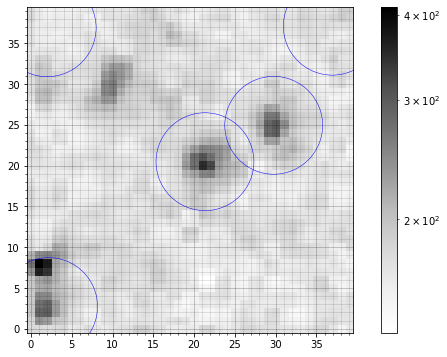

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.1550862 2.7202577 0.43554993 ... 296.04227 3.1938266  -1.2607783        1
  2  21.33048 20.484776 0.78403302 ... 349.74783 1.8327611 -0.65776467        2
  3 29.762008 24.945573 0.52317043 ... 286.68552 1.6884642 -0.56872964        2
  4 1.9821566 36.909369 0.41215185 ... 162.93648 1.9173161 -0.70673432        3
  5 36.947499 37.098727 0.49283289 ... 191.64777 2.1518614 -0.83203576        4


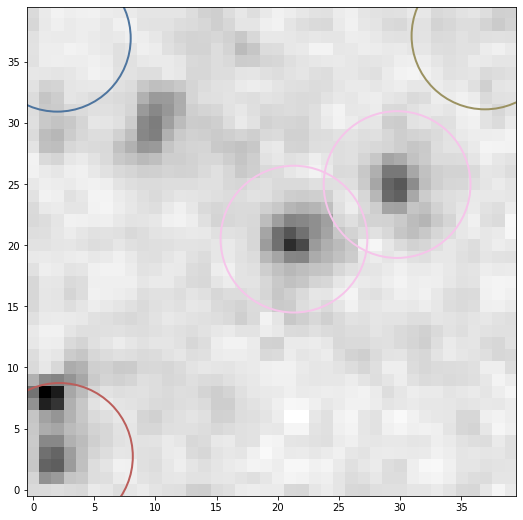

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0633928999999398s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.1550862 2.7202577  2964.4689   1 ...  1855.9651 300.84114             1
 21.33048 20.484776  3059.7299   2 ...  2425.7524 60.286167             1
29.762008 24.945573  2495.9251   3 ...  2037.5174 63.358713             1
1.9821566 36.909369 -144.31949   4 ... -169.55869 49.104813             1
36.947499 37.098727  187.04566   5 ...  141.80419 48.323786             1


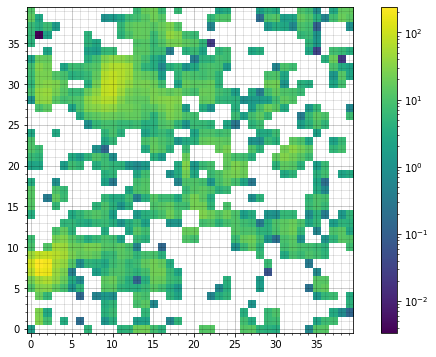

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.1550862 2.7202577    16.875312  0.17845367
  2        2             1  21.33048 20.484776     16.58462 0.040009932
  3        2             1 29.762008 24.945573    16.773983 0.044861715
  4        3             1 1.9821566 36.909369          nan         nan
  5        4             1 36.947499 37.098727    19.667514  0.37117275
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1 2.1550862 2.7202577 16.875312  0.17845367
  2  21.33048 20.484776  16.58462 0.040009932
  3 29.762008 24.945573 16.773983 0.044861715
  4 1.9821566 36.909369       nan         nan
  5 36.947499 37.098727 19.667514  0.37117275
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------

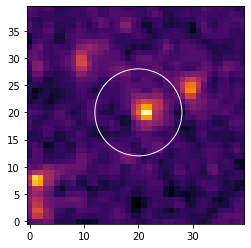

Mean: 173.02102661132812
Median: 169.68775939941406
Std dev: 18.01137351989746
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  36.99719904052479 ... 2.1133447117911537  -0.8124258536324716
  2 21.438717969883776 ... 3.1626023635402345   -1.250111477911239
  3  29.57189840116884 ... 2.0038768573020427  -0.7546775741289703
  4  9.730619822051036 ... 1.1781322756657215 -0.17798513480059147
  5  2.084098260682304 ... 1.9418210700279932   -0.720523022890299
  6 36.835515192049954 ... 1.9426936082363124  -0.7210107782045163
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  36.99719904052479 ... 2.1133447117911537  -0.8124258536324716
  2 21.438717969883776 ... 3.1626023635402345   -1.250111477911239
  3  29.57189840116884 ... 2.0038768573020427  -0.7546775741289703
  4  9.730619822051036

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


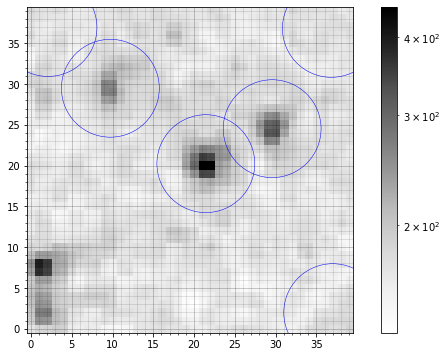

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 36.997199 1.9740071 0.44669301 ... 183.55113 2.1133447 -0.81242585        1
  2 21.438718 20.244844 0.75256359 ... 448.03021 3.1626024  -1.2501115        2
  3 29.571898 24.535401 0.50638151 ... 303.00015 2.0038769 -0.75467757        2
  4 9.7306198 29.489129 0.63087117 ... 265.10181 1.1781323 -0.17798513        3
  5 2.0840983 36.938851 0.43690478 ... 172.19815 1.9418211 -0.72052302        3
  6 36.835515 36.831491 0.44013144 ... 173.48882 1.9426936 -0.72101078        4


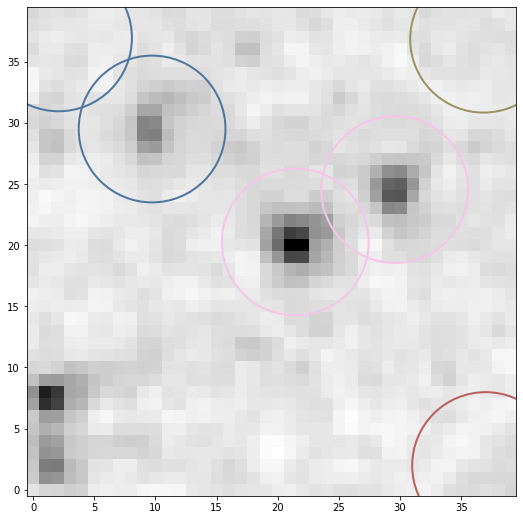

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.17847339999991618s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
36.997199 1.9740071 -198.71416   1 ...  81.137458 64.690713             1
21.438718 20.244844  3722.4327   2 ...  3653.8938 62.210786             1
29.571898 24.535401  2631.0771   3 ...  2118.2256 57.585621             1
9.7306198 29.489129  1894.3636   4 ...  1471.0602 51.182192             1
2.0840983 36.938851 -59.226358   5 ... -33.642238 56.693785             1
36.835515 36.831491  59.892024   6 ...  101.50022 34.715545             1
1.6723466 2.4832906  2695.2457   7 ...  1278.0366 78.006905             2
 1.592036 7.5722433  2982.1409   9 ...   2458.973 78.189958             2


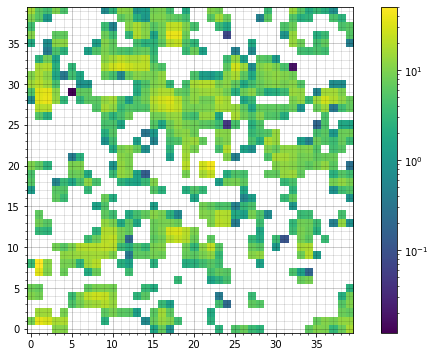

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 36.997199 1.9740071    20.273371  0.86615896
  2        2             1 21.438718 20.244844    16.139534 0.034848427
  3        2             1 29.571898 24.535401    16.731493 0.041760312
  4        3             1 9.7306198 29.489129    17.127348 0.047955185
  5        3             1 2.0840983 36.938851          nan         nan
  6        4             1 36.835515 36.831491    20.030257  0.37252138
  7        1             2 1.6723466 2.4832906    17.280066 0.072555833
  9        1             2  1.592036 7.5722433     16.56954 0.045437909
first match table:
 id  xcenter   ycenter    mag_e4     err_e4  
--- --------- --------- --------- -----------
  1 36.997199 1.9740071 20.273371  0.86615896
  2 21.438718 20.244844 16.139534 0.034848427
  3 29.571898 24.535401 16.731493 0.041760312
  4 9.7306198 29.489129 17.1273

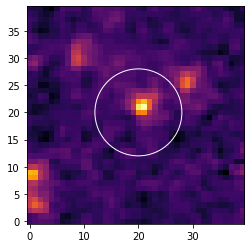

Mean: 173.49928283691406
Median: 169.85025024414062
Std dev: 18.405866622924805
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.020159676464765 ... 1.9765788045617756 -0.7397853349647009
  2 20.783673232934934 ... 3.3112091064761118 -1.2999665194739116
  3 28.872850827574005 ... 1.8355259462616806 -0.6594013197418436
  4  1.938394163721235 ... 1.8745989913159211 -0.6822709475129224
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.020159676464765 ... 1.9765788045617756 -0.7397853349647009
  2 20.783673232934934 ... 3.3112091064761118 -1.2999665194739116
  3 28.872850827574005 ... 1.8355259462616806 -0.6594013197418436
  4  1.938394163721235 ... 1.8745989913159211 -0.6822709475129224
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


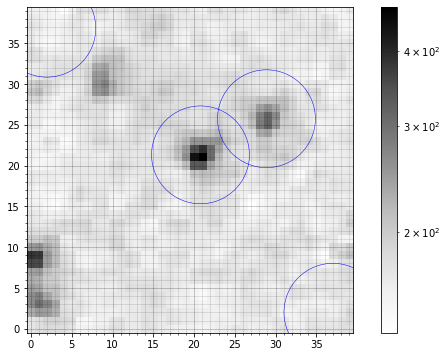

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1  37.02016 2.0196571 0.43856606 ... 176.03842 1.9765788 -0.73978533        1
  2 20.783673 21.324418 0.78914865 ...   473.186 3.3112091  -1.2999665        2
  3 28.872851 25.752873 0.62278798 ... 316.29584 1.8355259 -0.65940132        2
  4 1.9383942 36.855112 0.43079661 ... 162.89468  1.874599 -0.68227095        3


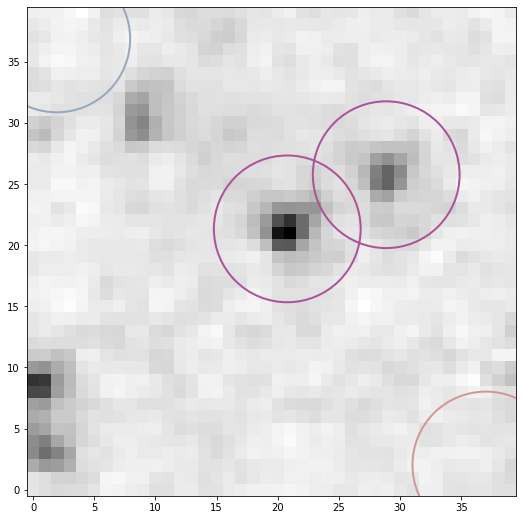

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.07076499999993757s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
  37.02016 2.0196571  70.874976   1 ...  3.0336058 46.889197             1
 20.783673 21.324418  3937.7328   2 ...  3561.0289  64.69614             1
 28.872851 25.752873  2862.5144   3 ...  2081.2773 64.966829             1
 1.9383942 36.855112 -203.32982   4 ... -235.69124 50.600613             1
 1.3267458 3.4889686  3007.9527   5 ...  1664.0868 77.557793             2
0.92157444 8.5255479   3060.429   7 ...   2514.005 76.913013             2


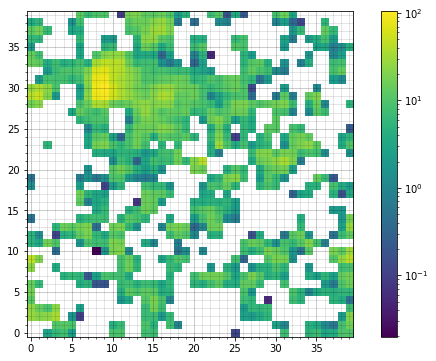

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   37.02016 2.0196571    23.841562   16.781804
  2        2             1  20.783673 21.324418    16.167521 0.035521663
  3        2             1  28.872851 25.752873    16.750635 0.044958907
  4        3             1  1.9383942 36.855112          nan         nan
  5        1             2  1.3267458 3.4889686     16.99352 0.058594616
  7        1             2 0.92157444 8.5255479    16.545545 0.044452801
first match table:
 id  xcenter    ycenter    mag_e5     err_e5  
--- ---------- --------- --------- -----------
  1   37.02016 2.0196571 23.841562   16.781804
  2  20.783673 21.324418 16.167521 0.035521663
  3  28.872851 25.752873 16.750635 0.044958907
  4  1.9383942 36.855112       nan         nan
  5  1.3267458 3.4889686  16.99352 0.058594616
  7 0.92157444 8.5255479 16.545545 0.044452801
id_master    x_0     

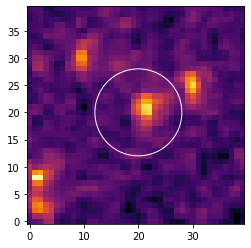

Mean: 172.0385284423828
Median: 168.36676025390625
Std dev: 17.89969253540039
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.60289515562216 ...  1.434805010653986 -0.3919822116455507
  2  2.369357840412901 ...  2.828268447328319 -1.1288015712105879
  3 21.477587555582573 ... 1.9791622859972098 -0.7412035166218743
  4  9.697906873021934 ...  1.237223698292498 -0.2311205751656582
  5 2.0923143434876392 ... 1.9051791801329676 -0.6998395671991717
  6  36.78936737060997 ...  1.842295843591472 -0.6633984307250149
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.60289515562216 ...  1.434805010653986 -0.3919822116455507
  2  2.369357840412901 ...  2.828268447328319 -1.1288015712105879
  3 21.477587555582573 ... 1.9791622859972098 -0.7412035166218743
  4  9.697906873021934 ...  1.237223

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


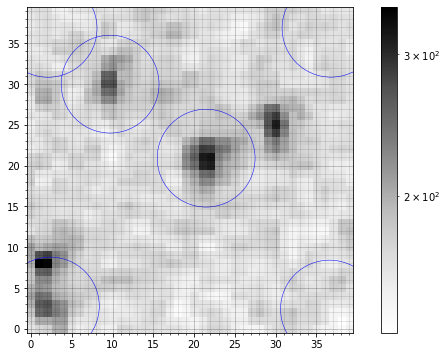

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 36.602895  2.410592 0.36100091 ...  135.2157  1.434805 -0.39198221        1
  2 2.3693578 2.7833195 0.36212407 ... 261.42514 2.8282684  -1.1288016        2
  3 21.477588 20.919071 0.51728047 ... 315.16321 1.9791623 -0.74120352        3
  4 9.6979069 29.996414 0.67166552 ... 271.81943 1.2372237 -0.23112058        4
  5 2.0923143 36.839091 0.43199989 ... 164.99225 1.9051792 -0.69983957        4
  6 36.789367 36.851809 0.43179014 ... 164.62204 1.8422958 -0.66339843        5


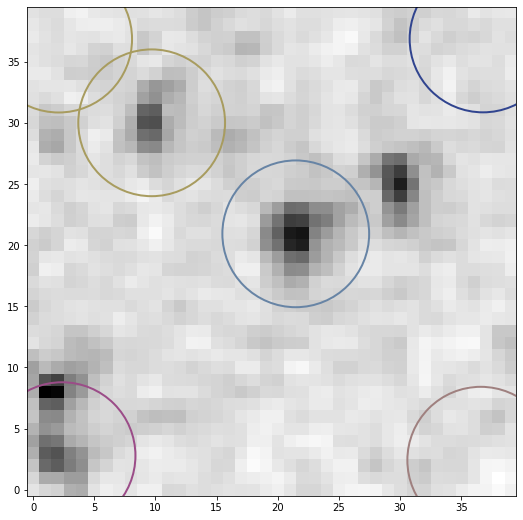

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.13754470000003494s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
36.602895  2.410592 -116.96648   1 ... -177.48674 53.495202             1
2.3693578 2.7833195   2547.101   2 ...  1643.1116 218.35157             1
21.477588 20.919071  3301.6137   3 ...  2730.6866 76.143316             1
9.6979069 29.996414  1937.3902   4 ...  1649.3275 55.870572             1
2.0923143 36.839091  -65.60597   5 ... -81.689294 55.525626             1
36.789367 36.851809  23.632651   6 ...  18.719352 35.803647             1
1.7696734 8.2106378  2026.6999   7 ...  2076.4182  73.70944             2


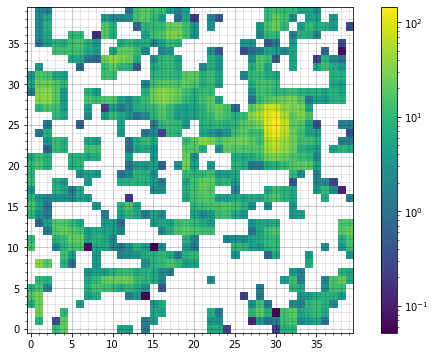

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 36.602895  2.410592          nan         nan
  2        2             1 2.3693578 2.7833195    17.007532  0.14727569
  3        3             1 21.477588 20.919071     16.45602 0.042299771
  4        4             1 9.6979069 29.996414    17.003432 0.047174075
  5        4             1 2.0923143 36.839091          nan         nan
  6        5             1 36.789367 36.851809    21.865972    2.076848
  7        1             2 1.7696734 8.2106378    16.753412 0.048560984
first match table:
 id  xcenter   ycenter    mag_e6     err_e6  
--- --------- --------- --------- -----------
  1 36.602895  2.410592       nan         nan
  2 2.3693578 2.7833195 17.007532  0.14727569
  3 21.477588 20.919071  16.45602 0.042299771
  4 9.6979069 29.996414 17.003432 0.047174075
  5 2.0923143 36.839091       nan         nan
  6 36.7893

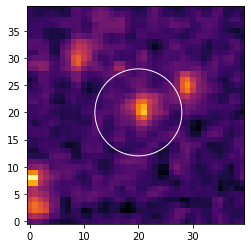

Mean: 177.01226806640625
Median: 173.69198608398438
Std dev: 18.09674835205078
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.78305124864351 ... 1.7951467880927816 -0.6352499159240949
  2 1.8399333150614652 ...  3.388828466224271 -1.3251239663117773
  3 20.773409831489804 ... 1.8072210037706482 -0.6425281634293444
  4 28.900024956248643 ...   1.68304755101048 -0.5652409655927535
  5  36.84289412378968 ...  1.871759636316179 -0.6806251941731842
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.78305124864351 ... 1.7951467880927816 -0.6352499159240949
  2 1.8399333150614652 ...  3.388828466224271 -1.3251239663117773
  3 20.773409831489804 ... 1.8072210037706482 -0.6425281634293444
  4 28.900024956248643 ...   1.68304755101048 -0.5652409655927535
  5  36.84289412378968 ...  1.87175

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


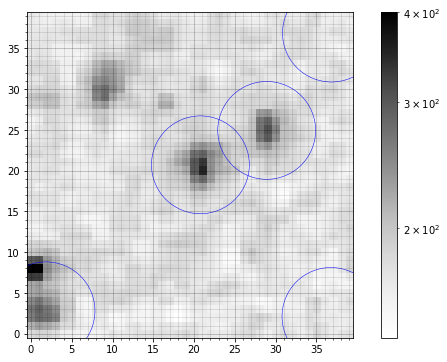

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 36.783051 2.1173874 0.40453573 ... 161.86931 1.7951468 -0.63524992        1
  2 1.8399333 2.8085008 0.41741516 ... 281.11768 3.3888285   -1.325124        2
  3  20.77341 20.715034 0.63569756 ... 332.30475  1.807221 -0.64252816        3
  4 28.900025 24.934354  0.6252442 ... 308.63489 1.6830476 -0.56524097        3
  5 36.842894 36.869565 0.43898499 ...  168.4384 1.8717596 -0.68062519        4


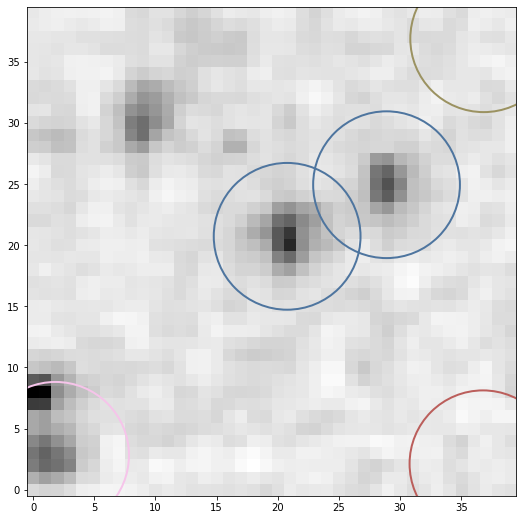

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06709350000005543s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 36.783051 2.1173874 -335.68034   1 ... -111.79378 52.698773             1
 1.8399333 2.8085008  2824.7626   2 ...  1864.5202 286.43736             1
  20.77341 20.715034  3170.8295   3 ...  2401.2798 58.324912             1
 28.900025 24.934354  2471.8458   4 ...  1999.3902 61.206084             1
 36.842894 36.869565 -63.017859   5 ... -105.15764 43.096459             1
0.85759229 7.9378101  1917.8115   6 ...  2667.0067 92.067679             2


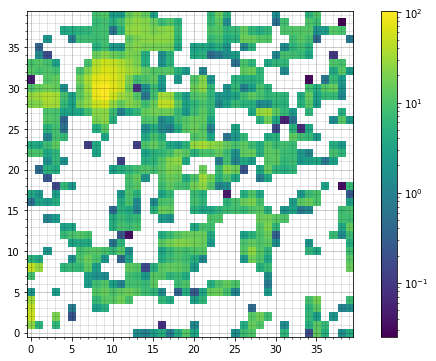

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  36.783051 2.1173874          nan         nan
  2        2             1  1.8399333 2.8085008    16.871833  0.16939233
  3        3             1   20.77341 20.715034    16.597143 0.039599915
  4        3             1  28.900025 24.934354    16.796006 0.044467858
  5        4             1  36.842894 36.869565          nan         nan
  6        1             2 0.85759229 7.9378101     16.48319 0.047723114
first match table:
 id  xcenter    ycenter    mag_e7     err_e7  
--- ---------- --------- --------- -----------
  1  36.783051 2.1173874       nan         nan
  2  1.8399333 2.8085008 16.871833  0.16939233
  3   20.77341 20.715034 16.597143 0.039599915
  4  28.900025 24.934354 16.796006 0.044467858
  5  36.842894 36.869565       nan         nan
  6 0.85759229 7.9378101  16.48319 0.047723114
id_master    x_0     

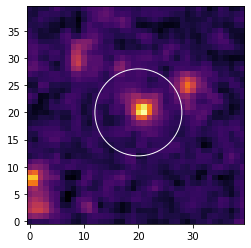

Mean: 170.35362243652344
Median: 166.89590454101562
Std dev: 17.89653205871582
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  37.02137740309027 ... 1.8985829164386103 -0.6960739218688973
  2 1.9533903300879005 ... 3.0948606146753725 -1.2266027354578015
  3 20.778913947887183 ...  3.469868483354026 -1.3507825356543828
  4  28.97545116272663 ... 1.8472374643909206 -0.6663068201458634
  5  36.91292393640273 ... 1.8997027126204384 -0.6967141071580096
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  37.02137740309027 ... 1.8985829164386103 -0.6960739218688973
  2 1.9533903300879005 ... 3.0948606146753725 -1.2266027354578015
  3 20.778913947887183 ...  3.469868483354026 -1.3507825356543828
  4  28.97545116272663 ... 1.8472374643909206 -0.6663068201458634
  5  36.91292393640273 ... 1.899702

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


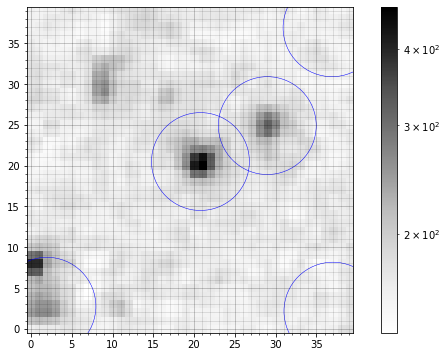

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 37.021377 2.1563011 0.42048384 ... 165.37541 1.8985829 -0.69607392        1
  2 1.9533903 2.7560121 0.43229839 ... 264.82904 3.0948606  -1.2266027        2
  3 20.778914 20.503928 0.74964491 ... 468.23309 3.4698685  -1.3507825        3
  4 28.975451 24.911334 0.67045177 ... 318.61212 1.8472375 -0.66630682        3
  5 36.912924 36.910292 0.43629983 ... 164.94389 1.8997027 -0.69671411        4


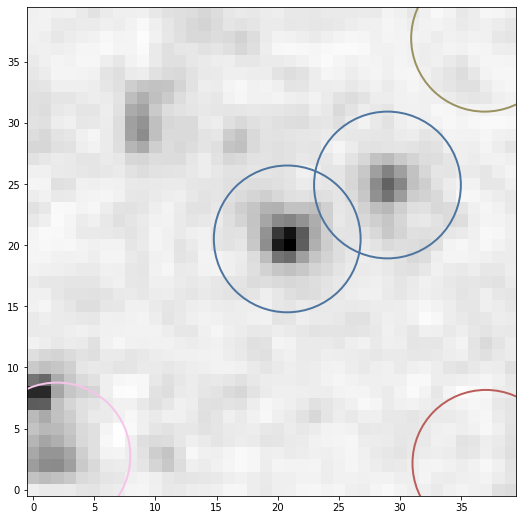

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.07032679999997526s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 37.021377 2.1563011 -113.60006   1 ... -48.509831 43.827709             1
 1.9533903 2.7560121   2739.653   2 ...  1678.8344 288.35028             1
 20.778914 20.503928  4126.0053   3 ...  3615.0702 56.725419             1
 28.975451 24.911334  2522.8141   4 ...  2083.9665  61.10201             1
 36.912924 36.910292 -209.75392   5 ... -129.88643 45.014255             1
0.85612059  7.957792   1988.937   6 ...  2770.3249 83.642149             2


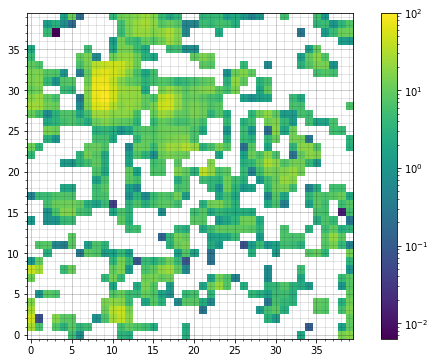

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  37.021377 2.1563011          nan         nan
  2        2             1  1.9533903 2.7560121    16.983927  0.18880736
  3        3             1  20.778914 20.503928    16.151155 0.034101958
  4        3             1  28.975451 24.911334     16.74922 0.043429118
  5        4             1  36.912924 36.910292          nan         nan
  6        1             2 0.85612059  7.957792     16.44012 0.044127903
first match table:
 id  xcenter    ycenter    mag_e8     err_e8  
--- ---------- --------- --------- -----------
  1  37.021377 2.1563011       nan         nan
  2  1.9533903 2.7560121 16.983927  0.18880736
  3  20.778914 20.503928 16.151155 0.034101958
  4  28.975451 24.911334  16.74922 0.043429118
  5  36.912924 36.910292       nan         nan
  6 0.85612059  7.957792  16.44012 0.044127903
id_master    x_0     

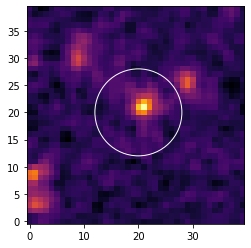

Mean: 172.11483764648438
Median: 168.21240234375
Std dev: 17.349124908447266
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   36.8050883916604 ...  1.915270784817756  -0.705575460172121
  2 20.946790561792586 ...  3.379104321558157 -1.3220039993970543
  3 28.855277339942766 ... 1.7231439381170515 -0.5908038914132132
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   36.8050883916604 ...  1.915270784817756  -0.705575460172121
  2 20.946790561792586 ...  3.379104321558157 -1.3220039993970543
  3 28.855277339942766 ... 1.7231439381170515 -0.5908038914132132
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


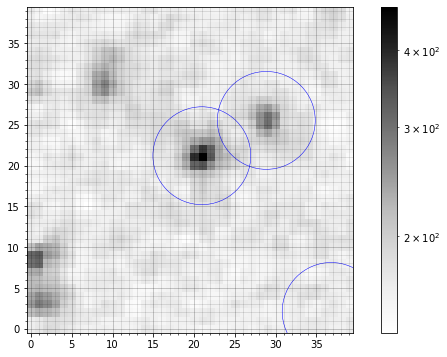

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 36.805088 2.1183995 0.41457023 ... 162.73877 1.9152708 -0.70557546        1
  2 20.946791 21.218556 0.81223973 ...  470.3457 3.3791043   -1.322004        2
  3 28.855277 25.547591 0.63818529 ... 298.81937 1.7231439 -0.59080389        2


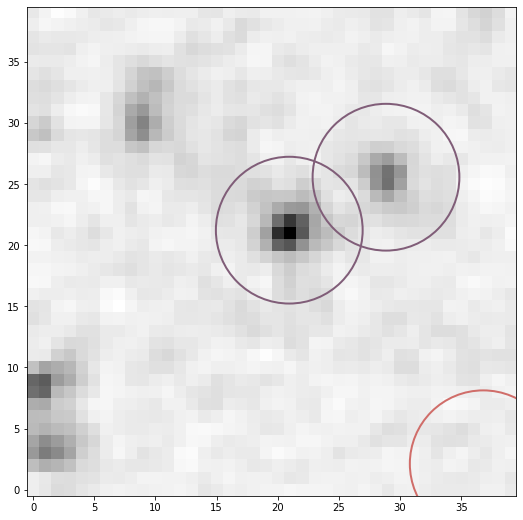

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.16260109999996075s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
36.805088 2.1183995 40.473953   1 ... 37.856555 38.923075             1
20.946791 21.218556 4080.3763   2 ... 3591.7613 68.182852             1
28.855277 25.547591 2448.6681   3 ... 1776.5818 64.429894             1
1.6031138 3.6402425 2785.9138   4 ... 1760.1996 217.87977             2


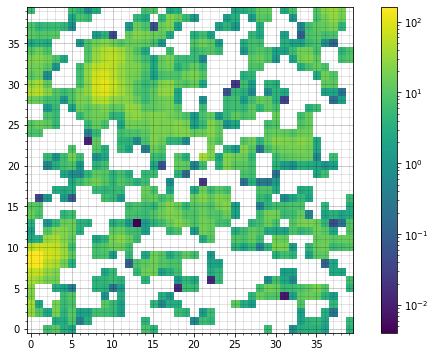

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 36.805088 2.1183995    21.100996   1.1167151
  2        2             1 20.946791 21.218556     16.15808 0.036020746
  3        2             1 28.855277 25.547591    16.922386 0.049225277
  4        1             2 1.6031138 3.6402425    16.932444  0.13760231
first match table:
 id  xcenter   ycenter    mag_e9     err_e9  
--- --------- --------- --------- -----------
  1 36.805088 2.1183995 21.100996   1.1167151
  2 20.946791 21.218556  16.15808 0.036020746
  3 28.855277 25.547591 16.922386 0.049225277
  4 1.6031138 3.6402425 16.932444  0.13760231
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.887825 2.1429971 389.09752 ...         nan       nan         nan
        1 1.8834426 2.6072095 354.09313

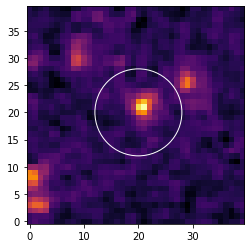

Mean: 170.27786254882812
Median: 167.14938354492188
Std dev: 16.309215545654297
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   37.0024038105237 ... 1.9384049365811515 -0.7186112678969112
  2  20.81530674838409 ... 3.6186022866426515 -1.3963521332277775
  3 28.912770314561545 ...   1.89531336701517 -0.6942025638791867
  4  8.894120129472547 ...   1.43256022944935 -0.3902822254076861
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   37.0024038105237 ... 1.9384049365811515 -0.7186112678969112
  2  20.81530674838409 ... 3.6186022866426515 -1.3963521332277775
  3 28.912770314561545 ...   1.89531336701517 -0.6942025638791867
  4  8.894120129472547 ...   1.43256022944935 -0.3902822254076861
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


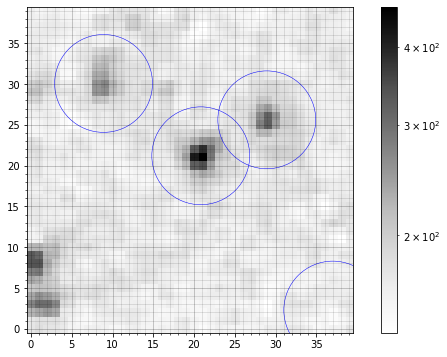

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 37.002404 2.2894412 0.37811575 ... 150.50978 1.9384049 -0.71861127        1
  2 20.815307  21.20981 0.79469149 ... 463.44028 3.6186023  -1.3963521        2
  3  28.91277 25.620469 0.72866064 ... 315.90155 1.8953134 -0.69420256        2
  4 8.8941201 30.081277 0.63857704 ... 272.58331 1.4325602 -0.39028223        3


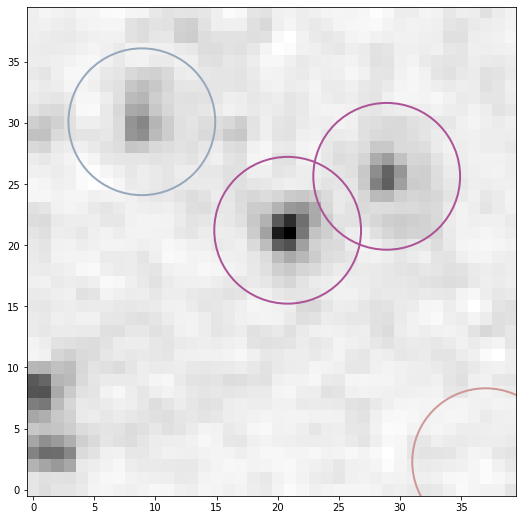

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06256170000006023s
   x_0       y_0      flux_0    id ...  flux_fit  flux_unc iter_detected
--------- --------- ---------- --- ... --------- --------- -------------
37.002404 2.2894412 -211.77116   1 ... -171.2453 40.593421             1
20.815307  21.20981  3532.1767   2 ... 3519.0581 60.051672             1
 28.91277 25.620469  2627.2221   3 ... 1885.5209 57.399942             1
8.8941201 30.081277  1705.3595   4 ... 1580.3143 67.012225             1
1.5346858 3.3105586  2796.6639   5 ... 1967.7066 222.75403             2


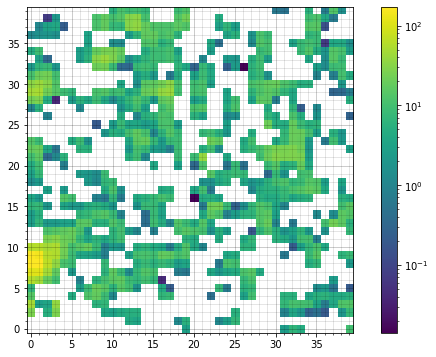

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 37.002404 2.2894412          nan         nan
  2        2             1 20.815307  21.20981     16.18026 0.034870799
  3        2             1  28.91277 25.620469    16.857748 0.044330159
  4        3             1 8.8941201 30.081277    17.049467 0.054702579
  5        1             2 1.5346858 3.3105586    16.811425  0.12641094
first match table:
 id  xcenter   ycenter   mag_e10    err_e10  
--- --------- --------- --------- -----------
  1 37.002404 2.2894412       nan         nan
  2 20.815307  21.20981  16.18026 0.034870799
  3  28.91277 25.620469 16.857748 0.044330159
  4 8.8941201 30.081277 17.049467 0.054702579
  5 1.5346858 3.3105586 16.811425  0.12641094
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------

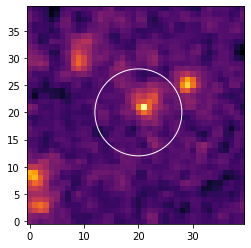

Mean: 171.47959899902344
Median: 168.04742431640625
Std dev: 18.213245391845703
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  28.94743492237561 ... 2.0385452058854687  -0.773300866547854
  2 1.8593777294789415 ...  1.997317768749203 -0.7511179140990885
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  28.94743492237561 ... 2.0385452058854687  -0.773300866547854
  2 1.8593777294789415 ...  1.997317768749203 -0.7511179140990885
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


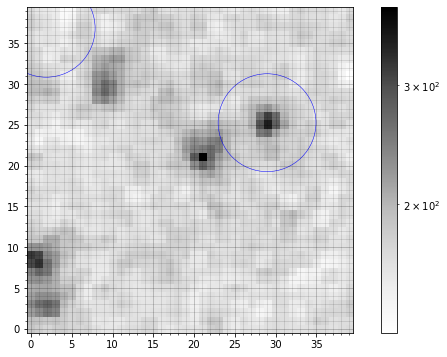

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 28.947435 25.268824 0.78695443 ... 348.95422 2.0385452 -0.77330087        1
  2 1.8593777 36.846257 0.41885843 ... 165.98424 1.9973178 -0.75111791        2


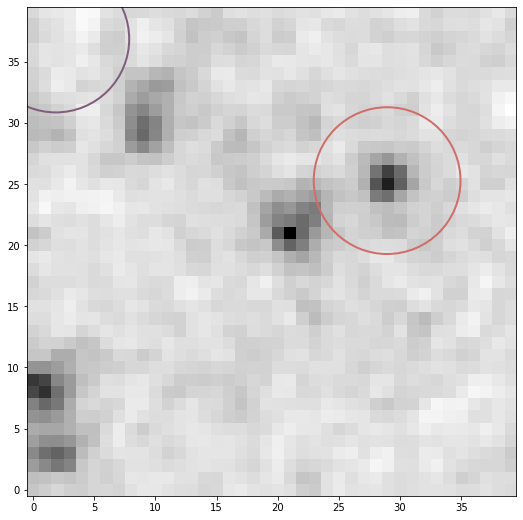

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.061039700000037556s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
28.947435 25.268824  2431.3364   1 ...  2106.1905 63.574407             1
1.8593777 36.846257 -149.94539   2 ... -158.11371 63.988636             1
1.7781856 3.2503677   2793.132   3 ...  1418.4473  74.30741             2
1.1346927 8.1563562  3064.1331   5 ...  2338.9169  79.20724             2


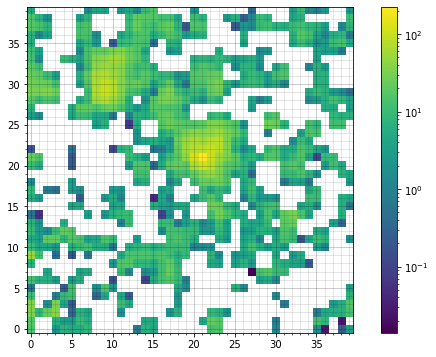

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 28.947435 25.268824    16.738711 0.044121747
  2        2             1 1.8593777 36.846257          nan         nan
  3        1             2 1.7781856 3.2503677    17.167922 0.064092008
  5        1             2 1.1346927 8.1563562    16.624918 0.047165749
first match table:
 id  xcenter   ycenter   mag_e11    err_e11  
--- --------- --------- --------- -----------
  1 28.947435 25.268824 16.738711 0.044121747
  2 1.8593777 36.846257       nan         nan
  3 1.7781856 3.2503677 17.167922 0.064092008
  5 1.1346927 8.1563562 16.624918 0.047165749
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.887825 2.1429971 389.09752 ...   1.1167151       nan         nan
        1 1.8834426 2.6072095 354.09313

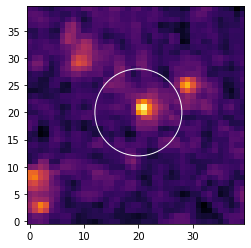

Mean: 169.18197631835938
Median: 165.52369689941406
Std dev: 17.168859481811523
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.030522321827476 ...   2.10379820506489 -0.8075102005985382
  2 2.2078338944954727 ... 3.1284322393573434 -1.2383168819086752
  3 21.135722782734447 ... 3.1333958660005465   -1.24003816527561
  4   29.0124956279173 ... 2.1026683749112753  -0.806926956914471
  5 2.0379640976574844 ...  2.200618137135318 -0.8563617200556328
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.030522321827476 ...   2.10379820506489 -0.8075102005985382
  2 2.2078338944954727 ... 3.1284322393573434 -1.2383168819086752
  3 21.135722782734447 ... 3.1333958660005465   -1.24003816527561
  4   29.0124956279173 ... 2.1026683749112753  -0.806926956914471
  5 2.0379640976574844 ...  2.2006

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


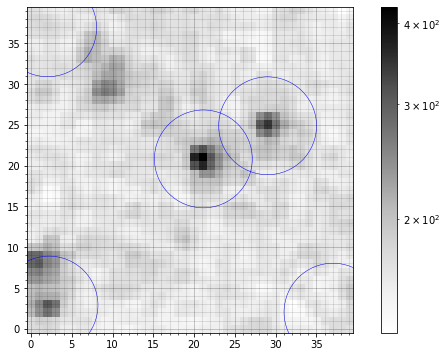

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 37.030522 2.0334001 0.44610077 ... 173.87039 2.1037982  -0.8075102        1
  2 2.2078339 2.9021977 0.42106666 ... 276.28519 3.1284322  -1.2383169        2
  3 21.135723 20.827323 0.76823145 ... 424.57367 3.1333959  -1.2400382        3
  4 29.012496 24.889194 0.81417118 ... 346.70676 2.1026684 -0.80692696        3
  5 2.0379641 36.908362 0.44539702 ...   178.933 2.2006181 -0.85636172        4


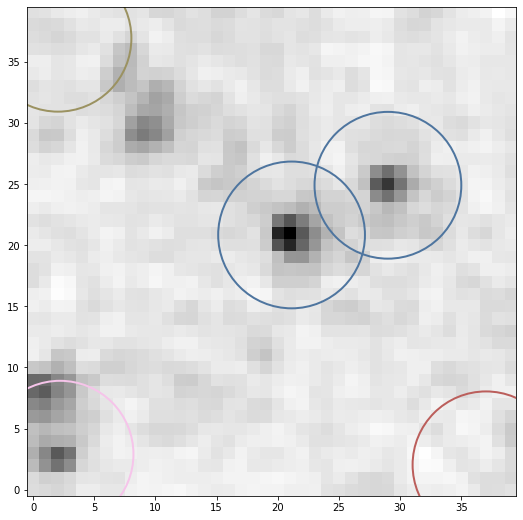

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.07509390000006988s
   x_0       y_0      flux_0    id ...  flux_fit  flux_unc iter_detected
--------- --------- ---------- --- ... --------- --------- -------------
37.030522 2.0334001 -134.15723   1 ... 31.769225 70.569797             1
2.2078339 2.9021977  2592.3251   2 ... 1843.4396 219.47783             1
21.135723 20.827323  3515.7785   3 ... 3221.2763 68.397599             1
29.012496 24.889194  2681.4767   4 ... 2146.5336 68.107639             1
2.0379641 36.908362  444.20869   5 ... 223.71024 83.333948             1
1.2979879 8.0509884  1889.0359   6 ... 2240.9931 91.367596             2


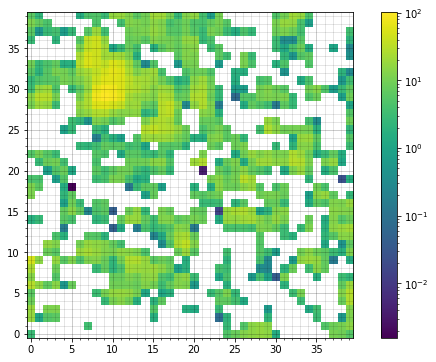

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 37.030522 2.0334001    21.291438   2.4119547
  2        2             1 2.2078339 2.9021977    16.882383  0.13259913
  3        3             1 21.135723 20.827323    16.276385 0.037472114
  4        3             1 29.012496 24.889194    16.717111 0.045381275
  5        4             1 2.0379641 36.908362     19.17224  0.40552332
  6        1             2 1.2979879 8.0509884    16.670354 0.053218654
first match table:
 id  xcenter   ycenter   mag_e12    err_e12  
--- --------- --------- --------- -----------
  1 37.030522 2.0334001 21.291438   2.4119547
  2 2.2078339 2.9021977 16.882383  0.13259913
  3 21.135723 20.827323 16.276385 0.037472114
  4 29.012496 24.889194 16.717111 0.045381275
  5 2.0379641 36.908362  19.17224  0.40552332
  6 1.2979879 8.0509884 16.670354 0.053218654
id_master    x_0       y_0      x_tru

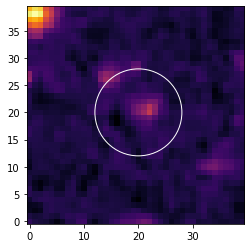

Mean: 171.5151824951172
Median: 169.27340698242188
Std dev: 15.631945610046387
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.2469926963910782 ...  2.013269892564384 -0.7597549973240659
  2  21.67414319320453 ...   2.11953903139032 -0.8156035463174036
  3 14.525024190699332 ... 1.7152914950092017 -0.5858448356068856
  4 1.4629570546148023 ...  13.37384469476849  -2.815640689002705
  5 37.092806814285574 ... 2.2699894635759903 -0.8900596034217647
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.2469926963910782 ...  2.013269892564384 -0.7597549973240659
  2  21.67414319320453 ...   2.11953903139032 -0.8156035463174036
  3 14.525024190699332 ... 1.7152914950092017 -0.5858448356068856
  4 1.4629570546148023 ...  13.37384469476849  -2.815640689002705
  5 37.092806814285574 ... 2.269989

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


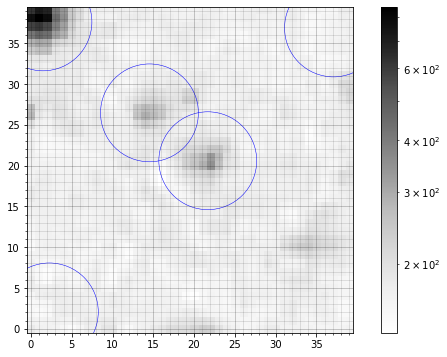

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.2469927 2.0625867 0.43942081 ... 161.56479 2.0132699   -0.759755        1
  2 21.674143 20.604036 0.68971211 ... 328.52145  2.119539 -0.81560355        2
  3 14.525024 26.473238 0.68584245 ... 292.50858 1.7152915 -0.58584484        2
  4 1.4629571 37.631137 0.56344429 ... 846.82825 13.373845  -2.8156407        3
  5 37.092807 36.886601 0.44729796 ... 171.16745 2.2699895  -0.8900596        4


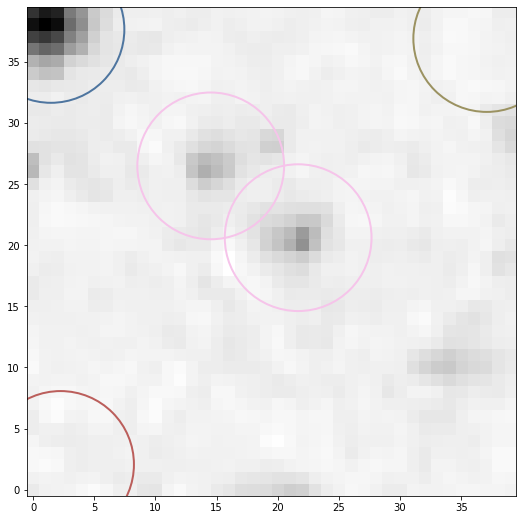

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.059239600000069004s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.2469927 2.0625867 -271.25197   1 ... -150.54555 62.928877             1
21.674143 20.604036  2245.2357   2 ...  2095.9556 69.365402             1
14.525024 26.473238  2044.8135   3 ...  1632.5636 69.842759             1
1.4629571 37.631137   8381.797   4 ...  9360.0094 431.77245             1
37.092807 36.886601 -403.41832   5 ... -203.55835 55.485094             1


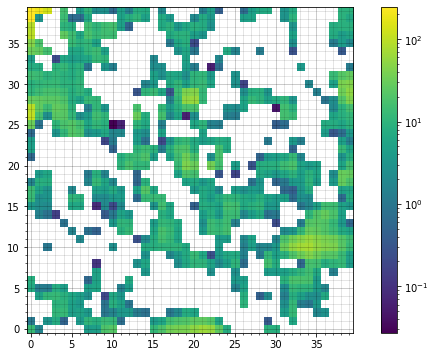

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.2469927 2.0625867          nan         nan
  2        2             1 21.674143 20.604036    16.740057 0.046516939
  3        2             1 14.525024 26.473238    17.011337 0.055047222
  4        3             1 1.4629571 37.631137    15.115321 0.058147635
  5        4             1 37.092807 36.886601          nan         nan
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 2.2469927 2.0625867       nan         nan
  2 21.674143 20.604036 16.740057 0.046516939
  3 14.525024 26.473238 17.011337 0.055047222
  4 1.4629571 37.631137 15.115321 0.058147635
  5 37.092807 36.886601       nan         nan
id_master    x_0       y_0      x_true    y_true      RA       dec   
--------- --------- --------- --------- --------- --------- ---------
        0 2.094

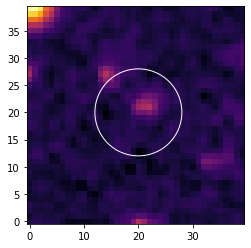

Mean: 171.07135009765625
Median: 168.6276092529297
Std dev: 14.36460018157959
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2.122068239767886 ... 2.4232038680171617 -0.9609748839099355
  2  36.91156690677138 ... 2.4409016623263797 -0.9688757078943716
  3  21.41226504079926 ... 2.3455468192220725  -0.925610265694466
  4 14.345871997064583 ...  2.147007749042683 -0.8295840297683161
  5   1.41081218450019 ... 13.212622787905346 -2.8024725908288106
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2.122068239767886 ... 2.4232038680171617 -0.9609748839099355
  2  36.91156690677138 ... 2.4409016623263797 -0.9688757078943716
  3  21.41226504079926 ... 2.3455468192220725  -0.925610265694466
  4 14.345871997064583 ...  2.147007749042683 -0.8295840297683161
  5   1.41081218450019 ... 13.212622

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


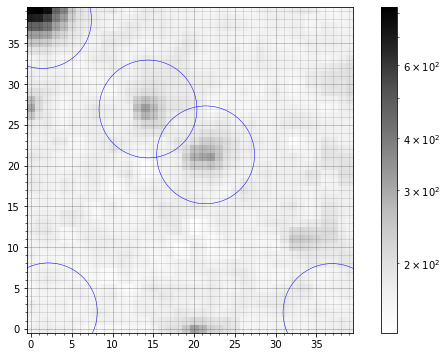

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.1220682 2.0682754 0.42511409 ... 167.61548 2.4232039 -0.96097488        1
  2 36.911567 1.9857485  0.4742648 ... 176.69026 2.4409017 -0.96887571        2
  3 21.412265  21.32374 0.55365789 ... 304.80142 2.3455468 -0.92561027        3
  4 14.345872 26.948919 0.77689919 ... 318.75229 2.1470077 -0.82958403        3
  5 1.4108122 37.924454 0.46226841 ... 672.11523 13.212623  -2.8024726        4


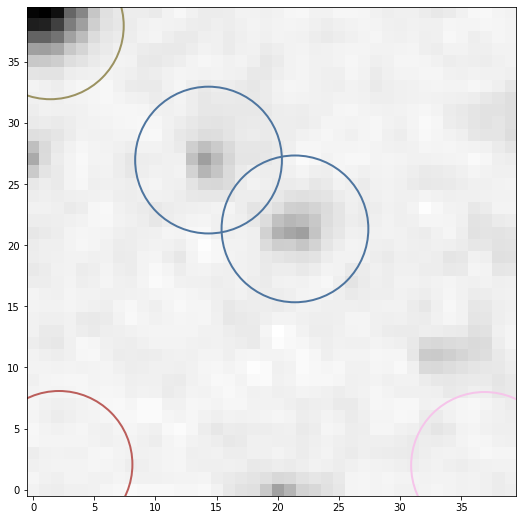

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06148870000004081s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.1220682 2.0682754 -192.98579   1 ... -65.971544 39.601021             1
36.911567 1.9857485  31.558286   2 ... -33.572433 43.561913             1
21.412265  21.32374  2296.0747   3 ...  2128.8497  55.53968             1
14.345872 26.948919  1999.1677   4 ...  1907.9893 59.275388             1
1.4108122 37.924454  6586.8029   5 ...  8637.9632 625.16821             1


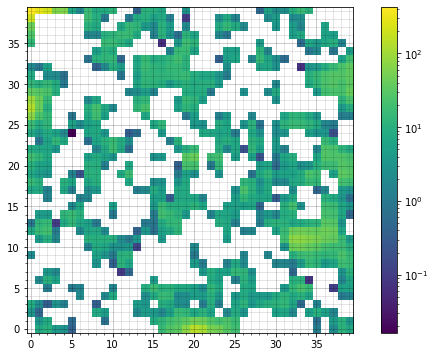

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.1220682 2.0682754          nan         nan
  2        2             1 36.911567 1.9857485          nan         nan
  3        3             1 21.412265  21.32374    16.723193 0.040927344
  4        3             1 14.345872 26.948919    16.842115 0.044837945
  5        4             1 1.4108122 37.924454    15.202527 0.083949088
first match table:
 id  xcenter   ycenter    mag_e2     err_e2  
--- --------- --------- --------- -----------
  1 2.1220682 2.0682754       nan         nan
  2 36.911567 1.9857485       nan         nan
  3 21.412265  21.32374 16.723193 0.040927344
  4 14.345872 26.948919 16.842115 0.044837945
  5 1.4108122 37.924454 15.202527 0.083949088
id_master    x_0       y_0      x_true  ...    dec      mag_e1     err_e1  
--------- --------- --------- --------- ... --------- --------- -----------
   

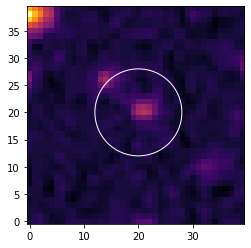

Mean: 169.7763671875
Median: 167.6099853515625
Std dev: 13.55591869354248
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.0467319922284215 ... 2.7583222674134804 -1.1016125135399604
  2 21.013475295079026 ... 3.3908200966692035 -1.3257618711597072
  3  14.10166015256907 ...   2.32202520073172 -0.9146673219682047
  4 1.1467776907450589 ... 15.022528293999994 -2.9418575766318957
  5  36.91818765891471 ...  2.458017723946951 -0.9764625252863879
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.0467319922284215 ... 2.7583222674134804 -1.1016125135399604
  2 21.013475295079026 ... 3.3908200966692035 -1.3257618711597072
  3  14.10166015256907 ...   2.32202520073172 -0.9146673219682047
  4 1.1467776907450589 ... 15.022528293999994 -2.9418575766318957
  5  36.91818765891471 ...  2.4580177239

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


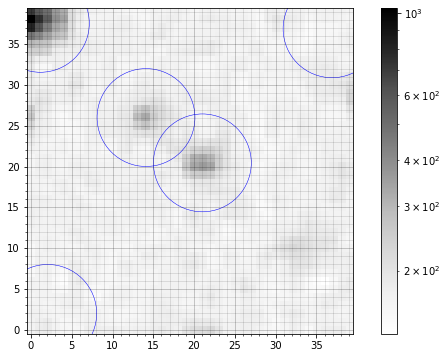

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1  2.046732 2.0024274  0.4483656 ... 177.01381 2.7583223  -1.1016125        1
  2 21.013475 20.462749 0.61729157 ... 361.47858 3.3908201  -1.3257619        2
  3  14.10166 26.021993 0.80872594 ... 327.21384 2.3220252 -0.91466732        2
  4 1.1467777 37.574351 0.49545562 ... 754.92499 15.022528  -2.9418576        3
  5 36.918188 36.906182 0.42422394 ... 163.54582 2.4580177 -0.97646253        4


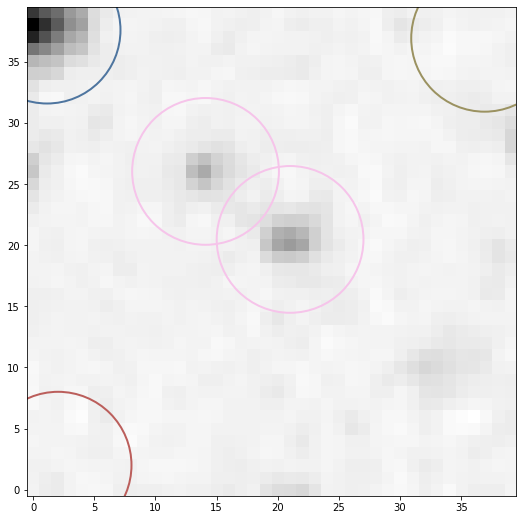

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.056772499999965476s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
 2.046732 2.0024274 -115.70612   1 ...  13.838296 52.916692             1
21.013475 20.462749  2852.1516   2 ...   2618.388 54.177381             1
 14.10166 26.021993  1981.3167   3 ...  1923.5974 59.089057             1
1.1467777 37.574351  7601.8403   4 ...  9270.3021 450.30558             1
36.918188 36.906182 -65.637974   5 ... -133.11337 47.243466             1


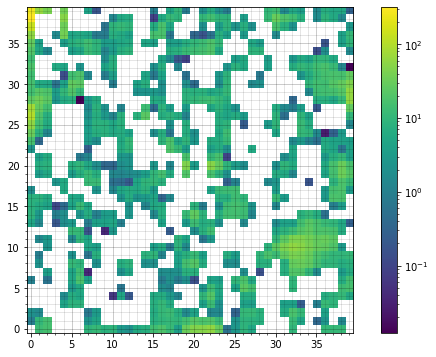

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  2.046732 2.0024274    22.190874   4.1518856
  2        2             1 21.013475 20.462749    16.498496 0.037113007
  3        2             1  14.10166 26.021993    16.833295 0.044553637
  4        3             1 1.1467777 37.574351    15.125846 0.060449748
  5        4             1 36.918188 36.906182          nan         nan
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1  2.046732 2.0024274 22.190874   4.1518856
  2 21.013475 20.462749 16.498496 0.037113007
  3  14.10166 26.021993 16.833295 0.044553637
  4 1.1467777 37.574351 15.125846 0.060449748
  5 36.918188 36.906182       nan         nan
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------

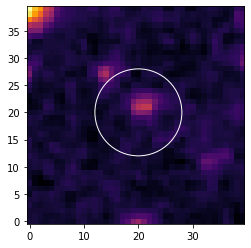

Mean: 168.92691040039062
Median: 166.4893035888672
Std dev: 14.368363380432129
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 2.0621060841585375 ...   2.35227439202222  -0.9287199516633838
  2  33.30291563996014 ... 1.0169477469606336 -0.01824659619657818
  3  20.93333535812102 ... 3.2707168322999154  -1.2866073649800136
  4  14.01840779654848 ...  2.200506056894521  -0.8563064207412154
  5  1.213098406950172 ... 12.378331422117288  -2.7316552661920808
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 2.0621060841585375 ...   2.35227439202222  -0.9287199516633838
  2  33.30291563996014 ... 1.0169477469606336 -0.01824659619657818
  3  20.93333535812102 ... 3.2707168322999154  -1.2866073649800136
  4  14.01840779654848 ...  2.200506056894521  -0.8563064207412154
  5  1.213098406950172

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


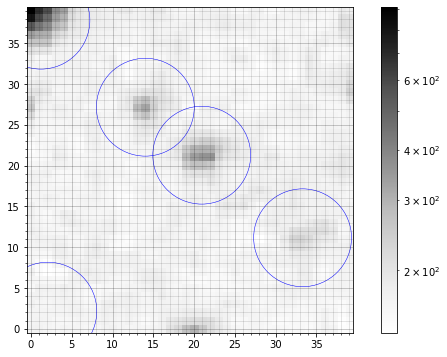

 id    x_0       y_0    sharpness  ...    peak      flux       mag      group_id
--- --------- --------- ---------- ... --------- --------- ------------ --------
  1 2.0621061   2.15497 0.44242369 ... 167.91788 2.3522744  -0.92871995        1
  2 33.302916 11.154929 0.64063381 ... 233.45238 1.0169477 -0.018246596        2
  3 20.933335  21.28344 0.58826646 ... 362.68018 3.2707168   -1.2866074        3
  4 14.018408 27.165837  0.8360139 ... 327.79361 2.2005061  -0.85630642        3
  5 1.2130984 37.838987 0.41985683 ... 601.40186 12.378331   -2.7316553        4


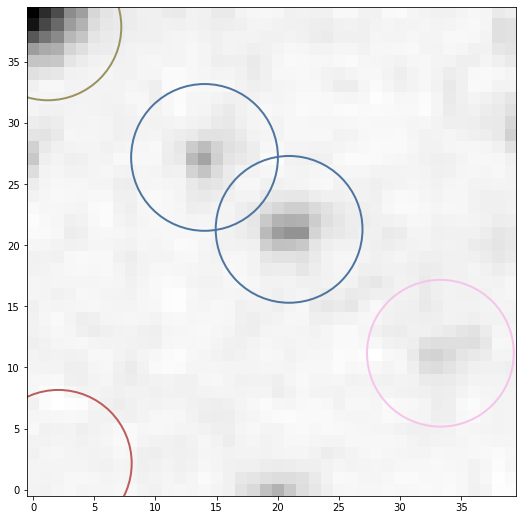

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.058329300000082185s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
2.0621061   2.15497  -104.732   1 ... 13.010565  44.73218             1
33.302916 11.154929 1310.9031   2 ...  1120.545 54.404592             1
20.933335  21.28344 2998.3387   3 ... 2797.9621 68.726303             1
14.018408 27.165837 1553.9791   4 ... 1815.4492 71.052027             1
1.2130984 37.838987 6263.0537   5 ... 8074.0764 584.03468             1


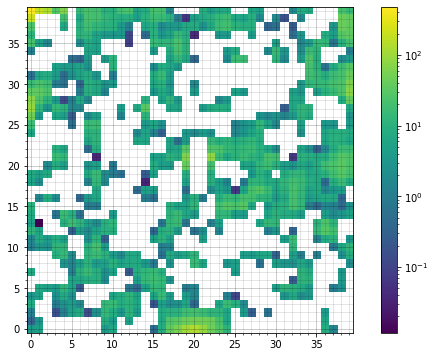

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.0621061   2.15497    22.257805   3.7330329
  2        2             1 33.302916 11.154929    17.419972 0.060427804
  3        3             1 20.933335  21.28344    16.426441 0.039798569
  4        3             1 14.018408 27.165837    16.896085 0.051752718
  5        4             1 1.2130984 37.838987    15.275813 0.083908495
first match table:
 id  xcenter   ycenter    mag_e4     err_e4  
--- --------- --------- --------- -----------
  1 2.0621061   2.15497 22.257805   3.7330329
  2 33.302916 11.154929 17.419972 0.060427804
  3 20.933335  21.28344 16.426441 0.039798569
  4 14.018408 27.165837 16.896085 0.051752718
  5 1.2130984 37.838987 15.275813 0.083908495
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------

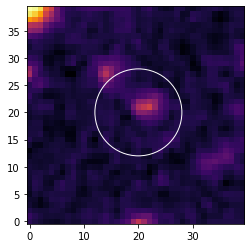

Mean: 169.2604522705078
Median: 166.54603576660156
Std dev: 14.403712272644043
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  1.979328998143795 ... 2.5881580107586393 -1.0324769677676842
  2  36.87169129979035 ... 2.4226748345357447 -0.9607378202763439
  3  21.50991497698656 ... 2.8131803762464678 -1.1229939481672295
  4 14.232690894906769 ... 1.9954136123644381 -0.7500823264344756
  5 1.3317688256359466 ... 13.026486663676046  -2.787068247968591
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  1.979328998143795 ... 2.5881580107586393 -1.0324769677676842
  2  36.87169129979035 ... 2.4226748345357447 -0.9607378202763439
  3  21.50991497698656 ... 2.8131803762464678 -1.1229939481672295
  4 14.232690894906769 ... 1.9954136123644381 -0.7500823264344756
  5 1.3317688256359466 ... 13.02648

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


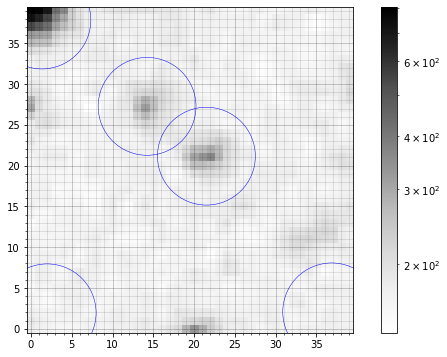

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1  1.979329 1.9501634  0.4507533 ... 175.87091  2.588158   -1.032477        1
  2 36.871691 2.0663681 0.41155551 ...  166.5378 2.4226748 -0.96073782        2
  3 21.509915 21.161572 0.58911536 ... 337.33929 2.8131804  -1.1229939        3
  4 14.232691 27.269951 0.80189049 ... 319.02716 1.9954136 -0.75008233        3
  5 1.3317688 37.860039 0.44536752 ...  651.0722 13.026487  -2.7870682        4


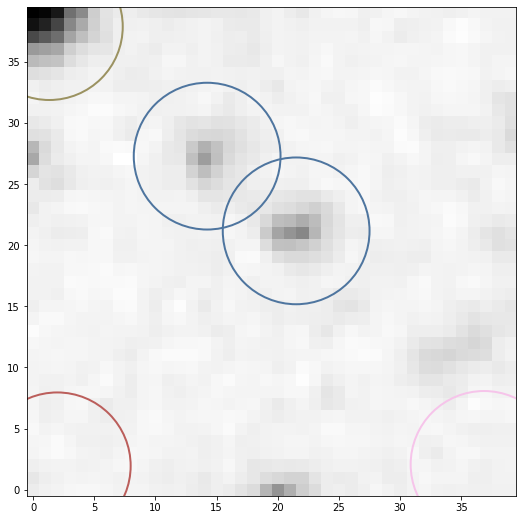

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06982730000004267s
   x_0        y_0      flux_0   id ...  flux_fit   flux_unc iter_detected
---------- --------- --------- --- ... ---------- --------- -------------
  1.979329 1.9501634 36.611397   1 ... 0.60066865 45.598333             1
 36.871691 2.0663681 56.391295   2 ...  86.919953 38.049572             1
 21.509915 21.161572 2785.3956   3 ...  2691.5536 64.458935             1
 14.232691 27.269951 2324.2095   4 ...  2006.2618 63.125756             1
 1.3317688 37.860039 6724.3146   5 ...  8530.1379 576.13848             1
0.52251645 27.082439 744.70188   6 ...  1182.4461   92.0756             2


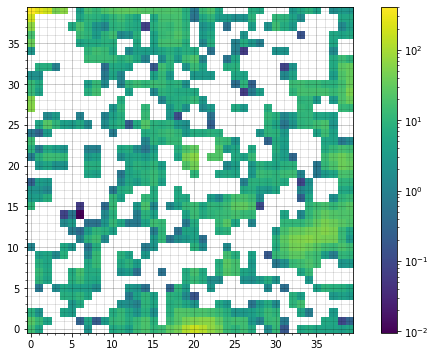

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   1.979329 1.9501634    25.596983   82.421088
  2        2             1  36.871691 2.0663681    20.195772  0.47620274
  3        3             1  21.509915 21.161572    16.468563 0.039354687
  4        3             1  14.232691 27.269951    16.787601 0.045163447
  5        4             1  1.3317688 37.860039     15.21618 0.079058946
  6        1             2 0.52251645 27.082439    17.361617 0.089557461
first match table:
 id  xcenter    ycenter    mag_e5     err_e5  
--- ---------- --------- --------- -----------
  1   1.979329 1.9501634 25.596983   82.421088
  2  36.871691 2.0663681 20.195772  0.47620274
  3  21.509915 21.161572 16.468563 0.039354687
  4  14.232691 27.269951 16.787601 0.045163447
  5  1.3317688 37.860039  15.21618 0.079058946
  6 0.52251645 27.082439 17.361617 0.089557461
id_master    x_0     

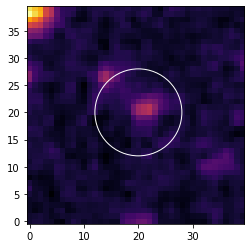

Mean: 168.1536865234375
Median: 165.09861755371094
Std dev: 15.31192398071289
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1342834255859797 ... 2.1607839508839555  -0.836528363726413
  2 21.389461662148452 ...  2.782229527910191  -1.110982388720337
  3 14.229690216398572 ... 1.9275406429373414 -0.7125088602151717
  4 1.2783589376624755 ...   13.5736546717025   -2.83174199019929
  5  36.93225784336404 ... 2.1123354165709354 -0.8119072017944569
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1342834255859797 ... 2.1607839508839555  -0.836528363726413
  2 21.389461662148452 ...  2.782229527910191  -1.110982388720337
  3 14.229690216398572 ... 1.9275406429373414 -0.7125088602151717
  4 1.2783589376624755 ...   13.5736546717025   -2.83174199019929
  5  36.93225784336404 ... 2.1123354

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


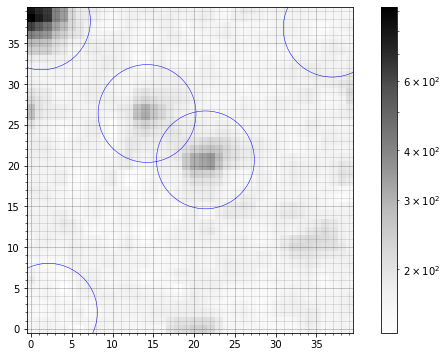

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 2.1342834 2.0143947 0.44186164 ... 162.66946  2.160784 -0.83652836        1
  2 21.389462 20.704235 0.47399577 ... 329.93936 2.7822295  -1.1109824        2
  3  14.22969 26.394144 0.68384741 ... 301.27994 1.9275406 -0.71250886        2
  4 1.2783589 37.754151 0.50364871 ... 772.74353 13.573655   -2.831742        3
  5 36.932258 36.861415 0.44205555 ... 161.36021 2.1123354  -0.8119072        4


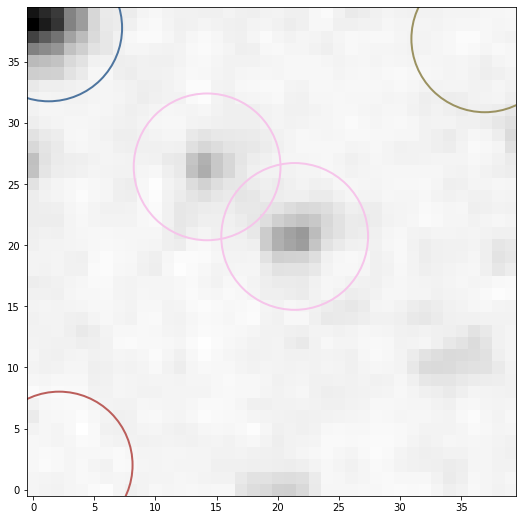

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06818539999994755s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 2.1342834 2.0143947 -296.09082   1 ...  -155.3785 49.098141             1
 21.389462 20.704235  3532.8423   2 ...  2936.2996 63.871196             1
  14.22969 26.394144  2391.1663   3 ...  1915.5367 63.429084             1
 1.2783589 37.754151  7829.3284   4 ...  9542.9602 532.35131             1
 36.932258 36.861415  47.222333   5 ... -106.57584 38.387354             1
0.35622544 26.963565  717.32964   6 ...  1139.5479 81.566003             2


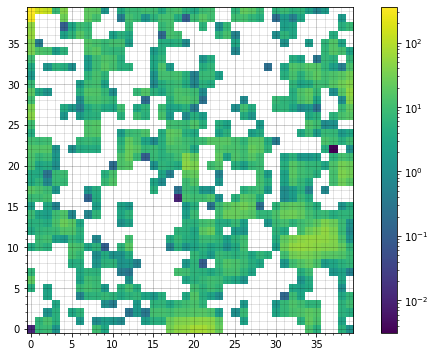

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  2.1342834 2.0143947          nan         nan
  2        2             1  21.389462 20.704235    16.374121 0.037821532
  3        2             1   14.22969 26.394144    16.837896   0.0465321
  4        3             1  1.2783589 37.754151    15.094415 0.067387795
  5        4             1  36.932258 36.861415          nan         nan
  6        1             2 0.35622544 26.963565    17.401791 0.083139682
first match table:
 id  xcenter    ycenter    mag_e6     err_e6  
--- ---------- --------- --------- -----------
  1  2.1342834 2.0143947       nan         nan
  2  21.389462 20.704235 16.374121 0.037821532
  3   14.22969 26.394144 16.837896   0.0465321
  4  1.2783589 37.754151 15.094415 0.067387795
  5  36.932258 36.861415       nan         nan
  6 0.35622544 26.963565 17.401791 0.083139682
id_master    x_0     

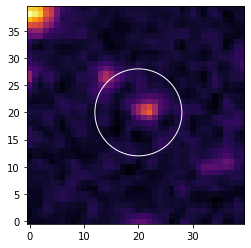

Mean: 172.50735473632812
Median: 169.8061065673828
Std dev: 13.935626029968262
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   21.6301953007783 ...  4.137391810999112 -1.5418166263247541
  2 14.079746190602323 ...  2.278753888215795 -0.8942435567403834
  3 1.3578349770896536 ... 14.813166288401487 -2.9266197453252407
  4 36.951864245451254 ... 2.3916794328490876 -0.9467574221177828
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   21.6301953007783 ...  4.137391810999112 -1.5418166263247541
  2 14.079746190602323 ...  2.278753888215795 -0.8942435567403834
  3 1.3578349770896536 ... 14.813166288401487 -2.9266197453252407
  4 36.951864245451254 ... 2.3916794328490876 -0.9467574221177828
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


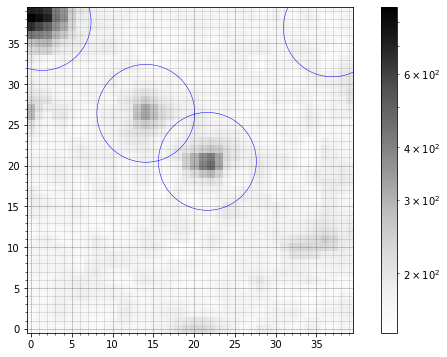

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 21.630195 20.524248 0.78624328 ... 455.28448 4.1373918  -1.5418166        1
  2 14.079746 26.416018 0.72734306 ... 324.17355 2.2787539 -0.89424356        1
  3  1.357835 37.675582 0.51914091 ... 792.06567 14.813166  -2.9266197        2
  4 36.951864 36.896706 0.44769508 ... 166.29489 2.3916794 -0.94675742        3


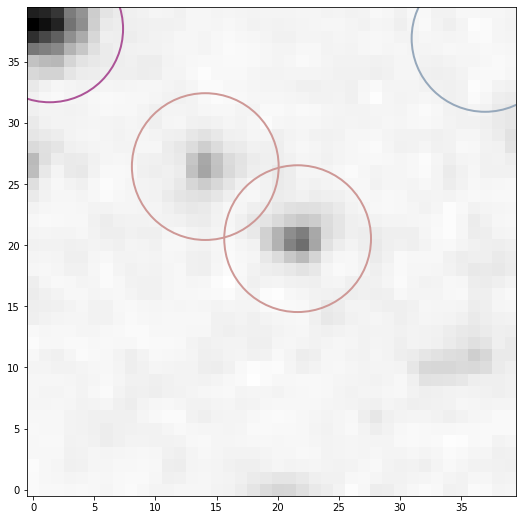

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.050003699999933815s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
21.630195 20.524248  3318.1782   1 ...  3290.4759 65.333223             1
14.079746 26.416018  2271.4224   2 ...  1976.1411 67.216117             1
 1.357835 37.675582   8056.089   3 ...  9331.7489 485.90123             1
36.951864 36.896706 -24.415648   4 ... -164.52448 43.549593             1


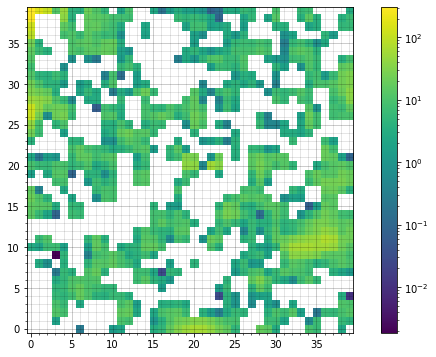

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.630195 20.524248    16.250409 0.036570797
  2        1             1 14.079746 26.416018    16.804011 0.047291887
  3        2             1  1.357835 37.675582    15.118648 0.063786999
  4        3             1 36.951864 36.896706          nan         nan
first match table:
 id  xcenter   ycenter    mag_e7     err_e7  
--- --------- --------- --------- -----------
  1 21.630195 20.524248 16.250409 0.036570797
  2 14.079746 26.416018 16.804011 0.047291887
  3  1.357835 37.675582 15.118648 0.063786999
  4 36.951864 36.896706       nan         nan
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0947802 2.0873446 293.10064 ...   82.421088       nan         nan
        1 36.861764 2.0730946 327.86762

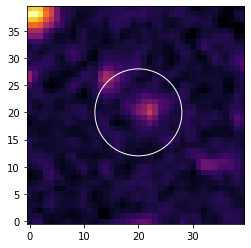

Mean: 167.40487670898438
Median: 164.73117065429688
Std dev: 14.58573055267334
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2.076710032826976 ... 2.3641369319121823 -0.9341815686909742
  2  36.80847397441606 ... 2.4736262915137863 -0.9833352206573064
  3  21.84752296897693 ...  2.307158351478437 -0.9076935082069194
  4 14.450438977010927 ...  2.031397297938653 -0.7694871760998279
  5 1.4409879866465438 ... 13.742268469477372 -2.8451460717030397
  6  37.02751316584032 ...  2.263713804142872 -0.8870537979665866
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2.076710032826976 ... 2.3641369319121823 -0.9341815686909742
  2  36.80847397441606 ... 2.4736262915137863 -0.9833352206573064
  3  21.84752296897693 ...  2.307158351478437 -0.9076935082069194
  4 14.450438977010927 ...  2.03139

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


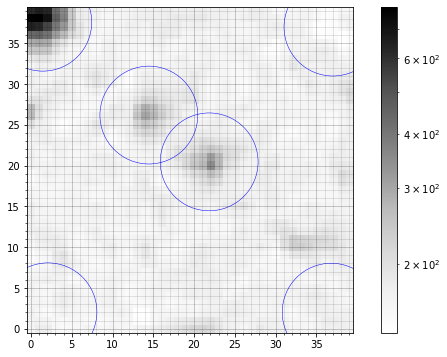

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1   2.07671 2.0748941 0.43574845 ...    165.88 2.3641369 -0.93418157        1
  2 36.808474 2.0293823 0.43431803 ... 173.11195 2.4736263 -0.98333522        2
  3 21.847523 20.463201 0.83247652 ...  350.3942 2.3071584 -0.90769351        3
  4 14.450439 26.202048 0.69417301 ... 303.05161 2.0313973 -0.76948718        3
  5  1.440988 37.589006 0.52960617 ... 789.96924 13.742268  -2.8451461        4
  6 37.027513 36.991935 0.49814184 ... 165.55836 2.2637138  -0.8870538        5


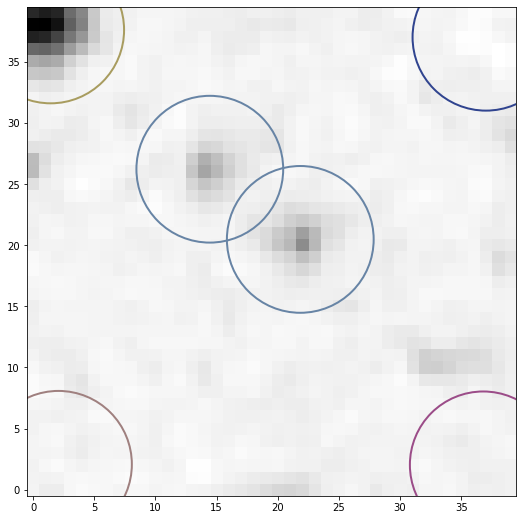

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05916539999998349s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
  2.07671 2.0748941 -69.015224   1 ... -32.966614 41.714497             1
36.808474 2.0293823  188.13741   2 ...  194.41794  34.18961             1
21.847523 20.463201  2746.4821   3 ...  2188.6551 58.359977             1
14.450439 26.202048  2095.9729   4 ...  1981.2539 63.867303             1
 1.440988 37.589006  8318.2956   5 ...   9178.849 436.40954             1
37.027513 36.991935 -187.10628   6 ...  -332.0542 54.484754             1


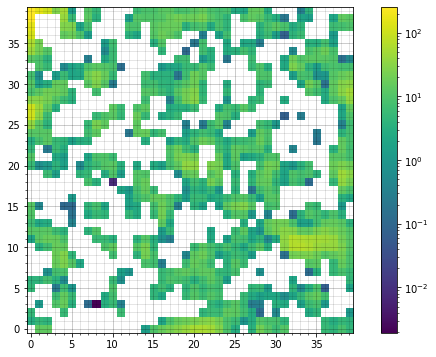

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1   2.07671 2.0748941          nan         nan
  2        2             1 36.808474 2.0293823    19.321728  0.19320532
  3        3             1 21.847523 20.463201    16.693125 0.041362415
  4        3             1 14.450439 26.202048    16.801218 0.045800271
  5        4             1  1.440988 37.589006    15.136598 0.059476637
  6        5             1 37.027513 36.991935          nan         nan
first match table:
 id  xcenter   ycenter    mag_e8     err_e8  
--- --------- --------- --------- -----------
  1   2.07671 2.0748941       nan         nan
  2 36.808474 2.0293823 19.321728  0.19320532
  3 21.847523 20.463201 16.693125 0.041362415
  4 14.450439 26.202048 16.801218 0.045800271
  5  1.440988 37.589006 15.136598 0.059476637
  6 37.027513 36.991935       nan         nan
id_master    x_0       y_0      x_tru

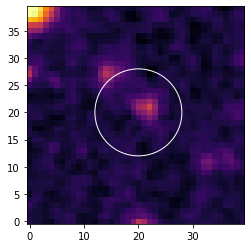

Mean: 167.82286071777344
Median: 165.23870849609375
Std dev: 14.470345497131348
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.665345359919005 ...  2.622355178619729 -1.0467287832860146
  2 14.416868670771755 ...  2.040904876518159  -0.774556908451147
  3 1.3858348066738657 ... 13.672539466892509 -2.8396229641867032
  4 37.065800798768414 ...  2.463843883525095   -0.97903296543596
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.665345359919005 ...  2.622355178619729 -1.0467287832860146
  2 14.416868670771755 ...  2.040904876518159  -0.774556908451147
  3 1.3858348066738657 ... 13.672539466892509 -2.8396229641867032
  4 37.065800798768414 ...  2.463843883525095   -0.97903296543596
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


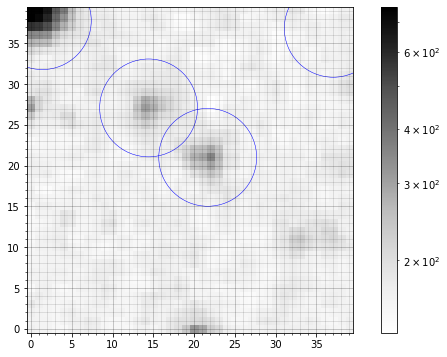

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 21.665345 21.017607 0.43240031 ... 296.77036 2.6223552  -1.0467288        1
  2 14.416869 27.079129 0.70657692 ... 308.14157 2.0409049 -0.77455691        1
  3 1.3858348 37.784333 0.48365794 ... 723.10974 13.672539   -2.839623        2
  4 37.065801 36.841741 0.47990097 ... 177.89311 2.4638439 -0.97903297        3


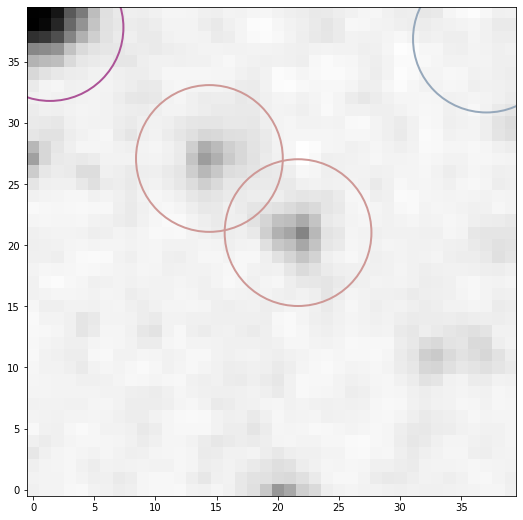

Time taken to fit PSF model: 0.05004449999989902s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
21.665345 21.017607 2671.1251   1 ... 2467.8499 66.073788             1
14.416869 27.079129 2541.2533   2 ... 2168.7552 68.162119             1
1.3858348 37.784333 7381.2573   3 ... 8992.0444  529.6383             1
37.065801 36.841741 158.22597   4 ... 81.556061 47.033575             1


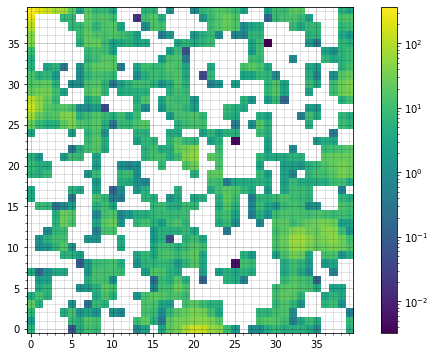

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.665345 21.017607     16.56268 0.041445382
  2        1             1 14.416869 27.079129    16.702951 0.045134528
  3        2             1 1.3858348 37.784333    15.158831 0.070444203
  4        3             1 37.065801 36.841741    20.264837  0.62684316
first match table:
 id  xcenter   ycenter    mag_e9     err_e9  
--- --------- --------- --------- -----------
  1 21.665345 21.017607  16.56268 0.041445382
  2 14.416869 27.079129 16.702951 0.045134528
  3 1.3858348 37.784333 15.158831 0.070444203
  4 37.065801 36.841741 20.264837  0.62684316
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0947802 2.0873446 293.10064 ...          --       nan         nan
        1 36.861764 2.0730946 327.86762

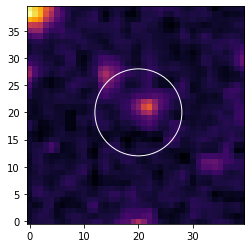

Mean: 167.46417236328125
Median: 164.8763427734375
Std dev: 14.566905975341797
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.73815836458351 ... 2.1480430416421337 -0.8301074483420614
  2 21.671813939549967 ... 3.3767231469777745 -1.3212386371758105
  3 14.323096114438993 ... 1.9689818601233946 -0.7356042876985186
  4 1.3100374257199758 ... 13.507558388496848  -2.826442133799818
  5  36.94976100799339 ... 2.2194590835416808 -0.8656178576838623
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  36.73815836458351 ... 2.1480430416421337 -0.8301074483420614
  2 21.671813939549967 ... 3.3767231469777745 -1.3212386371758105
  3 14.323096114438993 ... 1.9689818601233946 -0.7356042876985186
  4 1.3100374257199758 ... 13.507558388496848  -2.826442133799818
  5  36.94976100799339 ... 2.219459

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


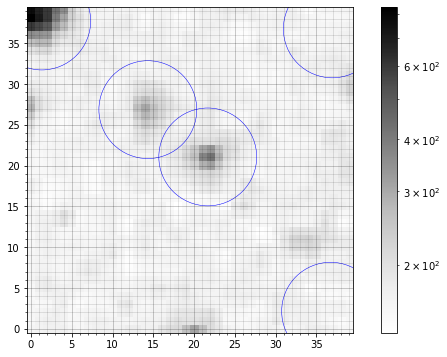

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 36.738158 2.1440177 0.35929116 ... 147.29636  2.148043 -0.83010745        1
  2 21.671814 21.068368 0.83440841 ... 424.46124 3.3767231  -1.3212386        2
  3 14.323096 26.869511  0.7006138 ... 304.44855 1.9689819 -0.73560429        2
  4 1.3100374 37.737928 0.47675421 ... 710.08551 13.507558  -2.8264421        3
  5 36.949761 36.772179 0.38556906 ... 153.48239 2.2194591 -0.86561786        4


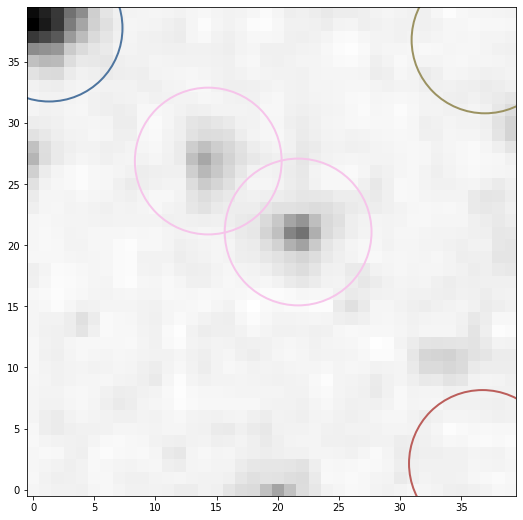

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05843320000008134s
   x_0       y_0      flux_0   id ...  flux_fit   flux_unc iter_detected
--------- --------- --------- --- ... ---------- --------- -------------
36.738158 2.1440177 15.843056   1 ... -83.944029   45.0473             1
21.671814 21.068368 3154.2903   2 ...  3149.4866 64.695404             1
14.323096 26.869511 2141.3848   3 ...  2019.4734 65.543945             1
1.3100374 37.737928 7207.5574   4 ...   8825.554 487.56564             1
36.949761 36.772179  127.7804   5 ... -58.184013 47.909132             1


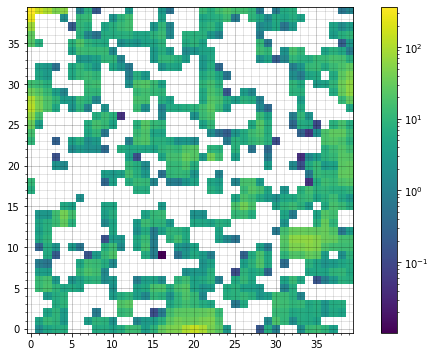

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 36.738158 2.1440177          nan         nan
  2        2             1 21.671814 21.068368    16.297836 0.037014947
  3        2             1 14.323096 26.869511     16.78034 0.045983196
  4        3             1 1.3100374 37.737928    15.179081 0.066861377
  5        4             1 36.949761 36.772179          nan         nan
first match table:
 id  xcenter   ycenter   mag_e10    err_e10  
--- --------- --------- --------- -----------
  1 36.738158 2.1440177       nan         nan
  2 21.671814 21.068368 16.297836 0.037014947
  3 14.323096 26.869511  16.78034 0.045983196
  4 1.3100374 37.737928 15.179081 0.066861377
  5 36.949761 36.772179       nan         nan
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------

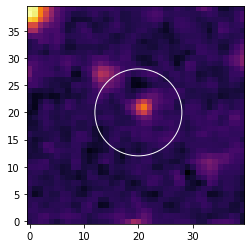

Mean: 166.6637725830078
Median: 164.89427185058594
Std dev: 13.82557201385498
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  33.16672352010983 ... 1.1352498383749337 -0.13772862185669155
  2 13.637364558185006 ...  2.188290648233636  -0.8502625109507373
  3 1.1538503908262556 ...  13.87998280541165  -2.8559723202827776
  4 37.036011284499466 ... 2.5678573848944453  -1.0239272499393801
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  33.16672352010983 ... 1.1352498383749337 -0.13772862185669155
  2 13.637364558185006 ...  2.188290648233636  -0.8502625109507373
  3 1.1538503908262556 ...  13.87998280541165  -2.8559723202827776
  4 37.036011284499466 ... 2.5678573848944453  -1.0239272499393801
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


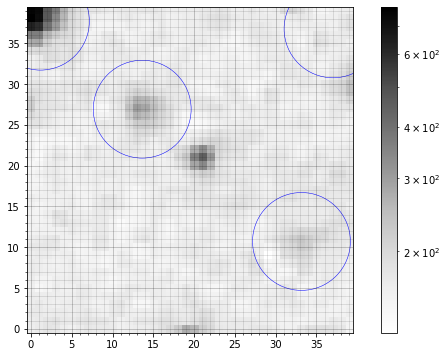

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 33.166724 10.702174  0.4893217 ... 223.73849 1.1352498 -0.13772862        1
  2 13.637365  26.92316 0.52197211 ... 286.60223 2.1882906 -0.85026251        2
  3 1.1538504 37.717321 0.51984882 ... 718.58105 13.879983  -2.8559723        3
  4 37.036011 36.774253 0.44420893 ...  172.0117 2.5678574  -1.0239272        4


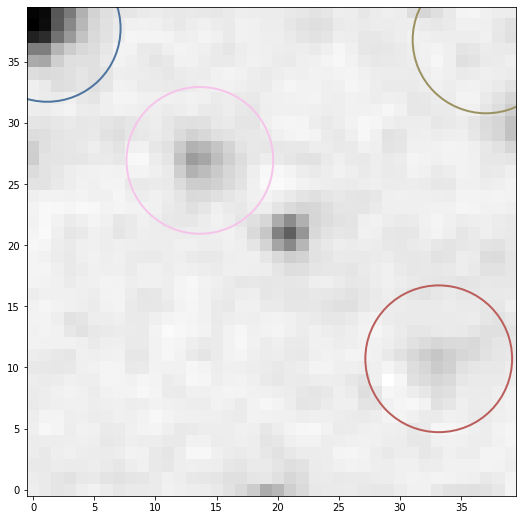

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06642199999998866s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
33.166724 10.702174 1022.6385   1 ... 1012.0478 54.472144             1
13.637365  26.92316 1932.9859   2 ... 2030.3714 57.525253             1
1.1538504 37.717321 6282.3342   3 ... 8197.4806 421.56973             1
37.036011 36.774253 168.03607   4 ... 75.828509 65.188395             1
38.495775 29.718327 426.25734   5 ... 870.18323 57.701067             2


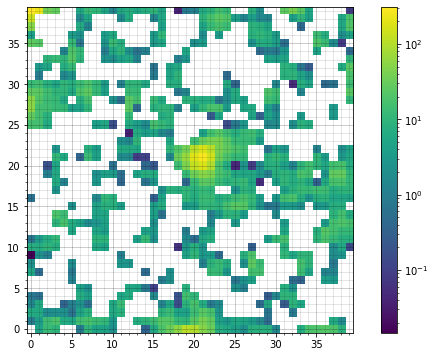

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 33.166724 10.702174    17.530442 0.065480782
  2        2             1 13.637365  26.92316    16.774506 0.042649314
  3        3             1 1.1538504 37.717321    15.259244 0.063169137
  4        4             1 37.036011 36.774253    20.343864  0.93385511
  5        1             2 38.495775 29.718327    17.694418 0.077819394
first match table:
 id  xcenter   ycenter   mag_e11    err_e11  
--- --------- --------- --------- -----------
  1 33.166724 10.702174 17.530442 0.065480782
  2 13.637365  26.92316 16.774506 0.042649314
  3 1.1538504 37.717321 15.259244 0.063169137
  4 37.036011 36.774253 20.343864  0.93385511
  5 38.495775 29.718327 17.694418 0.077819394
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------

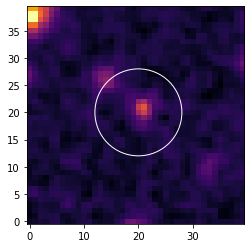

Mean: 165.46153259277344
Median: 163.75181579589844
Std dev: 14.057987213134766
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.053939332341976 ...  2.354997765992092 -0.9299762487071206
  2 20.790717900320413 ...  3.621220548413953 -1.3971374402131376
  3 13.960431988249914 ... 2.0091516173507467 -0.7575317782745866
  4  1.100615063820885 ... 15.128964789255807 -2.9495230302868003
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.053939332341976 ...  2.354997765992092 -0.9299762487071206
  2 20.790717900320413 ...  3.621220548413953 -1.3971374402131376
  3 13.960431988249914 ... 2.0091516173507467 -0.7575317782745866
  4  1.100615063820885 ... 15.128964789255807 -2.9495230302868003
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


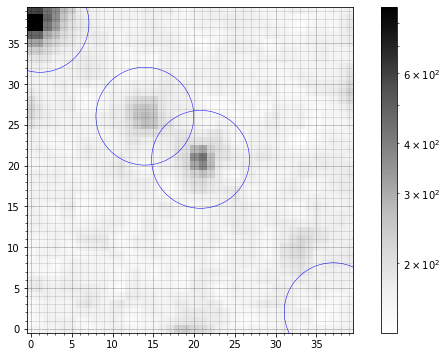

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 37.053939 2.0852274 0.40413024 ... 153.75529 2.3549978 -0.92997625        1
  2 20.790718  20.76926 0.83897572 ... 425.61618 3.6212205  -1.3971374        2
  3 13.960432 26.067537 0.51783093 ... 274.12485 2.0091516 -0.75753178        2
  4 1.1006151  37.44736 0.60047074 ... 873.47601 15.128965   -2.949523        3


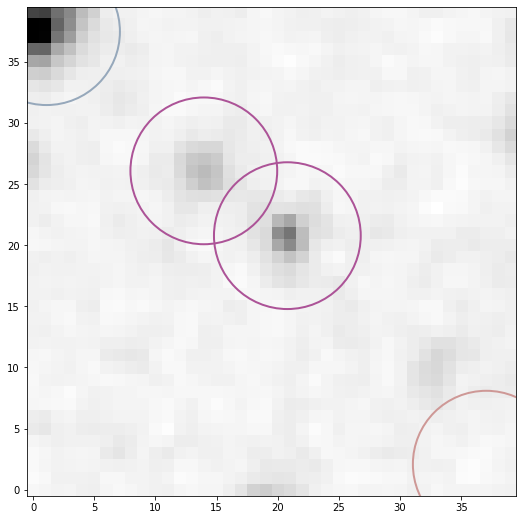

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04577039999992394s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
37.053939 2.0852274 -164.51717   1 ... -285.48044 42.441423             1
20.790718  20.76926  2725.2912   2 ...  2878.3599 58.467563             1
13.960432 26.067537  2021.5076   3 ...  1757.1027 61.196042             1
1.1006151  37.44736  7450.1445   4 ...  9588.7012  306.2566             1


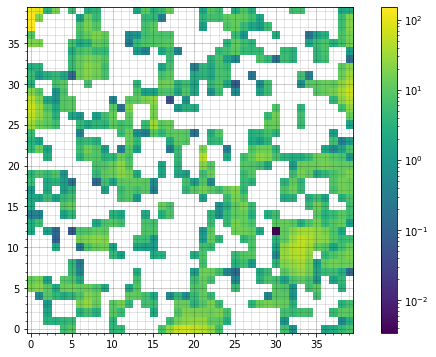

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 37.053939 2.0852274          nan         nan
  2        2             1 20.790718  20.76926    16.395697 0.036865823
  3        2             1 13.960432 26.067537    16.931567   0.0479852
  4        3             1 1.1006151  37.44736     15.08916 0.045554757
first match table:
 id  xcenter   ycenter   mag_e12    err_e12  
--- --------- --------- --------- -----------
  1 37.053939 2.0852274       nan         nan
  2 20.790718  20.76926 16.395697 0.036865823
  3 13.960432 26.067537 16.931567   0.0479852
  4 1.1006151  37.44736  15.08916 0.045554757
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0947802 2.0873446 293.10064 ...          --        --          --
        1 36.861764 2.0730946 327.86762

<ipython-input-14-502a472d10e5>:342: RuntimeWarning: invalid value encountered in double_scalars
  var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)


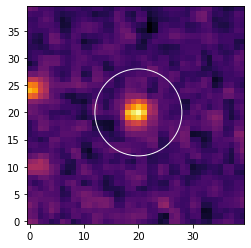

Mean: 166.41200256347656
Median: 165.32510375976562
Std dev: 11.403582572937012
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 1.973987791895883 ... 3.1301455898884947 -1.2389113449960851
  2 19.66503682145445 ...  4.143904807803616 -1.5435244260125567
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 1.973987791895883 ... 3.1301455898884947 -1.2389113449960851
  2 19.66503682145445 ...  4.143904807803616 -1.5435244260125567
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


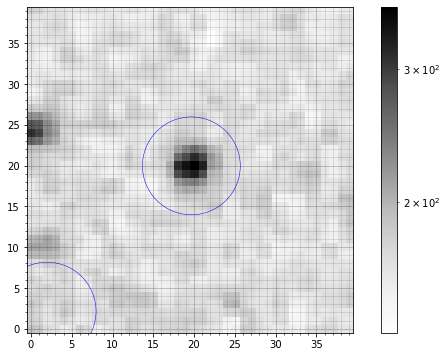

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 1.9739878 2.1564419 0.43293312 ... 175.54395 3.1301456 -1.2389113        1
  2 19.665037 19.973582 0.55361192 ... 362.60822 4.1439048 -1.5435244        2


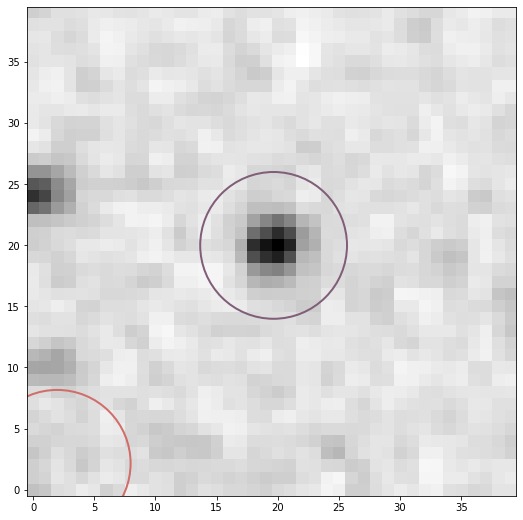

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06395359999999073s
   x_0        y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
---------- --------- --------- --- ... --------- --------- -------------
 1.9739878 2.1564419 334.59544   1 ... 199.82059  50.48564             1
 19.665037 19.973582 3215.6128   2 ... 3135.6011  81.81473             1
 1.7708231 10.125241 618.10593   3 ... 742.64534 45.464706             2
0.99448258 24.247293 1608.9259   5 ... 1881.2026 46.465325             2


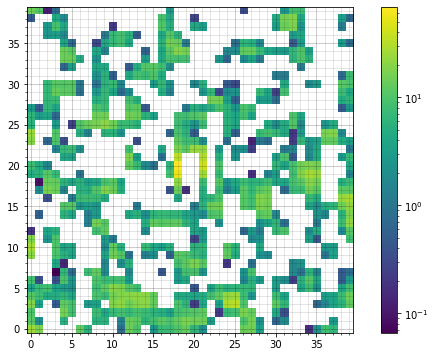

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  1.9739878 2.1564419    19.299754   0.2759026
  2        2             1  19.665037 19.973582    16.310553 0.040929706
  3        1             2  1.7708231 10.125241    17.874401 0.072737775
  5        2             2 0.99448258 24.247293    16.865266 0.039898259
first match table:
 id  xcenter    ycenter    mag_e1     err_e1  
--- ---------- --------- --------- -----------
  1  1.9739878 2.1564419 19.299754   0.2759026
  2  19.665037 19.973582 16.310553 0.040929706
  3  1.7708231 10.125241 17.874401 0.072737775
  5 0.99448258 24.247293 16.865266 0.039898259
id_master    x_0        y_0      x_true    y_true      RA       dec   
--------- ---------- --------- --------- --------- --------- ---------
        0  2.0318106 2.1866823 847.45976 404.57449  346.7051 12.693428
        1   19.47717  19.80043 864.90512 422.188

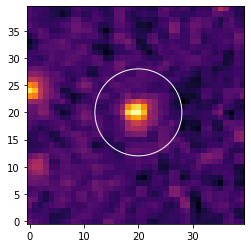

Mean: 166.67369079589844
Median: 165.72085571289062
Std dev: 11.15760326385498
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.0005439932358735 ... 3.0856031720153054   -1.22335018078772
  2 19.557842785357803 ...  4.255387015020975 -1.5723476600789361
  3 2.0203958533649695 ... 3.0331019175789504 -1.2047175090428095
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.0005439932358735 ... 3.0856031720153054   -1.22335018078772
  2 19.557842785357803 ...  4.255387015020975 -1.5723476600789361
  3 2.0203958533649695 ... 3.0331019175789504 -1.2047175090428095
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


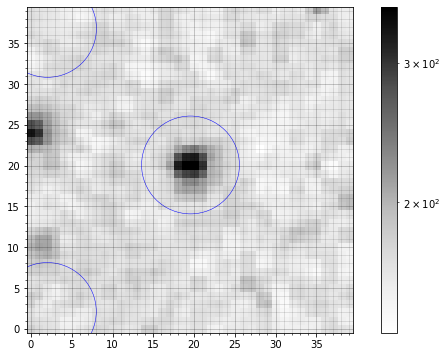

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1  2.000544 2.1125678 0.42307439 ... 166.59692 3.0856032 -1.2233502        1
  2 19.557843 20.083747 0.53889598 ... 353.48074  4.255387 -1.5723477        2
  3 2.0203959 36.833143 0.43461767 ... 166.03622 3.0331019 -1.2047175        3


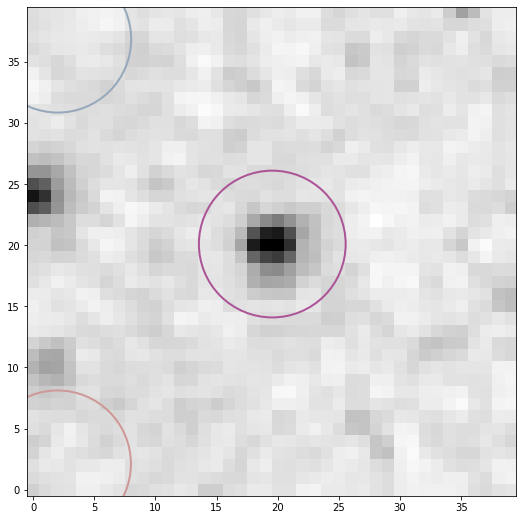

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06101560000001882s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
  2.000544 2.1125678  107.86507   1 ... -33.471465 48.477058             1
 19.557843 20.083747  3093.3129   2 ...  3091.3629 69.137187             1
 2.0203959 36.833143 -130.43339   3 ... -71.058818 44.286086             1
 1.4687169 9.9840478  669.89982   4 ...  768.78087 44.357308             2
0.87888007 24.097105   1714.819   6 ...    2023.13 53.698216             2


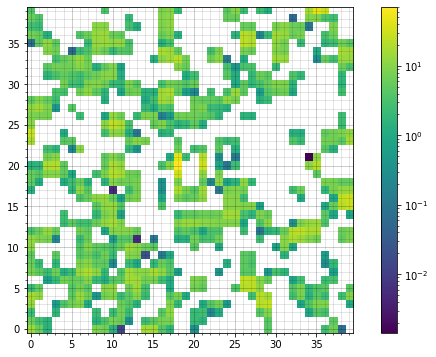

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   2.000544 2.1125678          nan         nan
  2        2             1  19.557843 20.083747    16.326126  0.03824022
  3        3             1  2.0203959 36.833143          nan         nan
  4        1             2  1.4687169 9.9840478    17.836994 0.069261101
  6        2             2 0.87888007 24.097105    16.786441 0.041269342
first match table:
 id  xcenter    ycenter    mag_e2     err_e2  
--- ---------- --------- --------- -----------
  1   2.000544 2.1125678       nan         nan
  2  19.557843 20.083747 16.326126  0.03824022
  3  2.0203959 36.833143       nan         nan
  4  1.4687169 9.9840478 17.836994 0.069261101
  6 0.87888007 24.097105 16.786441 0.041269342
id_master    x_0        y_0      x_true  ...    dec      mag_e1     err_e1  
--------- ---------- --------- --------- ... --------- ---------

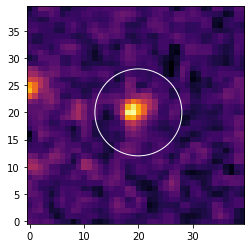

Mean: 166.64894104003906
Median: 165.28146362304688
Std dev: 11.787514686584473
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 2.0367622058579817 ...  3.066066384104399   -1.2164538840732222
  2  8.941461957828073 ... 1.0220533561893677 -0.023683921722159256
  3 19.062773163550993 ...  4.134616933266216   -1.5410881973724804
  4  37.04760388430712 ...  2.933947785850801   -1.1686309515811684
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 2.0367622058579817 ...  3.066066384104399   -1.2164538840732222
  2  8.941461957828073 ... 1.0220533561893677 -0.023683921722159256
  3 19.062773163550993 ...  4.134616933266216   -1.5410881973724804
  4  37.04760388430712 ...  2.933947785850801   -1.1686309515811684
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


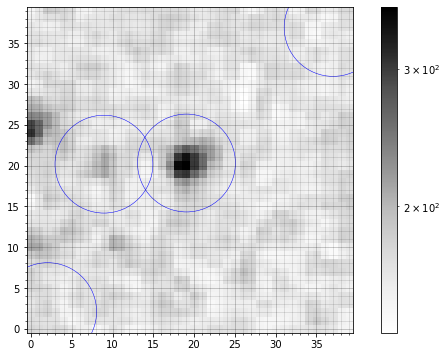

 id    x_0       y_0    sharpness  ...    peak      flux       mag      group_id
--- --------- --------- ---------- ... --------- --------- ------------ --------
  1 2.0367622   2.09847 0.40477666 ... 168.77831 3.0660664   -1.2164539        1
  2  8.941462 20.182066 0.54897178 ... 209.35742 1.0220534 -0.023683922        2
  3 19.062773 20.321507 0.55005912 ...  360.5296 4.1346169   -1.5410882        2
  4 37.047604 36.946827 0.45158394 ... 168.79816 2.9339478    -1.168631        3


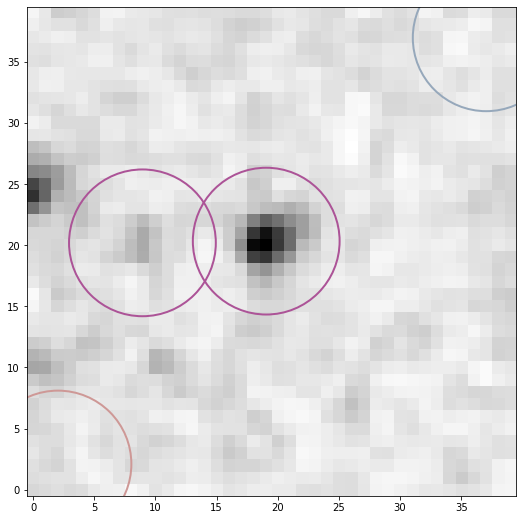

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06945109999992383s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 2.0367622   2.09847  94.835517   1 ...  106.79435 43.986684             1
  8.941462 20.182066  577.07263   2 ...   614.1643 54.485677             1
 19.062773 20.321507  3142.3781   3 ...  2978.2758 53.518546             1
 37.047604 36.946827 -199.81203   4 ... -132.91821 44.879785             1
0.87091492 24.594123  1757.4966   5 ...  1684.9723 66.359166             2


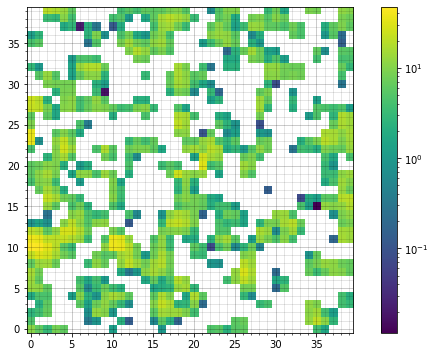

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  2.0367622   2.09847    19.980043     0.44817
  2        2             1   8.941462 20.182066    18.080703  0.10074958
  3        2             1  19.062773 20.321507    16.366502 0.035402628
  4        3             1  37.047604 36.946827          nan         nan
  5        1             2 0.87091492 24.594123    16.984932 0.051971803
first match table:
 id  xcenter    ycenter    mag_e3     err_e3  
--- ---------- --------- --------- -----------
  1  2.0367622   2.09847 19.980043     0.44817
  2   8.941462 20.182066 18.080703  0.10074958
  3  19.062773 20.321507 16.366502 0.035402628
  4  37.047604 36.946827       nan         nan
  5 0.87091492 24.594123 16.984932 0.051971803
id_master    x_0        y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- ---------- --------- --------- ... ----------- -----

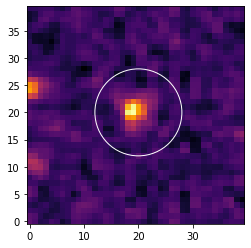

Mean: 165.01576232910156
Median: 163.9529571533203
Std dev: 11.24744701385498
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.9569061403560188 ... 3.1193801539894364 -1.2351707619323846
  2  36.91097567050308 ... 3.2029624083771018  -1.263879603972859
  3 19.063593988067858 ... 4.5613484131212045 -1.6477331164260958
  4  36.80406741567781 ... 3.1802397211301026  -1.256149644017763
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.9569061403560188 ... 3.1193801539894364 -1.2351707619323846
  2  36.91097567050308 ... 3.2029624083771018  -1.263879603972859
  3 19.063593988067858 ... 4.5613484131212045 -1.6477331164260958
  4  36.80406741567781 ... 3.1802397211301026  -1.256149644017763
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


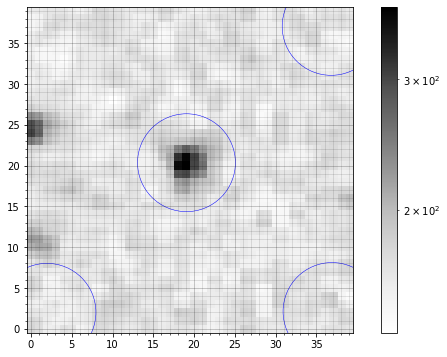

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 1.9569061 2.0135426 0.46915237 ... 173.06937 3.1193802 -1.2351708        1
  2 36.910976 2.1132588 0.46699145 ...  177.1275 3.2029624 -1.2638796        2
  3 19.063594 20.360352 0.58155803 ...  375.5997 4.5613484 -1.6477331        3
  4 36.804067  37.07647 0.47156711 ... 174.31715 3.1802397 -1.2561496        4


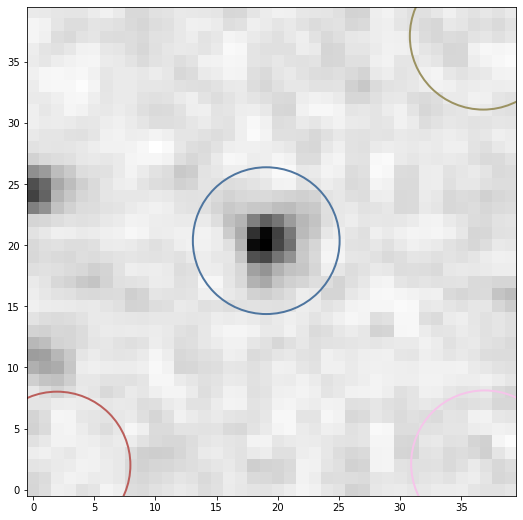

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.07290440000008402s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 1.9569061 2.0135426 -117.61256   1 ... -85.251941 44.744967             1
 36.910976 2.1132588  163.29441   2 ...  113.89746 45.822904             1
 19.063594 20.360352  3160.6501   3 ...  3095.7185 54.673559             1
 36.804067  37.07647 -69.392508   4 ... -25.204869  53.51502             1
 1.1965491 10.659238  661.92985   5 ...  833.00046 41.003743             2
0.77038209 24.484201  1254.6415   7 ...  1603.1218 48.613408             2


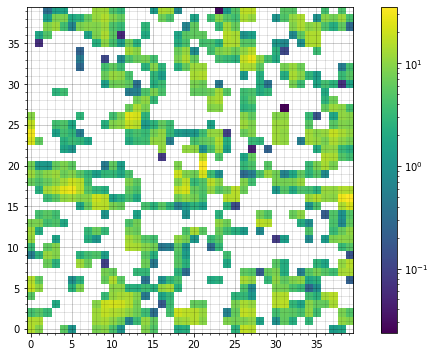

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  1.9569061 2.0135426          nan         nan
  2        2             1  36.910976 2.1132588    19.910181  0.43780813
  3        3             1  19.063594 20.360352    16.324562 0.035219078
  4        4             1  36.804067  37.07647          nan         nan
  5        1             2  1.1965491 10.659238    17.749853 0.061065568
  7        2             2 0.77038209 24.484201    17.039049 0.044234498
first match table:
 id  xcenter    ycenter    mag_e4     err_e4  
--- ---------- --------- --------- -----------
  1  1.9569061 2.0135426       nan         nan
  2  36.910976 2.1132588 19.910181  0.43780813
  3  19.063594 20.360352 16.324562 0.035219078
  4  36.804067  37.07647       nan         nan
  5  1.1965491 10.659238 17.749853 0.061065568
  7 0.77038209 24.484201 17.039049 0.044234498
id_master    x_0     

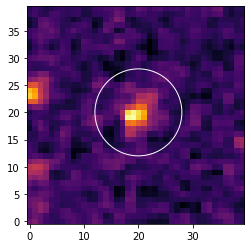

Mean: 165.45388793945312
Median: 163.77723693847656
Std dev: 11.403810501098633
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 19.372785942898552 ... 3.552034297685023 -1.3761928764540734
  2 2.2415053119165997 ... 2.785269268869566  -1.112167968551096
  3  36.79832871220264 ... 2.652389111083221  -1.059093090810136
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 19.372785942898552 ... 3.552034297685023 -1.3761928764540734
  2 2.2415053119165997 ... 2.785269268869566  -1.112167968551096
  3  36.79832871220264 ... 2.652389111083221  -1.059093090810136
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


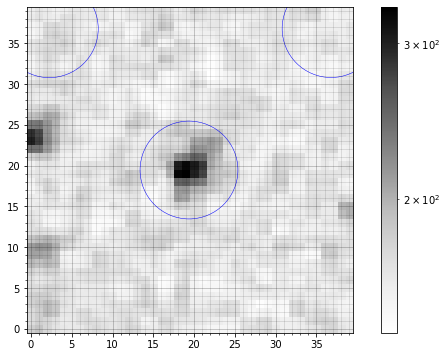

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 19.372786 19.463798 0.54187461 ... 330.24704 3.5520343 -1.3761929        1
  2 2.2415053 36.795119 0.46623956 ... 166.77907 2.7852693  -1.112168        2
  3 36.798329 36.810049 0.43645981 ... 157.42886 2.6523891 -1.0590931        3


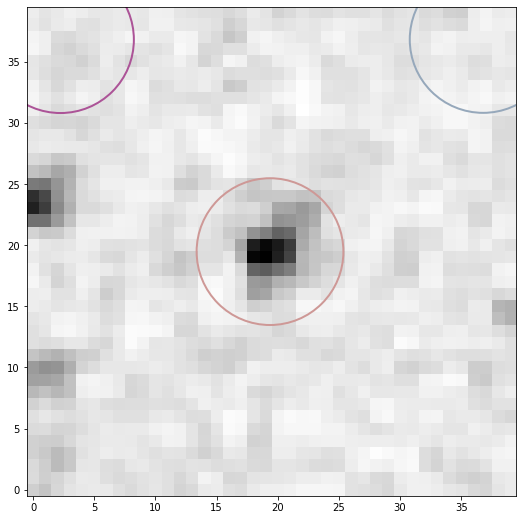

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.058494899999914196s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 19.372786 19.463798  3432.9365   1 ...  2695.6936 84.877579             1
 2.2415053 36.795119  147.55447   2 ...  144.81265 37.621129             1
 36.798329 36.810049 -93.987346   3 ... -43.717994 38.971682             1
 1.3826522   9.63022  859.37929   4 ...  868.22982  45.32885             2
0.95523738 23.582023  1506.6278   6 ...  1773.2248 52.545522             2


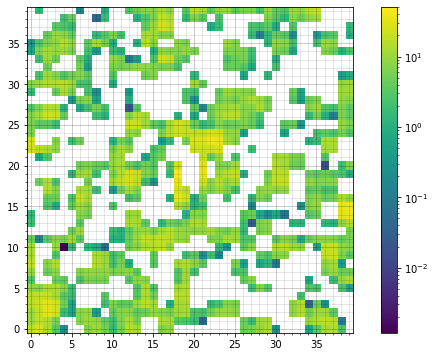

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  19.372786 19.463798    16.474885 0.045181512
  2        2             1  2.2415053 36.795119    19.649545  0.28360804
  3        3             1  36.798329 36.810049          nan         nan
  4        1             2  1.3826522   9.63022    17.704974 0.063920476
  6        2             2 0.95523738 23.582023    16.929652 0.043678586
first match table:
 id  xcenter    ycenter    mag_e5     err_e5  
--- ---------- --------- --------- -----------
  1  19.372786 19.463798 16.474885 0.045181512
  2  2.2415053 36.795119 19.649545  0.28360804
  3  36.798329 36.810049       nan         nan
  4  1.3826522   9.63022 17.704974 0.063920476
  6 0.95523738 23.582023 16.929652 0.043678586
id_master    x_0        y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- ---------- --------- --------- ... ----------- -----

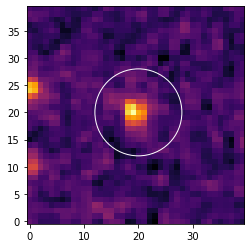

Mean: 164.86114501953125
Median: 163.99859619140625
Std dev: 10.768352508544922
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1    2.0102579964424 ... 3.2528959015706764 -1.2806754132793245
  2  36.80575554440408 ...  3.025499760017731 -1.2019928070506578
  3 19.208330883183734 ...  3.701874802870506 -1.4210543171457286
  4  2.090747349658983 ...  3.367481925104598 -1.3182631833346992
  5 36.960134368831206 ... 3.2738345958750457  -1.287641834365616
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1    2.0102579964424 ... 3.2528959015706764 -1.2806754132793245
  2  36.80575554440408 ...  3.025499760017731 -1.2019928070506578
  3 19.208330883183734 ...  3.701874802870506 -1.4210543171457286
  4  2.090747349658983 ...  3.367481925104598 -1.3182631833346992
  5 36.960134368831206 ... 3.27383

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


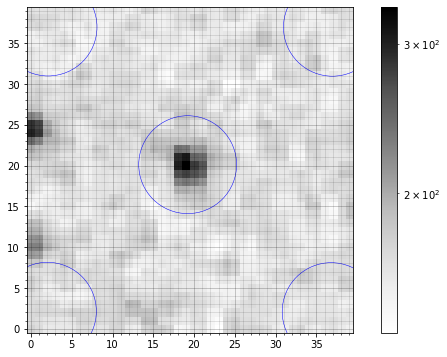

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1  2.010258   2.14149  0.4159398 ... 166.68643 3.2528959 -1.2806754        1
  2 36.805756 2.0997039  0.4403395 ... 161.83003 3.0254998 -1.2019928        2
  3 19.208331 20.120595 0.58154455 ... 331.94308 3.7018748 -1.4210543        3
  4 2.0907473 36.998027 0.43655768 ... 170.65184 3.3674819 -1.3182632        4
  5 36.960134 36.968362 0.43277519 ...  166.3364 3.2738346 -1.2876418        5


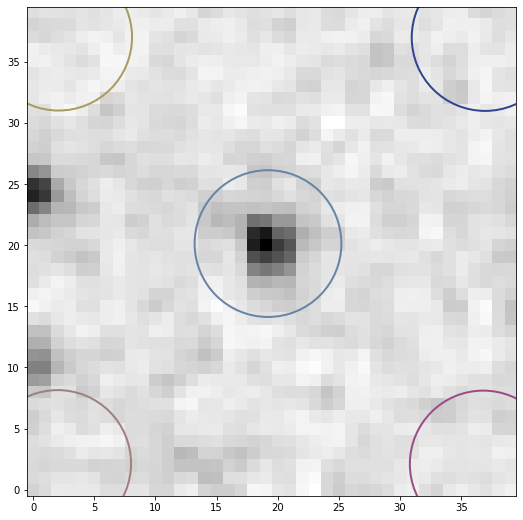

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.0903154000000086s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
  2.010258   2.14149  135.49158   1 ...  69.810222 41.712553             1
 36.805756 2.0997039 -14.619235   2 ... -60.781869 42.107454             1
 19.208331 20.120595  2966.3133   3 ...  2685.5559 69.570871             1
 2.0907473 36.998027 -312.88567   4 ... -16.766047 49.160856             1
 36.960134 36.968362 -150.69145   5 ... -113.74961  45.10514             1
0.78652745  24.26348  1476.0191   6 ...  1693.6178 52.574373             2


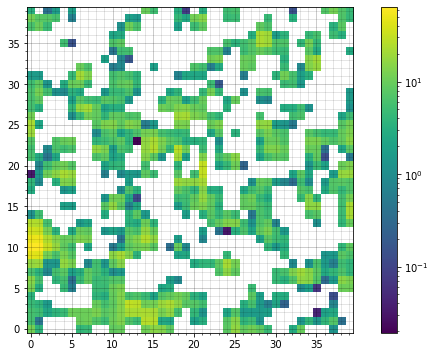

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   2.010258   2.14149    20.441699  0.64941433
  2        2             1  36.805756 2.0997039          nan         nan
  3        3             1  19.208331 20.120595    16.478911 0.040789723
  4        4             1  2.0907473 36.998027          nan         nan
  5        5             1  36.960134 36.968362          nan         nan
  6        1             2 0.78652745  24.26348    16.979458 0.044818104
first match table:
 id  xcenter    ycenter    mag_e6     err_e6  
--- ---------- --------- --------- -----------
  1   2.010258   2.14149 20.441699  0.64941433
  2  36.805756 2.0997039       nan         nan
  3  19.208331 20.120595 16.478911 0.040789723
  4  2.0907473 36.998027       nan         nan
  5  36.960134 36.968362       nan         nan
  6 0.78652745  24.26348 16.979458 0.044818104
id_master    x_0     

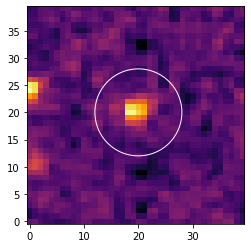

Mean: 168.88697814941406
Median: 168.2381134033203
Std dev: 11.189866065979004
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1934363339148795 ... 2.7900060496284356 -1.1140128624110537
  2  19.32954569103575 ... 3.1869743171589042 -1.2584464091070566
  3  36.85963684089836 ... 2.9356698368830476  -1.169268026541061
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.1934363339148795 ... 2.7900060496284356 -1.1140128624110537
  2  19.32954569103575 ... 3.1869743171589042 -1.2584464091070566
  3  36.85963684089836 ... 2.9356698368830476  -1.169268026541061
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


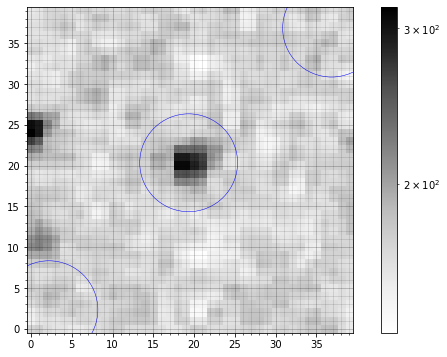

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 2.1934363 2.3321624 0.41147523 ...  159.3746  2.790006 -1.1140129        1
  2 19.329546 20.354094 0.51001748 ... 309.86359 3.1869743 -1.2584464        2
  3 36.859637 36.865028 0.46821937 ... 171.77594 2.9356698  -1.169268        3


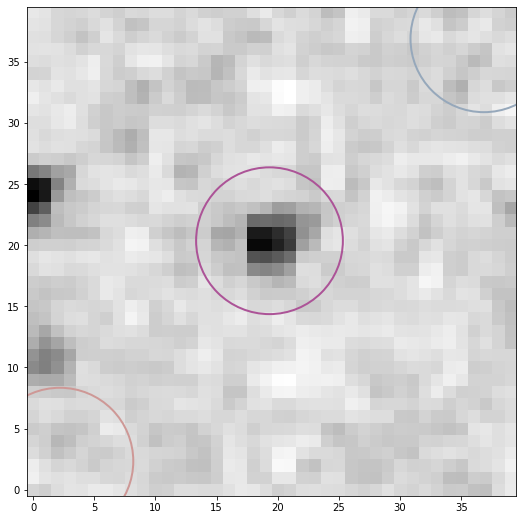

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06939790000001267s
   x_0        y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
---------- --------- --------- --- ... --------- --------- -------------
 2.1934363 2.3321624  31.61474   1 ... 70.101802 44.877389             1
 19.329546 20.354094 2543.1145   2 ... 2344.7804 65.758147             1
 36.859637 36.865028 122.02161   3 ... 20.191523 50.461988             1
  1.238768  10.72109 798.75963   4 ... 838.36206 38.353375             2
0.71615677 24.263156 1260.4878   6 ... 1840.6112 62.083196             2


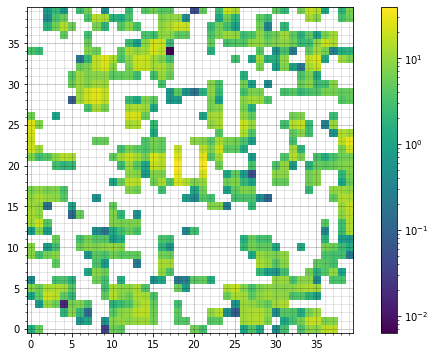

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  2.1934363 2.3321624    20.437096  0.69568818
  2        2             1  19.329546 20.354094    16.626163 0.042424411
  3        3             1  36.859637 36.865028    21.788496   2.7135969
  4        1             2   1.238768  10.72109     17.74284 0.057791243
  6        2             2 0.71615677 24.263156    16.889013 0.047051356
first match table:
 id  xcenter    ycenter    mag_e7     err_e7  
--- ---------- --------- --------- -----------
  1  2.1934363 2.3321624 20.437096  0.69568818
  2  19.329546 20.354094 16.626163 0.042424411
  3  36.859637 36.865028 21.788496   2.7135969
  4   1.238768  10.72109  17.74284 0.057791243
  6 0.71615677 24.263156 16.889013 0.047051356
id_master    x_0        y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- ---------- --------- --------- ... ----------- -----

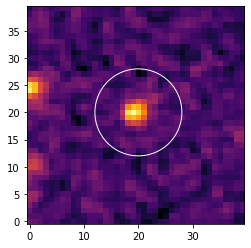

Mean: 162.76312255859375
Median: 161.9811248779297
Std dev: 10.223804473876953
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.0112050999188416 ...   3.20310145598764 -1.2639267371354892
  2  19.31491497726014 ... 3.6025954103168836 -1.3915387284863658
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2.0112050999188416 ...   3.20310145598764 -1.2639267371354892
  2  19.31491497726014 ... 3.6025954103168836 -1.3915387284863658
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


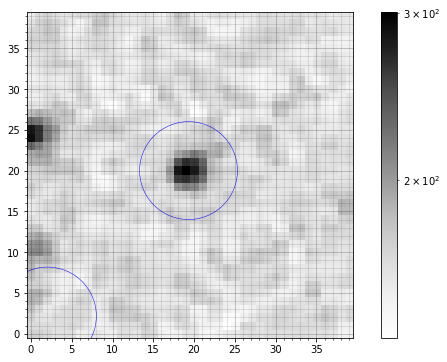

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 2.0112051 2.1720895 0.42724106 ... 164.24232 3.2031015 -1.2639267        1
  2 19.314915 20.005554 0.52674787 ... 300.71866 3.6025954 -1.3915387        2


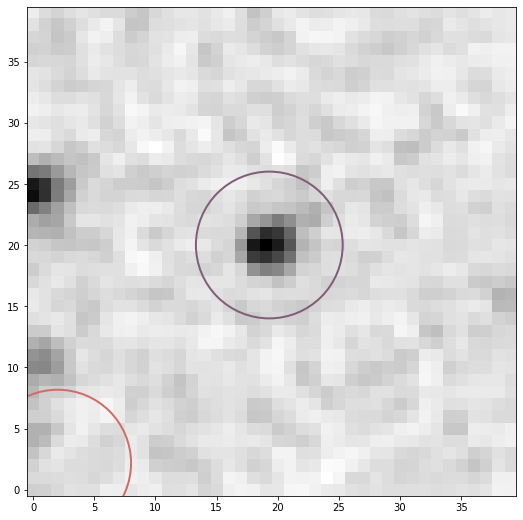

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.05317700000000514s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
2.0112051 2.1720895 133.51198   1 ... 56.916073  56.55078             1
19.314915 20.005554 2156.5727   2 ... 2252.4138 51.394718             1
 1.024357 10.330821 643.25761   3 ... 735.07757 47.879312             2


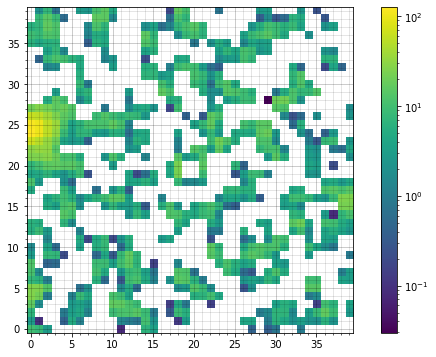

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.0112051 2.1720895    20.663349   1.0791723
  2        2             1 19.314915 20.005554    16.669816 0.038554396
  3        1             2  1.024357 10.330821    17.885603 0.076641629
first match table:
 id  xcenter   ycenter    mag_e8     err_e8  
--- --------- --------- --------- -----------
  1 2.0112051 2.1720895 20.663349   1.0791723
  2 19.314915 20.005554 16.669816 0.038554396
  3  1.024357 10.330821 17.885603 0.076641629
id_master    x_0        y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  2.0318106 2.1866823 847.45976 ...  0.64941433 20.437096  0.69568818
        1   19.47717  19.80043 864.90512 ... 0.040789723 16.626163 0.042424411
        2  36.873317 36.898459 882.30126 ...         nan 21.788496   2.7135

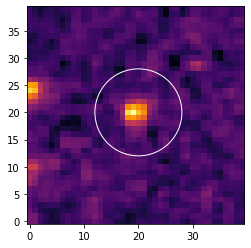

Mean: 163.3524169921875
Median: 162.75460815429688
Std dev: 10.684825897216797
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.8311948199145842 ... 3.4683545994808447 -1.3503087317603963
  2  19.30310218679817 ... 3.9913835550288215 -1.5028086591171939
  3  36.90723376589882 ... 3.1461150516019947 -1.2444365011872185
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.8311948199145842 ... 3.4683545994808447 -1.3503087317603963
  2  19.30310218679817 ... 3.9913835550288215 -1.5028086591171939
  3  36.90723376589882 ... 3.1461150516019947 -1.2444365011872185
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


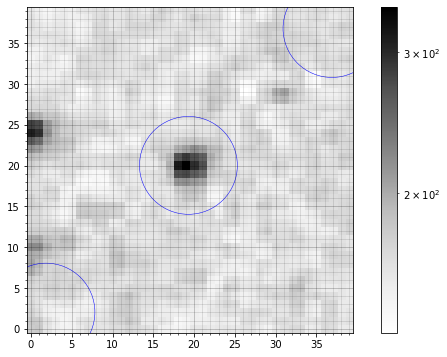

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 1.8311948 2.0392589 0.48033292 ... 179.26323 3.4683546 -1.3503087        1
  2 19.303102 20.031562 0.61298575 ... 342.27002 3.9913836 -1.5028087        2
  3 36.907234 36.817801 0.40064145 ... 160.04292 3.1461151 -1.2444365        3


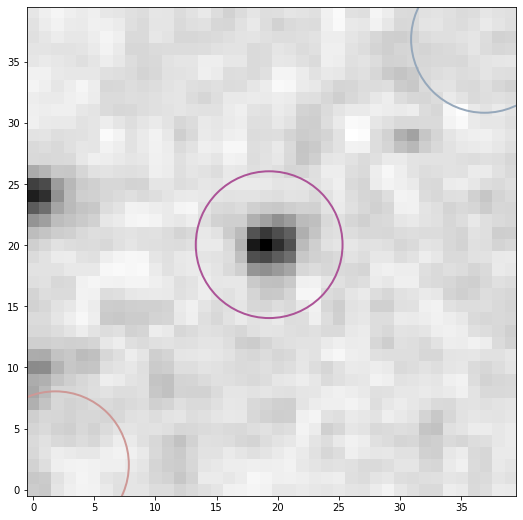

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06399129999999786s
   x_0        y_0      flux_0   id ...  flux_fit   flux_unc iter_detected
---------- --------- --------- --- ... ---------- --------- -------------
 1.8311948 2.0392589 113.36892   1 ... -33.409372 65.486119             1
 19.303102 20.031562 2276.0732   2 ...  2671.4292 60.232606             1
 36.907234 36.817801 115.52261   3 ...  29.463116 27.430964             1
 1.0180204 9.7844628 848.00597   4 ...  815.76608 53.324335             2
0.84059441 23.998811 1420.3552   6 ...  1876.2414  54.01317             2


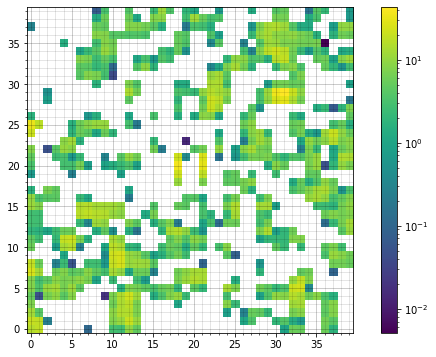

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  1.8311948 2.0392589          nan         nan
  2        2             1  19.303102 20.031562    16.484596 0.038366229
  3        3             1  36.907234 36.817801    21.378259   1.0112816
  4        1             2  1.0180204 9.7844628    17.772542 0.076874259
  6        2             2 0.84059441 23.998811    16.868234 0.043007449
first match table:
 id  xcenter    ycenter    mag_e9     err_e9  
--- ---------- --------- --------- -----------
  1  1.8311948 2.0392589       nan         nan
  2  19.303102 20.031562 16.484596 0.038366229
  3  36.907234 36.817801 21.378259   1.0112816
  4  1.0180204 9.7844628 17.772542 0.076874259
  6 0.84059441 23.998811 16.868234 0.043007449
id_master    x_0        y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- ---------- --------- --------- ... ----------- -----

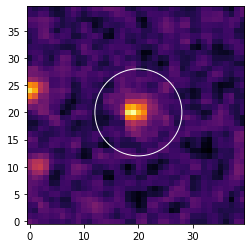

Mean: 162.076171875
Median: 161.27224731445312
Std dev: 10.546544075012207
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 36.98149995370742 ... 3.1212567265165423 -1.2358237282350095
  2 19.27005643427134 ... 3.8621322062372307 -1.4670678405275026
  3 36.89988035092527 ... 3.1489455339795276 -1.2454128722195668
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 36.98149995370742 ... 3.1212567265165423 -1.2358237282350095
  2 19.27005643427134 ... 3.8621322062372307 -1.4670678405275026
  3 36.89988035092527 ... 3.1489455339795276 -1.2454128722195668
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


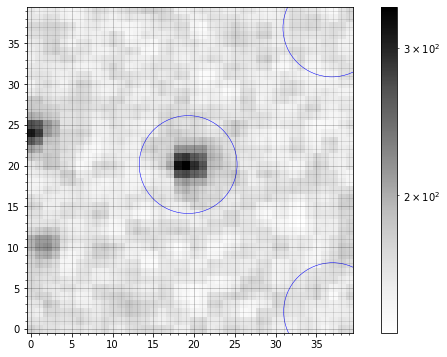

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1   36.9815 2.0937924  0.4435589 ... 161.55193 3.1212567 -1.2358237        1
  2 19.270056 20.134186  0.6133119 ... 335.70172 3.8621322 -1.4670678        2
  3  36.89988 36.886506 0.44820546 ... 165.35909 3.1489455 -1.2454129        3


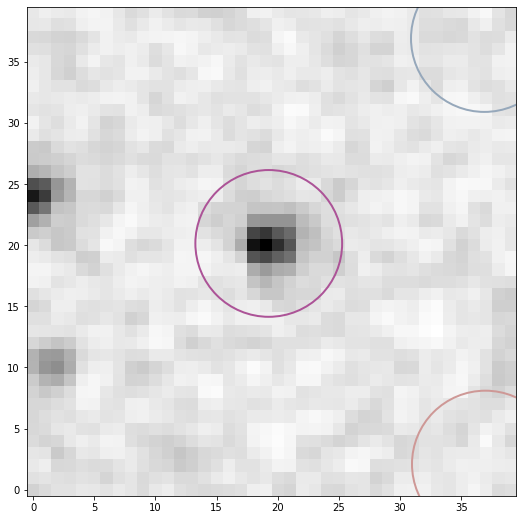

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.059441100000071856s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
   36.9815 2.0937924 -19.122513   1 ... -108.33369 32.215635             1
 19.270056 20.134186  2836.1836   2 ...  2675.5556 56.518015             1
  36.89988 36.886506  43.423064   3 ...  57.497074 39.556197             1
 1.5298997 10.265032  663.18829   4 ...  845.91785 42.146052             2
0.83042824 24.101325  1564.8607   6 ...  1807.2485 56.968867             2


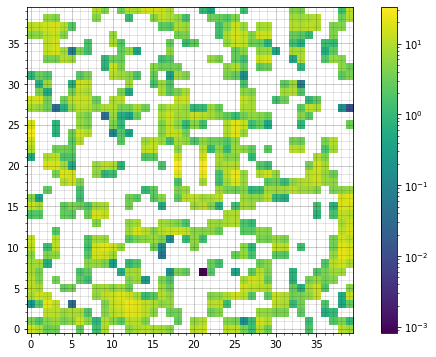

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1    36.9815 2.0937924          nan         nan
  2        2             1  19.270056 20.134186    16.482857 0.037399267
  3        3             1   36.89988 36.886506    20.652278  0.74753665
  4        1             2  1.5298997 10.265032    17.733071 0.061635286
  6        2             2 0.83042824 24.101325    16.908847 0.045211153
first match table:
 id  xcenter    ycenter   mag_e10    err_e10  
--- ---------- --------- --------- -----------
  1    36.9815 2.0937924       nan         nan
  2  19.270056 20.134186 16.482857 0.037399267
  3   36.89988 36.886506 20.652278  0.74753665
  4  1.5298997 10.265032 17.733071 0.061635286
  6 0.83042824 24.101325 16.908847 0.045211153
id_master    x_0        y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- ---------- --------- --------- ... ----------- -----

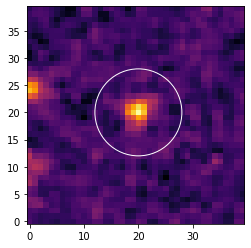

Mean: 162.5006103515625
Median: 161.44093322753906
Std dev: 11.754483222961426
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  37.04180477710645 ...   2.86672694316345 -1.1434658205028414
  2  19.86990364284779 ... 3.8980041053470518 -1.4771057304433808
  3 36.962201146463336 ...  3.051486653192632 -1.2112786868723888
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  37.04180477710645 ...   2.86672694316345 -1.1434658205028414
  2  19.86990364284779 ... 3.8980041053470518 -1.4771057304433808
  3 36.962201146463336 ...  3.051486653192632 -1.2112786868723888
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


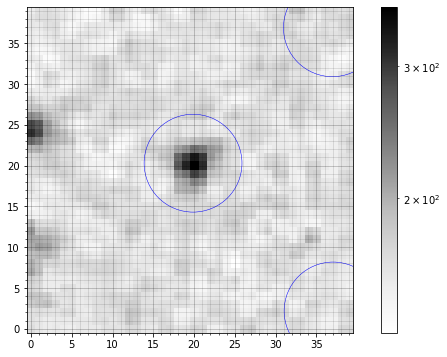

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 37.041805 2.1749942 0.43031481 ... 162.44652 2.8667269 -1.1434658        1
  2 19.869904 20.300349 0.61016782 ... 360.24564 3.8980041 -1.4771057        2
  3 36.962201 36.910961 0.43883572 ... 171.91022 3.0514867 -1.2112787        3


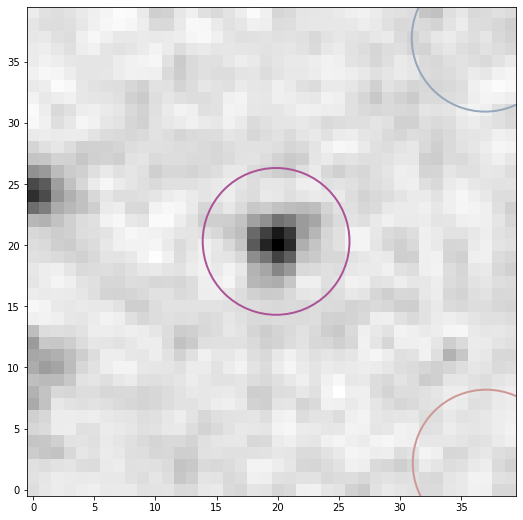

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06480379999993602s
   x_0        y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
---------- --------- ---------- --- ... ---------- --------- -------------
 37.041805 2.1749942 -101.62646   1 ... -62.390304  40.76292             1
 19.869904 20.300349  2960.0664   2 ...  2779.8619 72.692083             1
 36.962201 36.910961  122.83434   3 ...  97.868564 57.691803             1
 1.2142691 10.293183  680.06683   4 ...  878.67746 61.561657             2
0.89037568 24.234191  1563.3769   6 ...  1855.4304 55.691398             2


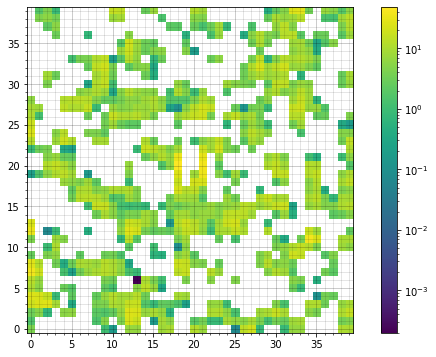

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  37.041805 2.1749942          nan         nan
  2        2             1  19.869904 20.300349    16.441348 0.040972813
  3        3             1  36.962201 36.910961    20.074798  0.64070387
  4        1             2  1.2142691 10.293183    17.691832 0.081603425
  6        2             2 0.89037568 24.234191    16.880294  0.04398547
first match table:
 id  xcenter    ycenter   mag_e11    err_e11  
--- ---------- --------- --------- -----------
  1  37.041805 2.1749942       nan         nan
  2  19.869904 20.300349 16.441348 0.040972813
  3  36.962201 36.910961 20.074798  0.64070387
  4  1.2142691 10.293183 17.691832 0.081603425
  6 0.89037568 24.234191 16.880294  0.04398547
id_master    x_0        y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- ---------- --------- --------- ... ----------- -----

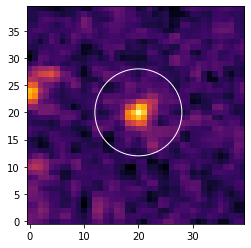

Mean: 162.4102020263672
Median: 160.81454467773438
Std dev: 11.937341690063477
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 2.081418911213272 ...  3.132363182825083 -1.2396802767857844
  2 36.81965158622114 ...  2.622915220485396  -1.046960633194896
  3 20.00120082913342 ... 3.5449746224227185 -1.3740328263144785
  4 36.72231391590386 ... 2.5944876278316653 -1.0351290101084423
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 2.081418911213272 ...  3.132363182825083 -1.2396802767857844
  2 36.81965158622114 ...  2.622915220485396  -1.046960633194896
  3 20.00120082913342 ... 3.5449746224227185 -1.3740328263144785
  4 36.72231391590386 ... 2.5944876278316653 -1.0351290101084423
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


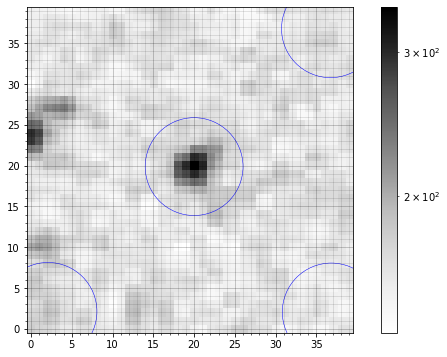

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 2.0814189 2.1236704 0.41912543 ... 177.09442 3.1323632 -1.2396803        1
  2 36.819652 2.0534938 0.45202253 ...  157.6619 2.6229152 -1.0469606        2
  3 20.001201 19.884105 0.57461664 ... 340.59824 3.5449746 -1.3740328        3
  4 36.722314 36.793596 0.42120301 ... 157.14795 2.5944876  -1.035129        4


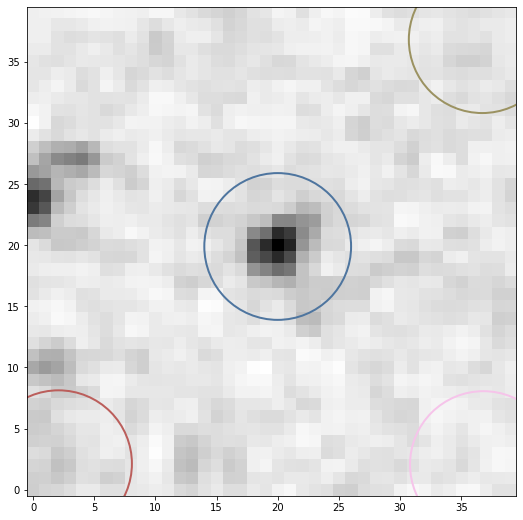

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06900399999994988s
   x_0       y_0      flux_0    id ...  flux_fit   flux_unc iter_detected
--------- --------- ---------- --- ... ---------- --------- -------------
2.0814189 2.1236704  610.97415   1 ...  450.34935 50.911757             1
36.819652 2.0534938 -241.26535   2 ... -122.69231 41.328221             1
20.001201 19.884105  3333.4113   3 ...     2751.5 84.856236             1
36.722314 36.793596  192.03836   4 ...  124.51478 34.623633             1
1.5657614 9.9527906  642.38612   5 ...  771.69003 51.685014             2


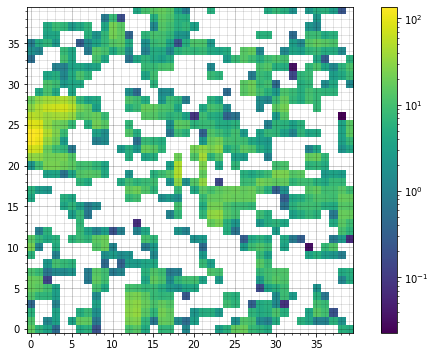

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.0814189 2.1236704    18.415949  0.12624686
  2        2             1 36.819652 2.0534938          nan         nan
  3        3             1 20.001201 19.884105      16.4509 0.044652875
  4        4             1 36.722314 36.793596    19.811771  0.30335084
  5        1             2 1.5657614 9.9527906    17.831216 0.078490147
first match table:
 id  xcenter   ycenter   mag_e12    err_e12  
--- --------- --------- --------- -----------
  1 2.0814189 2.1236704 18.415949  0.12624686
  2 36.819652 2.0534938       nan         nan
  3 20.001201 19.884105   16.4509 0.044652875
  4 36.722314 36.793596 19.811771  0.30335084
  5 1.5657614 9.9527906 17.831216 0.078490147
id_master    x_0        y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- ---------- --------- --------- ... ----------- --------- ---------

<Table length=5>
star_name   id_master        RA    ...         IQR               chi_sq      
  str10       int32       float64  ...       float64            float64      
--------- -------------- --------- ... ------------------- ------------------
     RRL0              3  346.6731 ... 0.14524234763840127 140.85730015112927
     RRL1              2  346.6853 ... 0.36570248475341316 240.39049484596677
     RRL2              2  346.6796 ...  0.2919240254844411 175.80550913961633
     RRL3              1 346.70346 ... 0.13741286593406343  92.49132931509716
     RRL4 -2.1474836e+09       nan ...                 nan                nan

In [14]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

big_table = Table()  # initialising the table we'll dump each RRL's data into
# Ideal order for column names (also used to initialise blank rows for missing stars):
new_order = ['star_name', 'id_master', 'RA', 'dec', 'x_0', 'y_0', 'x_true', 'y_true', 'mag_e1', 'err_e1', 'mag_e2', 'err_e2', 'mag_e3', 'err_e3', 'mag_e4', 'err_e4', 'mag_e5', 'err_e5', 'mag_e6', 'err_e6', 'mag_e7', 'err_e7', 'mag_e8', 'err_e8', 'mag_e9', 'err_e9', 'mag_e10', 'err_e10', 'mag_e11', 'err_e11', 'mag_e12', 'err_e12', 'eta_inv', 'IQR', 'chi_sq']

for star in range(len(tbl_CC)):
    
    #star = 1
    
    if star in starlist:
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')
        print_table_nicely(master_table)
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+cluster+'__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                #sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found again :(')          
                
                try:
                    pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                except TypeError:
                    print('type error :(((')
                    
                    mag_name = 'mag_e'+str(epoch)
                    err_name = 'err_e'+str(epoch)
                    master_table[mag_name] = float('NaN')
                    master_table[err_name] = float('NaN')
                    
                    epoch += 1
                    continue
                
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                
                print('first match table:')
                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d < max_sep)
            match_table = match_table[selection]
            comp_table = comp_table[idx[selection]]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)
            
            print_table_nicely(master_table)
            print_table_nicely(match_table)
            
            print(epoch)
            mag_name = 'mag_e'+str(epoch)
            err_name = 'err_e'+str(epoch)
            print(mag_name)
            
            print(master_table)
            print(match_table)
            
            try:
                master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            except ValueError:
                print('RRL not detected in this epoch :(')

                master_table[mag_name] = float('NaN')
                master_table[err_name] = float('NaN')

                epoch += 1
                continue
            
            #master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###
        
        ###   CALCULATING VARIABILITY INDICES AND AMPLITUDE FOR EACH STAR   ###
        
        masked_array = np.ma.array(np.zeros(len(master_table)), mask=True)
        master_table['eta_inv'] = masked_array
        master_table['IQR'] = masked_array
        master_table['chi_sq'] = masked_array

        master_table_f = copy.copy(master_table.filled(-99))
        print_table_nicely(master_table_f['mag_e1', 'err_e1', 'mag_e2', 'mag_e3', 'mag_e4'])

        for i in range(len(master_table_f)):
            #print(i)

            # Putting magnitudes into an array so we can play with them:
            mags = []
            errs = []
            for j in range(1,13):
                mags.append(master_table_f['mag_e'+str(j)][i])
                errs.append(master_table_f['err_e'+str(j)][i])

            mags = np.ma.array(mags)
            mags = np.ma.masked_where(mags == -99, mags)
            errs = np.ma.array(errs)
            errs = np.ma.masked_where(errs == -99, errs)

            if mags.compressed().size:    # doesn't calculate anything extra if the star has no magnitude data

                # Chi squared test:
                mean_sum1 = sum((m / e**2) for m, e in zip(mags.compressed(), errs.compressed()))
                mean_sum2 = sum((1. / e**2) for e in errs.compressed())
                mean_chi = mean_sum1 / mean_sum2

                chi_sq = sum(((m - mean_chi) / e)**2 for m, e in zip(mags.compressed(), errs.compressed()))
                master_table['chi_sq'][i] = chi_sq

                # IQR:
                mags_sorted = sorted(mags.compressed())
                if len(mags_sorted) > 5:  # finding IQR for fewer than 6 values is pointless really, and can cause issues
                    if len(mags_sorted) % 2 == 1:   # if odd number of entries, remove the median
                        mags_sorted.pop(int(len(mags_sorted)/2))

                    mags_split= np.array_split(mags_sorted, 2)
                    mags_lo = mags_split[0]
                    mags_hi = mags_split[1]

                    n = int(len(mags_lo) / 2)
                    q25 = (mags_lo[n-1] + mags_lo[n]) / 2
                    q75 = (mags_hi[n-1] + mags_hi[n]) / 2
                    iqr = q75 - q25
                    master_table['IQR'][i] = iqr

                # von Neumann index:
                # (VERY important this is run LAST out of all the indices, otherwise 'continue' may skip them)
                var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)
                diff = 0
                for k in range(len(mags.compressed()) - 1):
                    diff += (mags.compressed()[k+1] - mags.compressed()[k])**2
                if (len(mags.compressed()) - 1) == 0:
                    continue
                mssd = diff / (len(mags.compressed()) - 1)
                if mssd == 0. or var == 0.:
                    continue
                eta_inv = var / mssd
                master_table['eta_inv'][i] = eta_inv
        
        ###   KEEPING ONLY THE RRL   ###

        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        
        master_table['star_name'] = str('not an RRL')
        master_table['star_name'][star_id] = 'RRL'+str(star)

        master_table = master_table[new_order]
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()
                

        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    
    else:  # i.e. if not in starlist
        
        master_table = Table(data=np.full(shape=len(master_table), fill_value=np.nan, dtype=big_table.dtype), names=new_order, masked=True)
        master_table['star_name'] = 'RRL'+str(star)
        
    
    big_table = vstack([big_table, master_table[star_id]])    
    
    #if star == 1:
    #    break
        
    
    ###   END OF STAR LOOP   ###

save_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table, pickle_out)
pickle_out.close()

big_table

In [15]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
#load_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

big_table

<Table length=5>
star_name   id_master        RA    ...         IQR               chi_sq      
  str10       int32       float64  ...       float64            float64      
--------- -------------- --------- ... ------------------- ------------------
     RRL0              3  346.6731 ... 0.14524234763840127 140.85730015112927
     RRL1              2  346.6853 ... 0.36570248475341316 240.39049484596677
     RRL2              2  346.6796 ...  0.2919240254844411 175.80550913961633
     RRL3              1 346.70346 ... 0.13741286593406343  92.49132931509716
     RRL4 -2.1474836e+09       nan ...                 nan                nan

In [14]:
loadname0 = 'phot_tables/'+cluster+'/individual/big_table_RRL0_'+method+'_'+channel+'.pickle'
loadname1 = 'phot_tables/'+cluster+'/individual/big_table_RRL1_'+method+'_'+channel+'.pickle'
loadname2 = 'phot_tables/'+cluster+'/individual/big_table_RRL2_'+method+'_'+channel+'.pickle'
loadname3 = 'phot_tables/'+cluster+'/individual/big_table_RRL3_'+method+'_'+channel+'.pickle'
loadname4 = 'phot_tables/'+cluster+'/individual/big_table_RRL4_'+method+'_'+channel+'.pickle'
loadname5 = 'phot_tables/'+cluster+'/individual/big_table_RRL5_'+method+'_'+channel+'.pickle'
loadname6 = 'phot_tables/'+cluster+'/individual/big_table_RRL6_'+method+'_'+channel+'.pickle'

pickle_in = open(loadname0, 'rb')
RRL0 = pickle.load(pickle_in)
pickle_in = open(loadname1, 'rb')
RRL1 = pickle.load(pickle_in)
pickle_in = open(loadname2, 'rb')
RRL2 = pickle.load(pickle_in)
pickle_in = open(loadname3, 'rb')
RRL3 = pickle.load(pickle_in)
pickle_in = open(loadname4, 'rb')
RRL4 = pickle.load(pickle_in)
pickle_in = open(loadname5, 'rb')
RRL5 = pickle.load(pickle_in)
pickle_in = open(loadname6, 'rb')
RRL6 = pickle.load(pickle_in)

In [15]:
RRL6

<Row index=1>
star_name id_master    x_0       y_0       RA        dec       mag_e1     err_e1     mag_e2     err_e2     mag_e3     err_e3     mag_e4     err_e4     mag_e5     err_e5     mag_e6     err_e6    mag_e7  err_e7   mag_e8     err_e8     mag_e9     err_e9    mag_e10   err_e10    mag_e11    err_e11    mag_e12    err_e12   eta_inv   IQR    chi_sq
  str10     int32    float64   float64  float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64   float64 float64  float64    float64    float64    float64    float64   float64    float64    float64    float64    float64   float64 float64 float64
--------- --------- --------- --------- -------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- ------- ------- --------- ----------- --------- ----------- --------- ---------- --------- ----------- --------- ----------- ------- ------- -------
     RRL6         1 20.254074 20.788959 229.0395 -0.27310464 16.264084 0.040842699 16.327979 0.041777398 15.987809 0.038611594 16.009818 0.047017224 15.981321 0.042920053 16.081061 0.047154087     nan     nan 16.141962 0.045662641 16.171013 0.042628169 16.427533 0.05394822 16.506283 0.049906758 16.016763 0.042596907     nan     nan     nan

### Run this to add Welch-Stetson variability index to huge_table:
Requires data from both channels, hence why this isn't in the main photometry cell

In [19]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'
load_name_normal = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)
pickle_in = open(load_name_normal, 'rb')
big_table = pickle.load(pickle_in)

'''ra1 = np.ma.masked_invalid(big_table_ch1['RA'])
dec1 = np.ma.masked_invalid(big_table_ch1['dec'])
ra2 = np.ma.masked_invalid(big_table_ch2['RA'])
dec2 = np.ma.masked_invalid(big_table_ch2['dec'])
print(ra1.compressed(), dec1.compressed(), ra2.compressed(), dec2.compressed())

cat_ch1 = SkyCoord(ra1.compressed(), dec1.compressed(), frame='icrs', unit='deg')
cat_ch2 = SkyCoord(ra2.compressed(), dec2.compressed(), frame='icrs', unit='deg')

idx, d2d, d3d = match_coordinates_sky(cat_ch1, cat_ch2)  # idx correspond to ch1

#print(len(idx))
#print(len(cat_ch1))

max_sep = 0.4 * u.arcsec  # looking at maximum distance between matching RA/dec coords, around 0.4 seems to work decently
selection = (d2d > max_sep)
match_index = idx
match_index[selection] = -99.
ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

big_table_ch1 = big_table_ch1[ind]
big_table_ch2 = big_table_ch2[match_index][ind]
#print(len(big_table_ch1))

id_list = np.arange(len(big_table_ch1))
big_table_ch1['id_match'] = id_list
big_table_ch2['id_match'] = id_list'''

masked_array = np.ma.array(np.zeros(len(big_table_ch1)), mask=True)
big_table_ch1['I_var'] = masked_array
big_table_ch2['I_var'] = masked_array

big_table_ch1_f = copy.copy(big_table_ch1.filled(-99))
big_table_ch2_f = copy.copy(big_table_ch2.filled(-99))

for i in range(len(big_table_ch1)):
    #print(i)
    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        mags_ch1.append(big_table_ch1_f['mag_e'+str(j)][i])
        mags_ch2.append(big_table_ch2_f['mag_e'+str(j)][i])
        errs_ch1.append(big_table_ch1_f['err_e'+str(j)][i])
        errs_ch2.append(big_table_ch2_f['err_e'+str(j)][i])

    mags_ch1 = np.ma.array(mags_ch1)
    mags_ch1 = np.ma.masked_where(mags_ch1 == -99, mags_ch1)
    mags_ch2 = np.ma.array(mags_ch2)
    mags_ch2 = np.ma.masked_where(mags_ch2 == -99, mags_ch2)
    errs_ch1 = np.ma.array(errs_ch1)
    errs_ch1 = np.ma.masked_where(errs_ch1 == -99, errs_ch1)
    errs_ch2 = np.ma.array(errs_ch2)
    errs_ch2 = np.ma.masked_where(errs_ch2 == -99, errs_ch2)
    
    m1_mean = np.mean(mags_ch1.compressed())
    m2_mean = np.mean(mags_ch2.compressed())
    n = len(mags_ch1)   # could also be len(mags_ch2)
    
    # probably need to do a for loop instead of list comprehension
    # check if number of mags in ch1 and ch2 list match; if not, don't calculate
    # doesn't guarantee that the mags are from the same epochs, even if the length matches; might need to only calculate for stars with 12 observations :/
    # unless we wanna get complicated and check that each list has values in the same places
    
    '''if len(mags_ch1.compressed()) == 12 and len(mags_ch2.compressed()) == 12:
        count += 1
        print('yay they are both big')
        
        I = sum((((m1-m1_mean)/e1) * ((m2-m2_mean)/e2)) for m1, m2, e1, e2 in zip(mags_ch1, mags_ch2, errs_ch1, errs_ch2)) * np.sqrt(1. / (n*(n-1)))

        print(len(mags_ch1.compressed()))
        print(len(mags_ch2.compressed()))
        print('I: ', I, '\n')

        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I'''
    
    I_prod = 0
    count_unmasked = 0
    
    for k in range(len(mags_ch1)):
        if np.ma.is_masked(mags_ch1[k]) == True:
            #print('ch1 is masked')
            continue
        elif np.ma.is_masked(mags_ch2[k]) == True:
            #print('ch2 is masked')
            continue
        else:
            #print('neither masked :)')
            count_unmasked += 1
            I_prod += ((mags_ch1[k] - m1_mean) / errs_ch1[k]) * ((mags_ch2[k] - m2_mean) / errs_ch2[k])
        
    #print('count unmasked: ', count_unmasked)
    if count_unmasked > 5:
        I = I_prod * np.sqrt(1. / n * (n - 1))
        #print('I: ', I)
        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I
    #else:
        #print('too few good values to calculate I :(')
    
    #print(big_table_ch1['I_var'][i])
    #print('\n')


big_table_var = join(big_table, big_table_ch1['star_name', 'I_var'], keys='star_name', join_type='left')

save_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_var, pickle_out)
pickle_out.close()

big_table_var

<Table length=5>
star_name   id_master        RA    ...       chi_sq             I_var       
  str10       int32       float64  ...      float64            float64      
--------- -------------- --------- ... ------------------ ------------------
     RRL0              2  346.6729 ... 111.85444170112387  55.10140186069721
     RRL1              1 346.68512 ...  66.47359364104582 -10.36989115738034
     RRL2              1 346.67961 ... 190.00167034331835 14.753241943006817
     RRL3 -2.1474836e+09       nan ...                nan                nan
     RRL4              0 346.65532 ...  20.12886223993589                nan

### Plotting light curves:

In [156]:
big_table_f

<Table length=7>
star_name   id_master        RA    ...       chi_sq              I_var        
  str10       int32       float64  ...      float64             float64       
--------- -------------- --------- ... ------------------ --------------------
     RRL0              2  228.9883 ...  40.74516374693197     7.15097866283335
     RRL1 -2.1474836e+09       nan ...                nan                  nan
     RRL2              1 229.05319 ...                nan                  nan
     RRL3 -2.1474836e+09       nan ...                nan                  nan
     RRL4              0 228.99257 ...   52.5539288907453    9.076202419186659
     RRL5              1 228.99621 ... 0.7589534478039934 -0.04090589973405752
     RRL6 -2.1474836e+09       nan ...                nan                  nan

C:\Users\Jake\anaconda3\lib\site-packages\numpy\ma\core.py:2794: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Mags:  [14.516806475585705 14.507735773473653 14.519659922717612
 14.527998250382511 14.508389422702887 14.543798887220706
 14.480350532848286 14.434938463115092 14.35849821241903 --
 14.43705656247148 14.506133937641682]
Errs:  [0.03730755310908264 0.03765347896090567 0.036657730484494146
 0.037750695025067206 0.037812513300922536 0.03365115859471479
 0.033065658666348766 0.038199765446631395 0.039895661338482276 --
 0.03993652520955716 0.04006497343624374]
Phase:  [0.2051844925736077 0.3130610883672489 0.42039154878875706
 0.5272050192288589 0.6417752211418701 0.7323592655011453
 0.8391788412554888 0.9494652345310897 0.05078009898716118 --
 0.2631567916541826 0.36738230955961626]


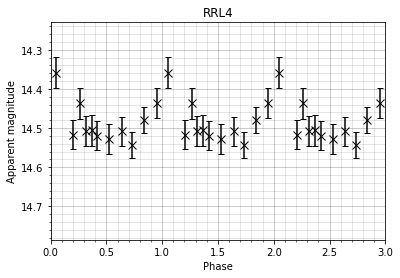

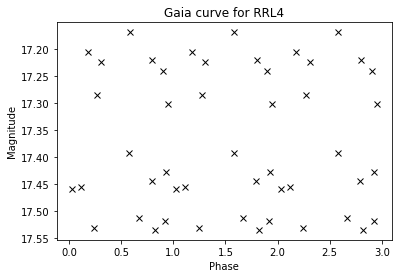

Chi squared:   20.12886223993589
IQR:           0.08223568635837353
Welch-Stetson: nan
von Neumann:   1.2035202999948489


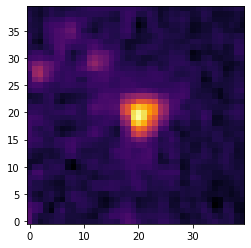

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


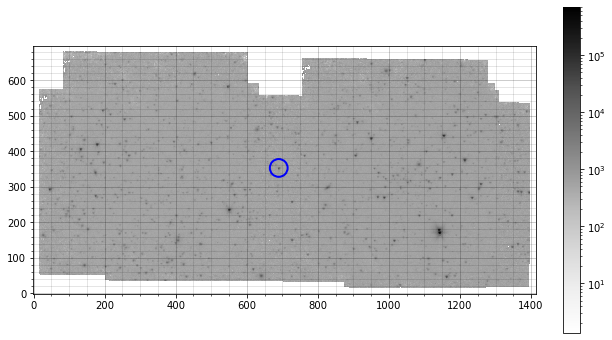

In [25]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

LC_time = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


###   FOR PLOTTING STAR FROM CATALOGUE   ###

###########
star_id = 4
###########

if star_id in starlist:

    file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
    df_CC = pd.read_csv(file_CC, sep=',', header=0)
    
    #c_CC = SkyCoord(df_CC['RA'][star_id], df_CC['dec'][star_id], frame='icrs', unit='deg')
    ra_temp = np.ma.masked_invalid(big_table['RA'])
    dec_temp = np.ma.masked_invalid(big_table['dec'])
    #c_comp = SkyCoord(ra_temp.compressed(), dec_temp.compressed(), frame='icrs', unit='deg')

    if df_CC['type'][star_id] == 'RR0':
        P = df_CC['period_fund'][star_id]
        print('RRab')
    elif df_CC['type'][star_id] == 'RR1':
        P = df_CC['period_FO'][star_id]
        print('RRc')
    elif df_CC['type'][star_id] == 'RR01':
        P = df_CC['period_FO'][star_id]

    temp = [i / P for i in LC_time]
    phase = temp - np.floor(temp)  


    #big_table_i = big
    big_table_f = copy.copy(big_table.filled(-99))

    mags = []
    errs = []
    for i in range(1,13):
        mags.append(big_table['mag_e'+str(i)][star_id])
        errs.append(big_table['err_e'+str(i)][star_id])

    ### Masking out a specific data point (only use in emergencies, or the Science Police will get you):

    #remove_pls = 5  # EPOCH number of bad point
    #mags[remove_pls-1] = -99
    #print(mags)

    ###

    mags = np.ma.array(mags)
    #mags = np.ma.masked_where(mags == -99, mags)
    mags = np.ma.masked_invalid(mags)
    errs = np.ma.masked_array(errs, mags.mask)
    phase = np.ma.masked_array(phase, mags.mask)
    print('Mags: ', mags)
    print('Errs: ', errs)
    print('Phase: ', phase)

    ###   PLOTTING LIGHT CURVES   ###

    mags_long = np.ma.concatenate((mags, mags, mags))  # this idea taken from some of vicky's code; credit?
    errs_long = np.ma.concatenate((errs, errs, errs))
    phase_long = np.ma.concatenate((phase, phase + 1., phase + 2.))

    plt.errorbar(phase_long, mags_long, yerr=errs_long, fmt='x', color='black', capsize=3, markersize=8)
    plt.ylim(np.ma.median(mags) - 1.5*(max(mags)-min(mags)), np.ma.median(mags) + 1.5*(max(mags)-min(mags)))
    plt.xlim(0, 3)
    plt.gca().invert_yaxis()
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.xlabel('Phase')
    plt.ylabel('Apparent magnitude')
    plt.title('RRL'+str(star_id))
    #plt.savefig('images/'+cluster+'/curves/'+method+'_'+channel+'_'+str(star_id)+'_'+str(model_epoch)+'.png', dpi=100)
    plt.show()

    ###   GAIA DR2 CURVE COMPARISON   ###

    vot_name = 'data/curves/proc_RRL'+str(star_id+1)+'.vot'

    if os.path.isfile(vot_name) == True:

        votable = parse_single_table(vot_name)
        data_vot = votable.array

        temp = [i / P for i in data_vot['obs_time']]
        phase_vot = temp - np.floor(temp)

        mags_vot = np.concatenate((data_vot['phot'], data_vot['phot'], data_vot['phot']))
        phases_vot = np.concatenate((phase_vot, phase_vot + 1., phase_vot + 2.))

        plt.plot(phases_vot, mags_vot, 'kx')
        plt.xlabel('Phase')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        plt.title('Gaia curve for RRL'+str(star_id))
        #plt.savefig('images/'+cluster+'/curves/gaia/RRL'+str(star_id+1), dpi=200)
        plt.show()

    ###   PRINTING VARIABILITY INFORMATION ETC.   ###

    print('Chi squared:  ', big_table['chi_sq'][star_id])
    print('IQR:          ', big_table['IQR'][star_id])
    print('Welch-Stetson:', big_table['I_var'][star_id])
    print('von Neumann:  ', big_table['eta_inv'][star_id])

    ###   PLOTTING IMAGE OF STAR FROM MASTER FRAME   ###

    star_r = 20
    star_x = int(big_table['x_true'][star_id])
    star_y = int(big_table['y_true'][star_id])
    star_ap = CircularAperture((star_x, star_y), r=25.)

    region = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
    plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
    #star_ap.plot(color='white')
    plt.show()

    plt.imshow(data_m, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
    star_ap.plot(color='blue', lw=2.)
    plt.colorbar(fraction = 0.05)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.gcf().set_size_inches(10, 6)
    plt.show()

    #plotting(data_m, star_ap, an=None, cmap='Greys', choice='ap_only', savename=None)
    
else:
    print("RRL"+str(star_id)+" isn't visible in this channel")

### Running GLOESS:

In [197]:
big_table_ch1

<Table length=7>
star_name   id_master        RA    ...         IQR               chi_sq      
  str10       int32       float64  ...       float64            float64      
--------- -------------- --------- ... ------------------- ------------------
     RRL0              2  228.9883 ... 0.12266601339165106  40.74516374693197
     RRL1 -2.1474836e+09       nan ...                 nan                nan
     RRL2              1 229.05319 ... 0.08364764593109086                nan
     RRL3 -2.1474836e+09       nan ...                 nan                nan
     RRL4              0 228.99257 ... 0.08597920367054357   52.5539288907453
     RRL5              1 228.99621 ... 0.06817544820642141 0.7589534478039934
     RRL6 -2.1474836e+09       nan ...                 nan                nan

Gaia DR2 ID: 2814894112367752192
RRab
Channel 1 mags:  [16.29653226 16.18078497 16.15552712 16.24061468 16.22299634 16.3038364
 16.40933156 16.49158667 16.45950768 16.40856012 16.40016724 16.43462807]
Channel 2 mags:  [16.58208685 16.54729614 16.4765704  16.49218665 16.47277796 16.34848464
 16.48932558 16.65774622 16.48375635 16.73676818 99.         17.01362127] 

RRL1 ---- Period = 0.5382 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.340    std dev = 0.078     amplitude = 0.233


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.546    std dev = 0.071     amplitude = 0.217
Channels don't have the same number of measurements, so colour curve couldn't be plotted


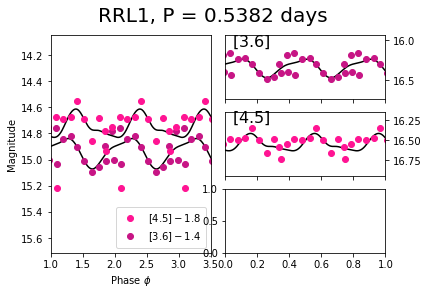




Gaia DR2 ID: 2814893910504602624
RRab
Channel 1 mags:  [16.26115084 16.29243448 16.14027683 16.1369379  16.0762595  16.10253508
 16.14999713 16.20566507 16.22379929 16.2436584  16.30552096 16.32784943]
Channel 2 mags:  [16.59081145 16.28891956 16.58462041 16.13953421 16.16752148 16.45601986
 16.59714338 16.15115501 16.15808028 16.18025994 99.         16.27638493] 

RRL2 ---- Period = 0.5971 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.190    std dev = 0.067     amplitude = 0.199


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.300    std dev = 0.079     amplitude = 0.275
Channels don't have the same number of measurements, so colour curve couldn't be plotted


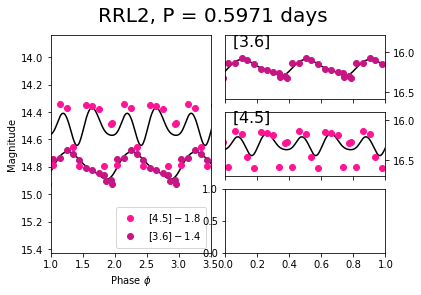




Gaia DR2 ID: 2814893910504601600
RRab
Channel 1 mags:  [16.24394974 16.39123666 16.2306936  16.19802459 16.14596607 16.1038507
 16.17059767 16.23223954 16.23996804 16.40407232 16.55397896 16.46958467]
Channel 2 mags:  [16.74005665 16.72319261 16.49849577 16.42644104 16.46856263 16.37412144
 16.25040931 16.69312548 16.56268041 16.2978364  99.         16.39569722] 

RRL3 ---- Period = 0.5782 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.254    std dev = 0.099     amplitude = 0.294


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.473    std dev = 0.065     amplitude = 0.212
Channels don't have the same number of measurements, so colour curve couldn't be plotted


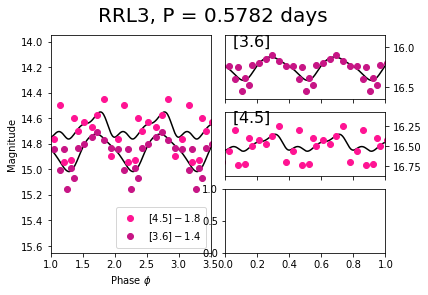




Gaia DR2 ID: 281188866652959232
RRab
Channel 1 mags:  []
Channel 2 mags:  [16.31055269 16.32612589 16.36650181 16.32456201 16.47488465 16.47891144
 16.62616324 16.66981596 16.48459646 16.48285697 16.44134805 16.45089951] 

RRL4 ---- Period = 0.5751 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.466    std dev = 0.095     amplitude = 0.271
Channels don't have the same number of measurements, so colour curve couldn't be plotted


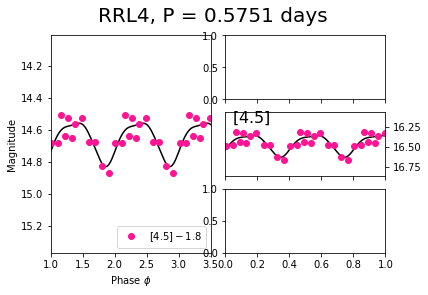

ID            RA          dec units  period_fund  period_FO  mean_mag_CC  \
0   1  23h06m41.53s  12d46m58.9s    R0       0.5382        NaN       17.886   
1   2  23h06m44.47s  12d46m16.1s    R0       0.5971        NaN       17.819   
2   3  23h06m43.14s  12d46m47.8s    R0       0.5782        NaN       17.766   
3   4  23h06m48.83s  12d41m22.3s    R0       0.5751        NaN       17.886   
4   5  23h06m37.28s  12d49m27.5s    R0       7.2600        NaN       17.029   

   amplitude colour type  ...  mean_mag_ch1  mean_mag_ch2  mean_std_ch1  \
0       0.80      V  RR0  ...     16.320341     16.529844      0.077507   
1       0.79      V  RR0  ...     16.169539     16.283591      0.067483   
2       0.83      V  RR0  ...     16.234037     16.457085      0.098964   
3       0.52      V  RR0  ...           NaN     16.447846           NaN   
4       0.40      V  SR?  ...           NaN           NaN           NaN   

  mean_std_ch2  mean_photerr_ch1  mean_photerr_ch2  period_used  period_PL  \
0     0.071236          0.035776          0.041661       0.5382     0.5382   
1     0.079066          0.033680          0.038039       0.5971     0.5971   
2     0.065240          0.033239          0.039526       0.5782     0.5782   
3     0.094605               NaN          0.039844       0.5751     0.5751   
4          NaN               NaN               NaN          NaN        NaN   

   A_ch1  A_ch2  
0  0.020  0.016  
1  0.020  0.016  
2  0.020  0.016  
3  0.022  0.018  
4    NaN    NaN  

[5 rows x 24 columns]

In [30]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC)):
    
    if df_CC['type'][star] == 'SR?':
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    if df_CC['gaia_ID'][star] != 0:
        id1 = df_CC['gaia_ID_1'][star]
        id2 = df_CC['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)
    
    c_CC = SkyCoord(df_CC['RA'][star], df_CC['dec'][star], frame='icrs', unit='deg')

    if df_CC['type'][star] == 'RR0':
        P = df_CC['period_fund'][star]
        P_PL = P
        print('RRab')
    elif df_CC['type'][star] == 'RR1':
        P = df_CC['period_FO'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC['type'][star] == 'RR01':
        P = df_CC['period_FO'][star]
        P_PL = P * 10**0.127
        print('RRd')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)

    #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    '''ch1_temp = [(1. / e**2) for e in errs_ch1]  # Monson 2017 approach
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)'''
    

    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
    
    print('\n\n')

df_CC['mean_mag_ch1'] = means_ch1
df_CC['mean_mag_ch2'] = means_ch2
df_CC['mean_std_ch1'] = stds_ch1
df_CC['mean_std_ch2'] = stds_ch2
df_CC['mean_photerr_ch1'] = photerr_mean_ch1
df_CC['mean_photerr_ch2'] = photerr_mean_ch2
df_CC['period_used'] = periods
df_CC['period_PL'] = periods_PL
df_CC['A_ch1'] = A_ch1
df_CC['A_ch2'] = A_ch2

df_CC


### Plotting PL relation:
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

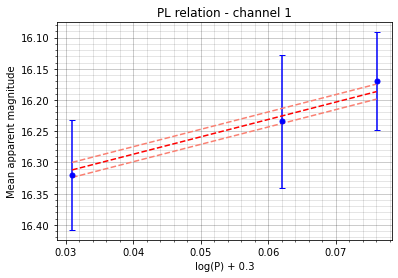

Intercept, a: 16.40
Error in a:    0.01
Std. dev.:     0.01

Distance modulus: 16.80 ± 0.03 (random) ± 0.12 (systematic)
Distance: 22.89 ± 0.33 (random) ± 1.24 (systematic) kpc




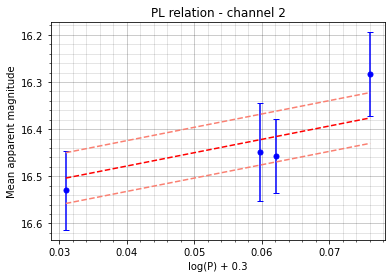

Intercept, a: 16.59
Error in a:    0.03
Std. dev.:     0.05

Distance modulus: 17.00 ± 0.04 (random) ± 0.12 (systematic)
Distance: 25.14 ± 0.50 (random) ± 1.40 (systematic) kpc


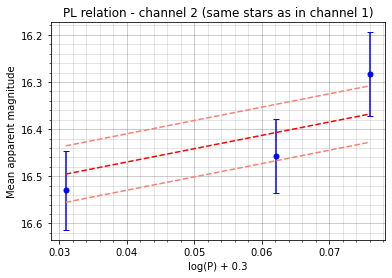

Intercept, a: 16.58
Error in a:    0.04
Std. dev.:     0.06

Distance modulus: 16.99 ± 0.05 (random) ± 0.12 (systematic)
Distance: 25.04 ± 0.60 (random) ± 1.39 (systematic) kpc


In [31]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(df_CC['period_PL'], means_ch1.mask)
periods_ch2 = np.ma.masked_array(df_CC['period_PL'], means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))

###   CHANNEL 2 PL (only stars that are also visible in channel 1)   ###

# Plotting only channel 2 stars also visible in channel 1:
means_ch2_1 = np.ma.masked_array(means_ch2, means_ch1.mask)
photerr_mean_ch2_1 = np.ma.masked_array(photerr_mean_ch2, means_ch1.mask)
stds_ch2_1 = np.ma.masked_array(stds_ch2, means_ch1.mask)
err_mean_ch2_1 = np.ma.masked_array(err_mean_ch2, means_ch1.mask)
periods_ch2_1 = np.ma.masked_array(periods_ch2, means_ch1.mask)

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2_1.compressed(), means_ch2_1.compressed())
intercept_ch2_1 = popt[0]
err_int_ch2_1 = np.sqrt(pcov[0][0])

devs_ch2_1 = [(m - PL_fit_ch2(p, intercept_ch2_1))**2 for m, p in zip(means_ch2_1.compressed(), periods_ch2_1.compressed())]
std_ch2_1 = np.sqrt(np.mean(devs_ch2_1))

plt.errorbar(np.log10(periods_ch2_1.compressed()) + 0.3, means_ch2_1.compressed(), yerr=err_mean_ch2_1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1), 'r--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 + std_ch2_1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 - std_ch2_1), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2 (same stars as in channel 1)')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2_1, err_int_ch2_1, std_ch2_1))

distmod_ch2_1 = intercept_ch2_1 - a_ch2
dist_ch2_1 = 10 ** ((distmod_ch2_1 / 5.) + 1.)

distmod_randerr_ch2_1 = np.sqrt(err_int_ch2_1**2 + aerr_ch2**2)
dist_randerr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_randerr_ch2_1)

distmod_syserr_ch2_1 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_syserr_ch2_1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2_1, distmod_randerr_ch2_1, distmod_syserr_ch2_1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2_1/1000, dist_randerr_ch2_1/1000, dist_syserr_ch2_1/1000))



#### Trying to get matching to master list based on coordinates working (but it won't and i am sad):
These aren't used any more but I'm keeping them around in case I need them

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL2_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
        1 10.402177 34.836456 229.05098 -0.16560569
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1343.18787331), array(75.13551432))


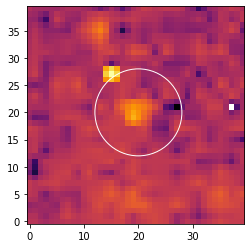

Mean: 55.818267822265625
Median: 53.148773193359375
Std dev: 21.55946159362793
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


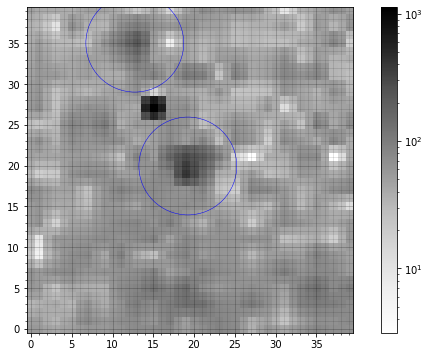

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.227897 19.956908 0.53458902 ... 357.69717 3.6291534  -1.3995133        1
  2 12.724014 35.022011 0.78328236 ... 218.59438 1.6044276 -0.51330033        2


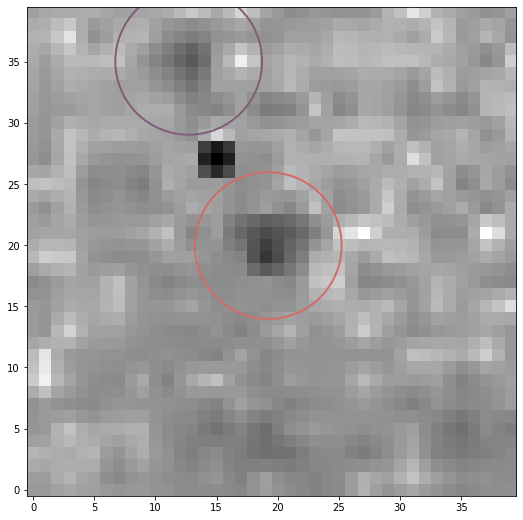

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.10932639999998628s
   x_0       y_0     flux_0   id ...   y_fit    flux_fit  flux_unc iter_detected
--------- --------- -------- --- ... --------- --------- --------- -------------
19.227897 19.956908 4822.526   1 ... 19.956908 4382.3119 123.23011             1
12.724014 35.022011 1350.585   2 ... 35.022011   1767.19 86.806252             1


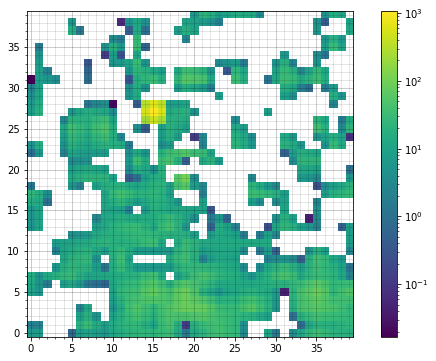

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.227897 19.956908    16.448818 0.042486303
  2        2             1 12.724014 35.022011    17.434868 0.060969787
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 19.227897 19.956908 16.448818 0.042486303
  2 12.724014 35.022011 17.434868 0.060969787
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05319478, -0.16745755), (229.0508948 , -0.16597776)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
       

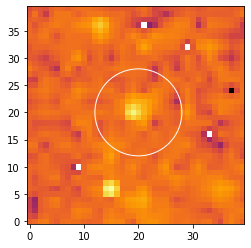

Mean: 48.83451843261719
Median: 46.608665466308594
Std dev: 19.045347213745117
yay all conditions check out
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


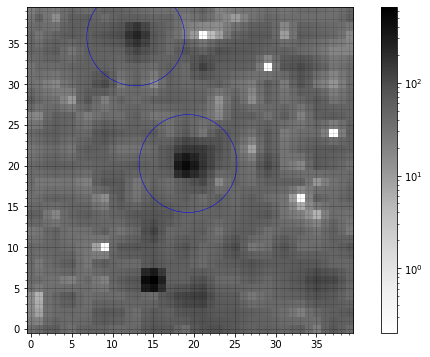

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.255515 20.258677 0.91022835 ... 500.10239 4.4391054  -1.6182387        1
  2 12.842023  35.79453 0.85214092 ... 237.62831 1.9954593 -0.75010718        2


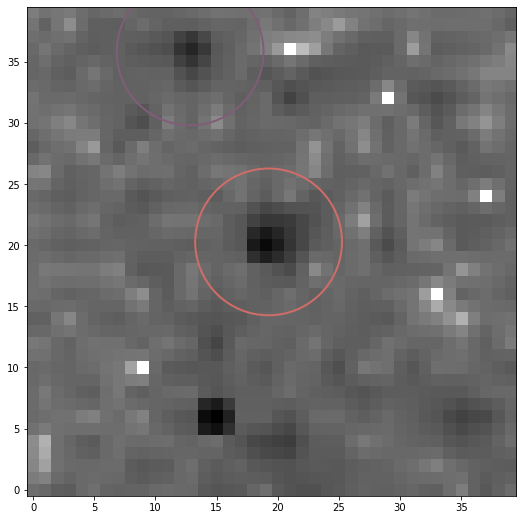

Time taken to fit PSF model: 0.029739500000005137s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.255515 20.258677 4008.3319   1 ... 4498.2229 119.32239             1
12.842023  35.79453  1651.618   2 ...  1964.124 73.524306             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


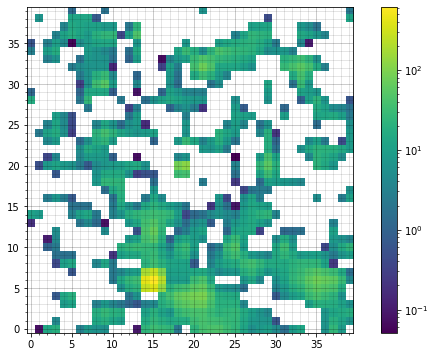

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.255515 20.258677    16.420101 0.041260712
  2        2             1 12.842023  35.79453    17.319781 0.050247543
first match table:
 id  xcenter   ycenter    mag_e2     err_e2  
--- --------- --------- --------- -----------
  1 19.255515 20.258677 16.420101 0.041260712
  2 12.842023  35.79453 17.319781 0.050247543
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05314435, -0.16745388), (229.05076385, -0.16597719)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0  17.5

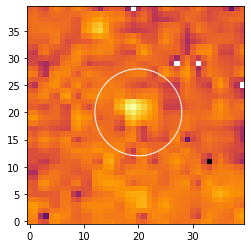

Mean: 47.087528228759766
Median: 44.870487213134766
Std dev: 20.56047248840332
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


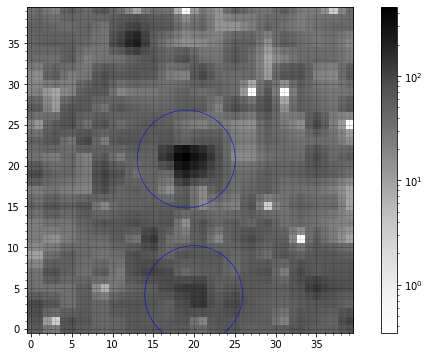

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.938693 4.1834707 0.36345366 ... 118.67358  1.122307 -0.12527918        1
  2 19.050473   20.8107 0.79079518 ... 463.30774 4.1436501  -1.5434577        2


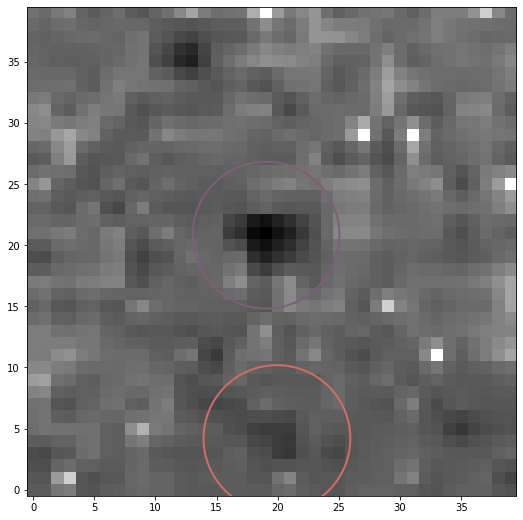

Time taken to fit PSF model: 0.03251090000003387s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.938693 4.1834707 2811.1269   1 ...  1525.146 114.99214             1
19.050473   20.8107 4252.8996   2 ... 4768.3704 126.55147             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


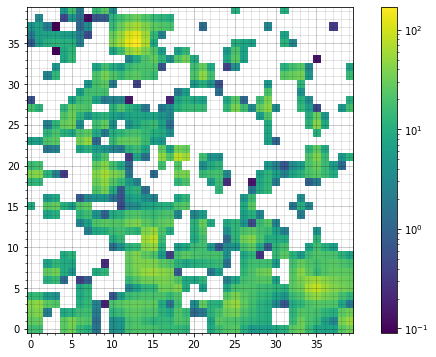

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.938693 4.1834707     17.59489 0.087030485
  2        2             1 19.050473   20.8107    16.357244 0.041270727
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1 19.938693 4.1834707  17.59489 0.087030485
  2 19.050473   20.8107 16.357244 0.041270727
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05576938, -0.16800199), (229.05305908, -0.16740521)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
comp @ idx:
[0 0]
id_master   x_0     y_0       RA    ...    err_e1     mag_e2     err_e2  
--------- -------- ------ --------- ... ----------- --------- -----------
        0 17.55

IndexError: index -99 is out of bounds for axis 0 with size 2

In [9]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        star = 2
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')
        print_table_nicely(master_table)
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                #sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')                
                
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                
                print('first match table:')
                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            print(cat_match)
            print(cat_m)

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)
            idx2, d2d2, d3d2 = match_coordinates_sky(cat_match, cat_m)
            
            print(idx, d2d, d3d)
            print(idx2, d2d2, d3d2)
            
            print('comp @ idx:')
            print(idx)
            print(comp_table[idx])

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d > max_sep)
            match_index = idx
            match_index[selection] = -99
            ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

            print(ind, match_index)

            print('\n\n')
            print_table_nicely(match_table)
            print_table_nicely(comp_table)
            print('\n\n')

            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            
            print(match_table)
            print(comp_table)
            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            match_table = match_table[ind]
            comp_table = comp_table[match_index][ind]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        '''save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()'''


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946
        1  23.78174 2.2946799 228.99106 -0.11590368
        2 19.035947 17.895987 228.98862 -0.11470356
        3 28.339118 3.5178503 228.99074 -0.11662042
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1094.44146707), array(511.14364631))


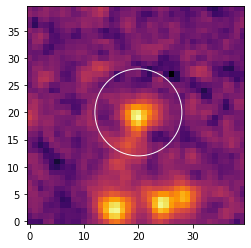

Mean: 51.14960861206055
Median: 45.8643913269043
Std dev: 20.52968978881836
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.575564766899848 ...  3.229357000877366 -1.2727901457891397
  2 24.468016488625913 ... 2.6370181380326754 -1.0527827924589486
  3 19.840980613332604 ... 3.0119700744567304 -1.1971266315018754
Number of PSF stars: 3


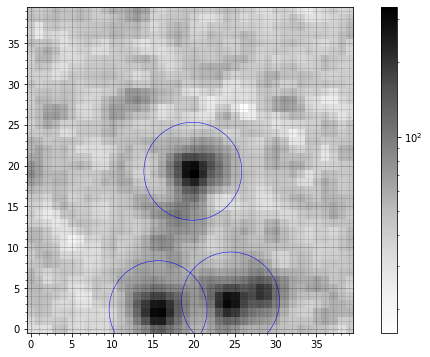

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.575565 2.3412497  0.5500007 ... 313.79651  3.229357 -1.2727901        1
  2 24.468016 3.4122953 0.66038248 ... 308.46622 2.6370181 -1.0527828        1
  3 19.840981 19.312539 0.66081841 ... 335.77524 3.0119701 -1.1971266        2


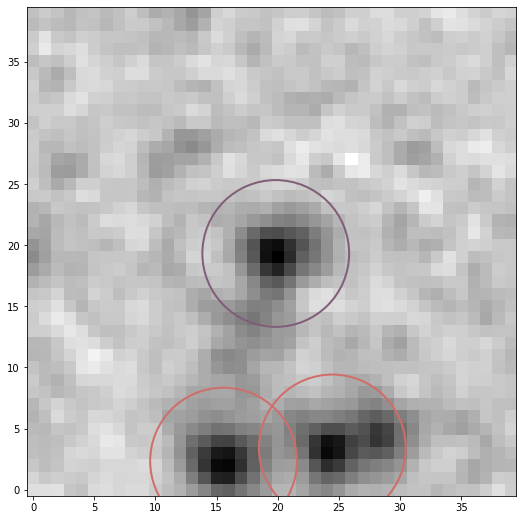

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13006529999984195s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.575565 2.3412497  5234.599   1 ... 4282.3508 158.62785             1
24.468016 3.4122953 6343.6234   2 ... 4203.3857 159.67692             1
19.840981 19.312539 5035.5648   3 ... 4349.1952 97.013214             1
28.818834 4.6227482 1987.8664   4 ... 1950.2446 69.134211             2


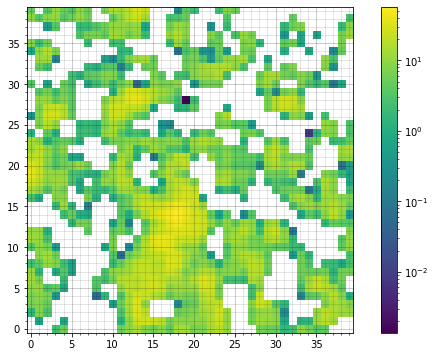

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.575565 2.3412497    16.481396 0.049904437
  2        1             1 24.468016 3.4122953    16.501604 0.050735348
  3        2             1 19.840981 19.312539     16.46458 0.038203282
  4        1             2 28.818834 4.6227482    17.335379 0.048521165
 id  xcenter   ycenter    mag_e1     err_e1   id_master
--- --------- --------- --------- ----------- ---------
  1 15.575565 2.3412497 16.481396 0.049904437         0
  2 24.468016 3.4122953 16.501604 0.050735348         1
  3 19.840981 19.312539  16.46458 0.038203282         2
  4 28.818834 4.6227482 17.335379 0.048521165         3
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946 16.481396 0.049904437
        1 

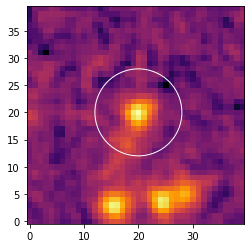

Mean: 45.08599090576172
Median: 39.76604461669922
Std dev: 21.78135871887207
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.529851137079332 ... 2.8684341330745937 -1.1441122044230256
  2 24.588323791199468 ...  2.521756212073415 -1.0042577483475987
  3 19.895611595859556 ... 3.2725228838763614 -1.2872067303461203
Number of PSF stars: 3


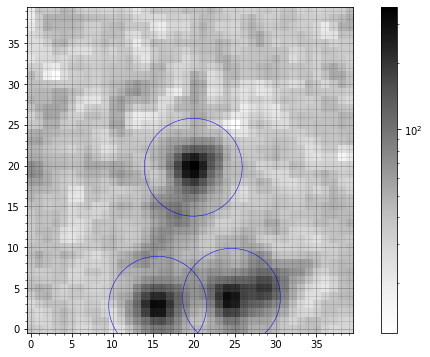

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.529851 2.8852351  0.6115023 ...  317.5033 2.8684341 -1.1441122        1
  2 24.588324 3.8501471 0.64750822 ... 305.72614 2.5217562 -1.0042577        1
  3 19.895612  19.80354 0.63817235 ... 359.59317 3.2725229 -1.2872067        2


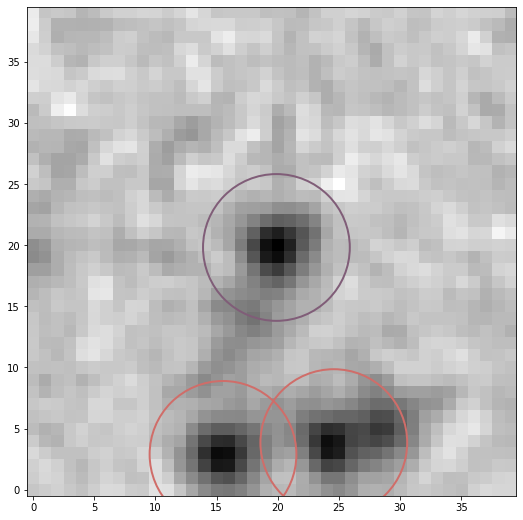

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05155899999954272s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.529851 2.8852351 4907.8212   1 ...  3888.027 149.42427             1
24.588324 3.8501471 6495.5983   2 ... 4029.7415 151.86088             1
19.895612  19.80354 5290.4631   3 ...  4546.161 96.792641             1
28.991484 5.2863925 2094.5302   4 ...  2008.288 91.399826             2


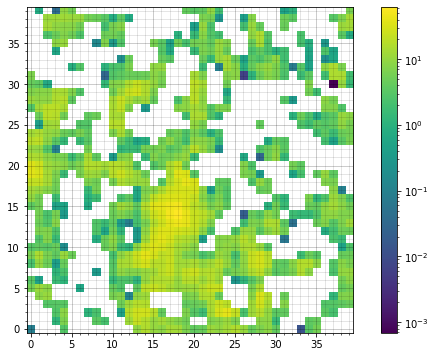

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.529851 2.8852351    16.585697 0.051128195
  2        1             1 24.588324 3.8501471    16.546827  0.05046856
  3        2             1 19.895612  19.80354    16.415908 0.037514391
  4        1             2 28.991484 5.2863925    17.302955 0.057572822
 id  xcenter   ycenter    mag_e2     err_e2   id_master
--- --------- --------- --------- ----------- ---------
  1 15.529851 2.8852351 16.585697 0.051128195         0
  2 24.588324 3.8501471 16.546827  0.05046856         1
  3 19.895612  19.80354 16.415908 0.037514391         2
  4 28.991484 5.2863925 17.302955 0.057572822         3
id_master    x_0       y_0        RA    ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049904437 16.585697 0.05112819

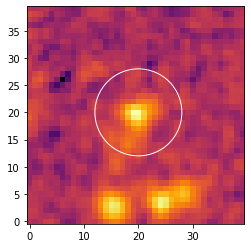

Mean: 43.298133850097656
Median: 38.060081481933594
Std dev: 21.694374084472656
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.324348926937843 ...  2.740425138283709  -1.094544856766432
  2 24.356835138718903 ...  2.714869883759798 -1.0843725497115577
  3  19.62447740837231 ... 3.2168555396751186 -1.2685788958587219
Number of PSF stars: 3


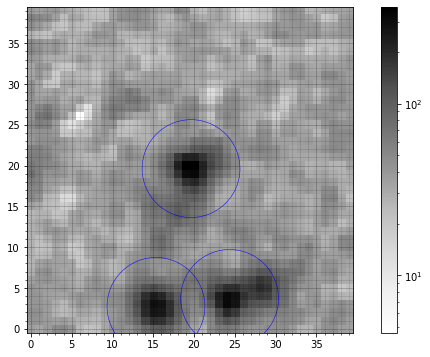

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.324349 2.7371235  0.5340575 ... 289.66589 2.7404251 -1.0945449        1
  2 24.356835 3.7104366 0.65278165 ... 315.94113 2.7148699 -1.0843725        1
  3 19.624477  19.63687  0.6275326 ... 355.89859 3.2168555 -1.2685789        2


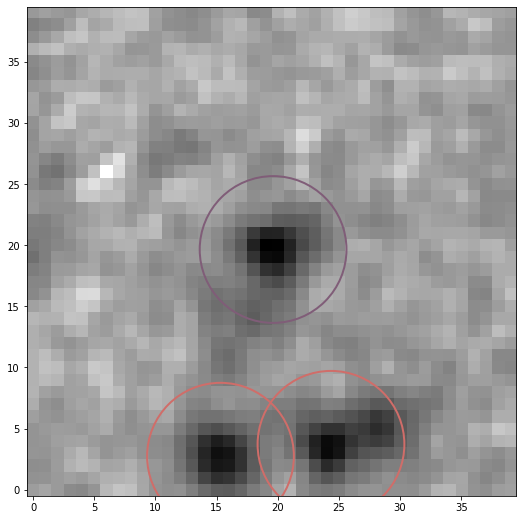

Time taken to fit PSF model: 0.05036079999990761s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.324349 2.7371235 4992.7411   1 ... 4055.7058 150.07603             1
24.356835 3.7104366  6316.759   2 ... 4313.4969 150.60356             1
19.624477  19.63687 5878.2963   3 ... 4946.7007 89.934214             1
28.912678 5.2484861 2236.2822   4 ... 2001.7659 81.189482             2


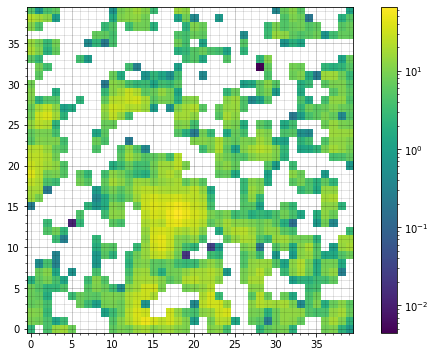

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.324349 2.7371235    16.540501 0.049870705
  2        1             1 24.356835 3.7104366    16.473594 0.048062134
  3        2             1 19.624477  19.63687    16.324878 0.035533096
  4        1             2 28.912678 5.2484861    17.307134 0.053029737
 id  xcenter   ycenter    mag_e3     err_e3   id_master
--- --------- --------- --------- ----------- ---------
  1 15.324349 2.7371235 16.540501 0.049870705         0
  2 24.356835 3.7104366 16.473594 0.048062134         1
  3 19.624477  19.63687 16.324878 0.035533096         2
  4 28.912678 5.2484861 17.307134 0.053029737         3
id_master    x_0       y_0        RA    ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.051128195 16.540501 0.04987070

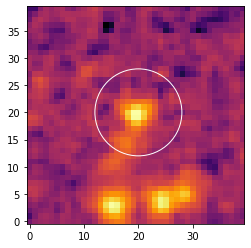

Mean: 41.48185729980469
Median: 36.60084533691406
Std dev: 21.256439208984375
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.402103064215103 ...  2.940967477508381 -1.1712255547930523
  2 24.441040130497164 ... 2.5445886987166184 -1.0140439850382048
  3 19.584984056330125 ...  3.317834368858013 -1.3021367540351565
Number of PSF stars: 3


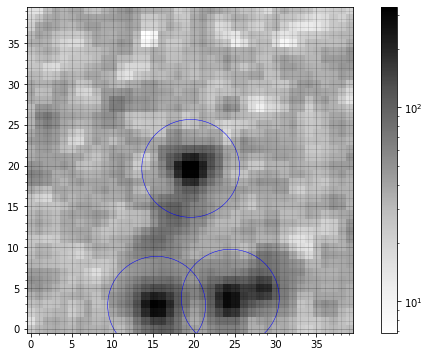

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.402103 2.8725598 0.62275623 ... 325.81424 2.9409675 -1.1712256        1
  2  24.44104 3.7414083 0.61550877 ... 291.70139 2.5445887  -1.014044        1
  3 19.584984 19.661793 0.57186691 ... 331.10718 3.3178344 -1.3021368        2


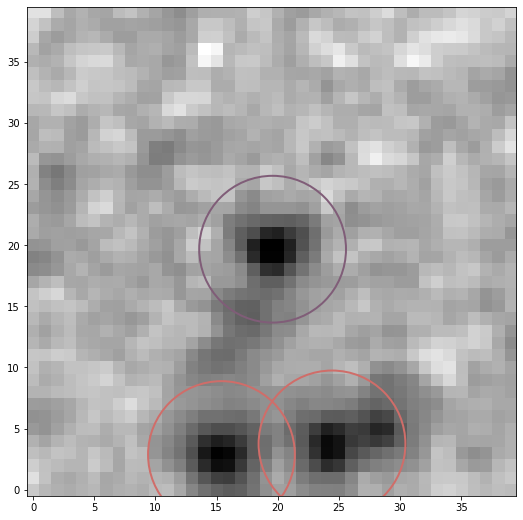

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13611569999920903s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.402103 2.8725598 5329.7702   1 ... 4051.8584 141.20479             1
 24.44104 3.7414083 6082.0895   2 ... 4012.1419 146.73186             1
19.584984 19.661793 5237.4321   3 ... 4606.1036 84.637918             1
28.863052 5.1782517 1945.5198   4 ... 1840.7738  83.87635             2


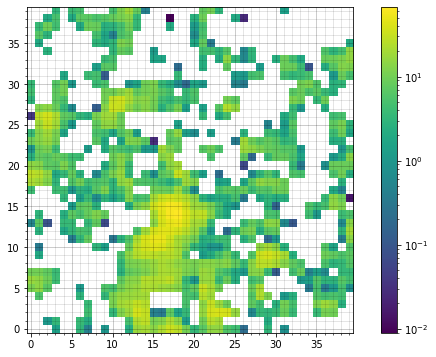

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.402103 2.8725598    16.541081 0.048006401
  2        1             1  24.44104 3.7414083    16.551776 0.049493862
  3        2             1 19.584984 19.661793    16.401882 0.035650853
  4        1             2 28.863052 5.1782517    17.397715 0.057623613
 id  xcenter   ycenter    mag_e4     err_e4   id_master
--- --------- --------- --------- ----------- ---------
  1 15.402103 2.8725598 16.541081 0.048006401         0
  2  24.44104 3.7414083 16.551776 0.049493862         1
  3 19.584984 19.661793 16.401882 0.035650853         2
  4 28.863052 5.1782517 17.397715 0.057623613         3
id_master    x_0       y_0        RA    ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049870705 16.541081 0.04800640

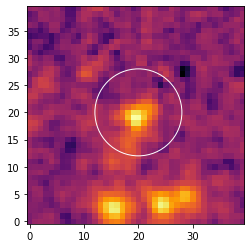

Mean: 41.5771484375
Median: 36.40973663330078
Std dev: 20.748353958129883
 id     xcentroid     ...        flux               mag         
--- ----------------- ... ----------------- --------------------
  1 15.41594560840494 ... 3.177380045210075  -1.2551729093265562
  2 24.46245075408594 ... 2.722809928717321   -1.087543313972069
  3 28.03162586417031 ... 1.344736198500567 -0.32159273915026876
  4 19.64046228737398 ... 3.441693502329084  -1.3419304797856226
Number of PSF stars: 4


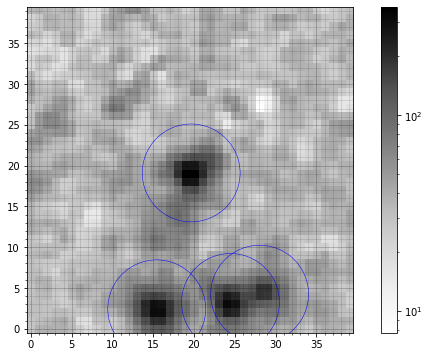

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.415946 2.4431413 0.54827609 ...  302.9071   3.17738  -1.2551729        1
  2 24.462451 3.2251417 0.69369881 ... 313.86978 2.7228099  -1.0875433        1
  3 28.031626 4.2359861 0.67056078 ... 186.96165 1.3447362 -0.32159274        1
  4 19.640462 19.105593  0.6297486 ... 353.34238 3.4416935  -1.3419305        2


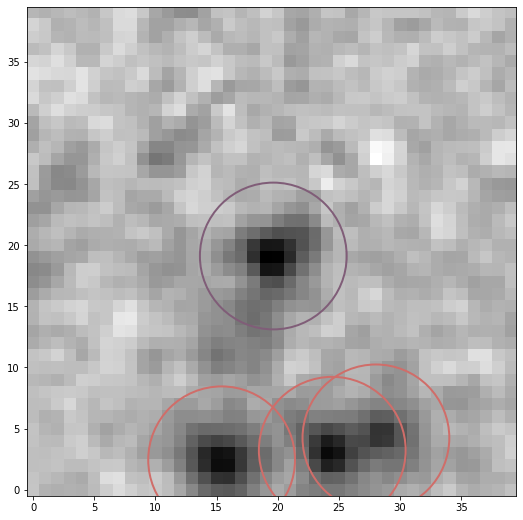

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04051690000051167s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.415946 2.4431413 5087.0391   1 ... 4361.4582 93.197894             1
24.462451 3.2251417 6117.9363   2 ... 3480.1308 89.643748             1
28.031626 4.2359861 5933.2528   3 ... 1937.2708 95.931724             1
19.640462 19.105593 5364.6779   4 ... 4337.1694 89.390413             1


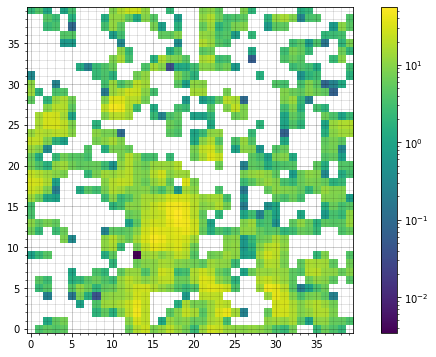

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.415946 2.4431413    16.461172 0.037566263
  2        1             1 24.462451 3.2251417    16.706262 0.040683178
  3        1             1 28.031626 4.2359861    17.342275 0.061348083
  4        2             1 19.640462 19.105593    16.467235 0.037063511
 id  xcenter   ycenter    mag_e5     err_e5   id_master
--- --------- --------- --------- ----------- ---------
  1 15.415946 2.4431413 16.461172 0.037566263         0
  2 24.462451 3.2251417 16.706262 0.040683178         1
  3 28.031626 4.2359861 17.342275 0.061348083         2
  4 19.640462 19.105593 16.467235 0.037063511         3
id_master    x_0       y_0        RA    ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.048006401 16.461172 0.03756626

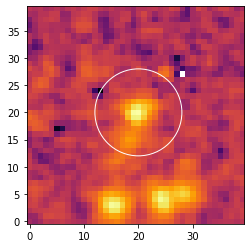

Mean: 34.465213775634766
Median: 28.9788818359375
Std dev: 21.482254028320312
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.434755562019973 ...  2.738553859224638 -1.0938032165799807
  2 24.534598456523725 ... 2.4849501718563496 -0.9882942117430025
  3  19.74102929173598 ... 3.1529990801217895 -1.2468096101094626
Number of PSF stars: 3


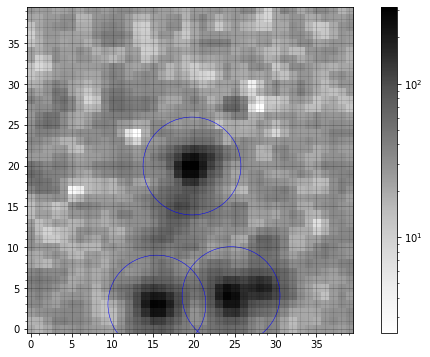

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.434756 3.0174515 0.61955722 ... 295.59125 2.7385539  -1.0938032        1
  2 24.534598 4.0607341 0.64556602 ... 289.43369 2.4849502 -0.98829421        1
  3 19.741029 19.956366 0.59445665 ... 317.62701 3.1529991  -1.2468096        2


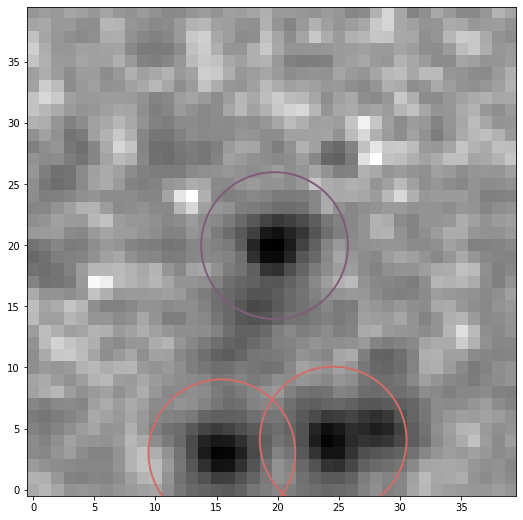

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.053249399999913294s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.434756 3.0174515 4753.6891   1 ... 3652.2488 138.09474             1
24.534598 4.0607341 6293.5869   2 ... 3843.2674 138.94848             1
19.741029 19.956366 5310.5515   3 ... 4089.3208 104.98822             1
28.973933 5.1364362 2135.1223   4 ...  1802.625 89.064865             2


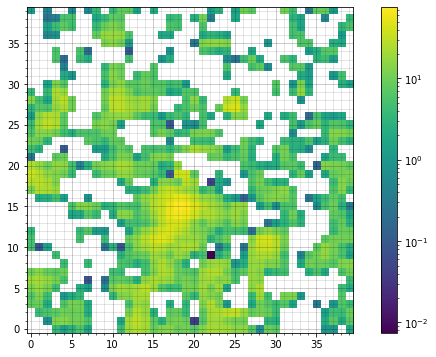

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.434756 3.0174515    16.653923 0.050579411
  2        1             1 24.534598 4.0607341    16.598573 0.049130323
  3        2             1 19.741029 19.956366    16.531196  0.04061981
  4        1             2 28.973933 5.1364362    17.420561 0.061242892
 id  xcenter   ycenter    mag_e6     err_e6   id_master
--- --------- --------- --------- ----------- ---------
  1 15.434756 3.0174515 16.653923 0.050579411         0
  2 24.534598 4.0607341 16.598573 0.049130323         1
  3 19.741029 19.956366 16.531196  0.04061981         2
  4 28.973933 5.1364362 17.420561 0.061242892         3
id_master    x_0       y_0        RA    ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.037566263 16.653923 0.05057941

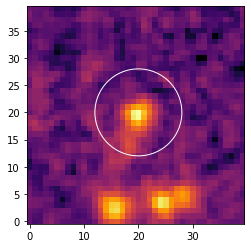

Mean: 44.564720153808594
Median: 39.59773254394531
Std dev: 20.280550003051758
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.564749020605866 ... 2.9685813322824215 -1.1813723802308034
  2 24.521924645846568 ...  2.701261719771453 -1.0789166603446532
  3    19.834005774293 ...  3.475327996429202 -1.3524894973636068
Number of PSF stars: 3


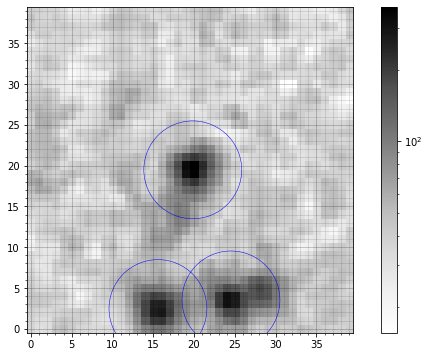

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.564749 2.4744354  0.5221548 ... 280.71216 2.9685813 -1.1813724        1
  2 24.521925 3.5346052 0.66508775 ... 305.35577 2.7012617 -1.0789167        1
  3 19.834006 19.485999 0.67392894 ... 367.90244  3.475328 -1.3524895        2


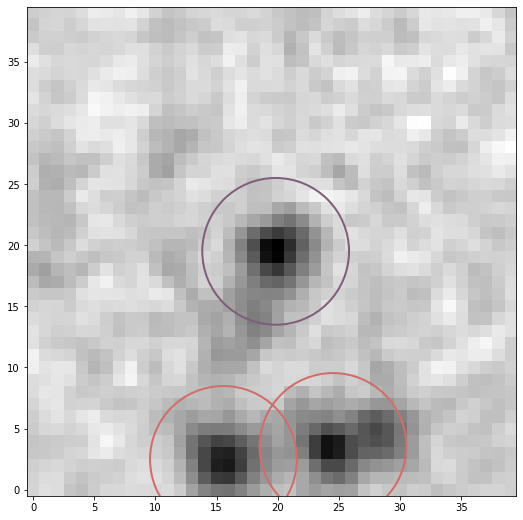

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.11658429999806685s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.564749 2.4744354 4970.8549   1 ... 4167.3416 152.34688             1
24.521925 3.5346052 6218.9892   2 ... 4314.5054 151.11573             1
19.834006 19.485999 5261.3001   3 ... 4973.3311  114.0385             1
28.882514  4.655196 1819.9378   4 ... 1733.0658 75.841961             2


KeyboardInterrupt: 

In [145]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
    
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')

        print_table_nicely(master_table)

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi=1.)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                    
                print(sources_PSF)
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                for i, group in enumerate(star_groups.groups):
                    pos_group = np.transpose([group['x_0'], group['y_0']])
                    ap_group = CircularAperture(pos_group, r_ap)
                    ap_group.plot(color=cmap.colors[i], lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                match_table['id_master'] = master_table['id_master']

                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###


            # This approach relies on the same stars being detected in the same order in each epoch, which isn't ideal:
            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)


            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close() 


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###